In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D,Input
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

from keras.utils.vis_utils import plot_model
from keras.layers.merge import concatenate
import pydot

Using TensorFlow backend.


In [2]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions,title="Confusion Matrix"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function reads the accelerometer data from a file
    Args:
        file_path: URL pointing to the CSV file
    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


In [3]:
import pickle
def read_h5():
    lst = []
    with open("X and Y Dataset/x_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/x_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    return lst
def read_properties():
    lst = None
    with open('X and Y Dataset/properties.pickle','rb+') as fd:
        lst = pickle.load(fd)
    return lst
x_train,y_train,x_test,y_test = read_h5()
TIME_PERIODS = 80
num_time_periods, num_sensors,num_classes,input_shape = read_properties()
LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]


--- Create neural network model ---

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 341us/step - loss: 0.6036 - accuracy: 0.7805 - val_loss: 0.5741 - val_accuracy: 0.8122
Epoch 2/25
16694/16694 [==============================] - 8s 463us/step - loss: 0.2998 - accuracy: 0.8974 - val_loss: 0.5604 - val_accuracy: 0.8325
Epoch 3/25
16694/16694 [==============================] - 6s 365us/step - loss: 0.2248 - accuracy: 0.9272 - val_loss: 0.6738 - val_accuracy: 0.8086
Epoch 4/25
16694/16694 [==============================] - 6s 339us/step - loss: 0.1891 - accuracy: 0.9406 - val_loss: 0.8317 - val_accuracy: 0.7856
Epoch 5/25
16694/16694 [==============================] - 6s 343us/step - loss: 0.1654 - accuracy: 0.9481 - val_loss: 0.8603 - val_accuracy: 0.8059
Epoch 6/25
16694/16694 [==============================] - 6s 334us/step - loss: 0.1539 - accuracy: 0.9522 - val_loss: 0.9192 - val_accuracy: 0.8119
Epoch 7/25
16694/16694 [=

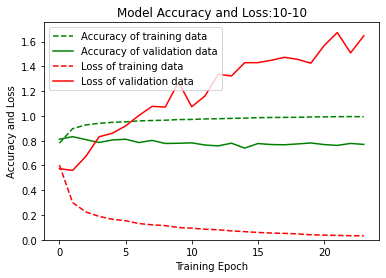


--- Check against test data ---

6584/6584 [==============================] - 1s 87us/step

Accuracy on test data: 0.87

Loss on test data: 0.68

--- Confusion matrix for test data ---



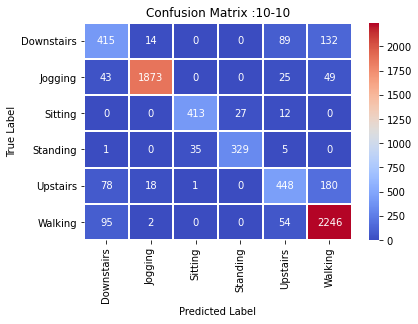


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       650
           1       0.98      0.94      0.96      1990
           2       0.92      0.91      0.92       452
           3       0.92      0.89      0.91       370
           4       0.71      0.62      0.66       725
           5       0.86      0.94      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.82      0.83      6584
weighted avg       0.87      0.87      0.87      6584



0.8693802952766418

In [4]:
print("\n--- Create neural network model ---\n")
def call_model(kernal_size=20,filter_size=10):
    input1 = Input(shape=(input_shape, ))
    reshape1 = Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,))(input1)
    conv1 = Conv1D(kernal_size,filter_size,activation='relu')(reshape1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    flat1 = Flatten()(pool1)
    
#     input2 = Input(shape=(input_shape, ))
#     reshape2 = Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,))(input2)
    conv2 = Conv1D(kernal_size,filter_size,activation='relu')(reshape1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    flat2 = Flatten()(pool2)
    
    merged = concatenate([flat1, flat2])
    outputs = Dense(num_classes, activation='softmax')(merged)
    
    model_m = Model(inputs=input1, outputs=outputs)
#     plot_model(model, show_shapes=True, to_file='multichannel1DCNN.png')
    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
    ]

    model_m.compile(loss='categorical_crossentropy',
                    optimizer='adam', metrics=['accuracy'])
    
    BATCH_SIZE = 200
    EPOCHS = 25

    # Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
    history = model_m.fit(x_train,
                          y_train,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          callbacks=callbacks_list,
                          validation_split=0.2,
                          verbose=1)

    print("\n--- Learning curve of model training ---\n")

    # summarize history for accuracy and loss
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
    plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
    plt.plot(history.history['loss'], "r--", label="Loss of training data")
    plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
    plt.title('Model Accuracy and Loss:'+str(filter_size)+"-"+str(filter_size))
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
    print("\n--- Check against test data ---\n")

    score = model_m.evaluate(x_test, y_test, verbose=1)

    print("\nAccuracy on test data: %0.2f" % score[1])
    print("\nLoss on test data: %0.2f" % score[0])

    print("\n--- Confusion matrix for test data ---\n")

    y_pred_test = model_m.predict(x_test)
    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(y_test, axis=1)

    show_confusion_matrix(max_y_test, max_y_pred_test,title="Confusion Matrix :"+str(filter_size)+"-"+str(filter_size))
    print("\n--- Classification report for test data "+str(filter_size)+":"+str(filter_size)+"---\n")

    print(classification_report(max_y_test, max_y_pred_test))
    return score[1]
    
call_model()

## Running model for various Filters and Kernals

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 88us/step - loss: 1.2915 - accuracy: 0.5058 - val_loss: 0.8940 - val_accuracy: 0.7053
Epoch 2/25
16694/16694 [==============================] - 1s 62us/step - loss: 0.8569 - accuracy: 0.7147 - val_loss: 0.7650 - val_accuracy: 0.7748
Epoch 3/25
16694/16694 [==============================] - 1s 66us/step - loss: 0.7020 - accuracy: 0.7664 - val_loss: 0.6909 - val_accuracy: 0.8031
Epoch 4/25
16694/16694 [==============================] - 1s 68us/step - loss: 0.6171 - accuracy: 0.7908 - val_loss: 0.6633 - val_accuracy: 0.7944
Epoch 5/25
16694/16694 [==============================] - 1s 55us/step - loss: 0.5685 - accuracy: 0.8036 - val_loss: 0.6417 - val_accuracy: 0.8004
Epoch 6/25
16694/16694 [==============================] - 1s 55us/step - loss: 0.5357 - accuracy: 0.8117 - val_loss: 0.6287 - val_accuracy: 0.8016
Epoch 7/25
16694/16694 [==============================] - 1s 57us/ste

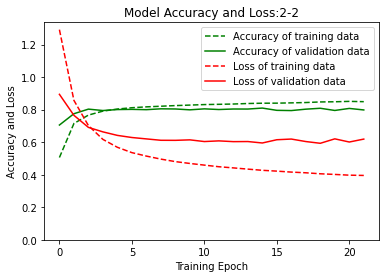


--- Check against test data ---

6584/6584 [==============================] - 1s 76us/step

Accuracy on test data: 0.76

Loss on test data: 0.82

--- Confusion matrix for test data ---



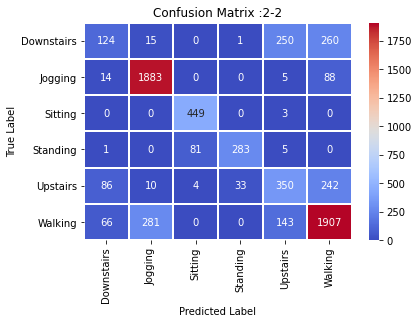


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.43      0.19      0.26       650
           1       0.86      0.95      0.90      1990
           2       0.84      0.99      0.91       452
           3       0.89      0.76      0.82       370
           4       0.46      0.48      0.47       725
           5       0.76      0.80      0.78      2397

    accuracy                           0.76      6584
   macro avg       0.71      0.70      0.69      6584
weighted avg       0.74      0.76      0.74      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 125us/step - loss: 1.1293 - accuracy: 0.5678 - val_loss: 0.9269 - val_accuracy: 0.6679
Epoch 2/25
16694/16694 [==============================] - 2s 108us/step - loss: 0.7881 - accuracy: 0.7327 - val_loss: 0.7298 - val_accuracy: 0.7798
Epoch 3/25
16694/16694 [==============================] - 1s 83

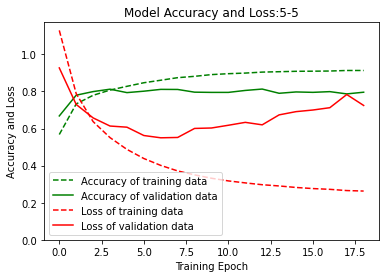


--- Check against test data ---

6584/6584 [==============================] - 0s 64us/step

Accuracy on test data: 0.81

Loss on test data: 0.68

--- Confusion matrix for test data ---



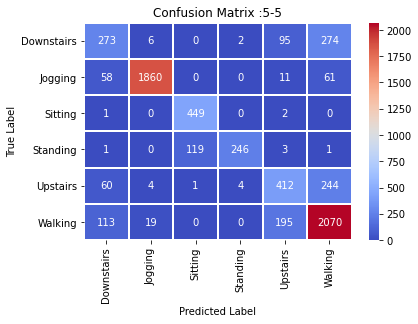


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.54      0.42      0.47       650
           1       0.98      0.93      0.96      1990
           2       0.79      0.99      0.88       452
           3       0.98      0.66      0.79       370
           4       0.57      0.57      0.57       725
           5       0.78      0.86      0.82      2397

    accuracy                           0.81      6584
   macro avg       0.77      0.74      0.75      6584
weighted avg       0.81      0.81      0.80      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 94us/step - loss: 1.1160 - accuracy: 0.5789 - val_loss: 0.7942 - val_accuracy: 0.7489
Epoch 2/25
16694/16694 [==============================] - 1s 66us/step - loss: 0.6700 - accuracy: 0.7618 - val_loss: 0.6511 - val_accuracy: 0.7973
Epoch 3/25
16694/16694 [==============================] - 1s 87us

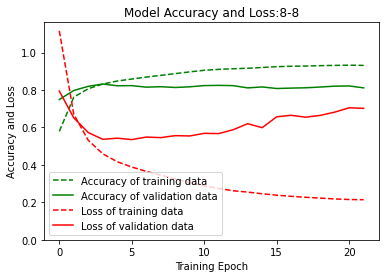


--- Check against test data ---

6584/6584 [==============================] - 0s 59us/step

Accuracy on test data: 0.82

Loss on test data: 0.62

--- Confusion matrix for test data ---



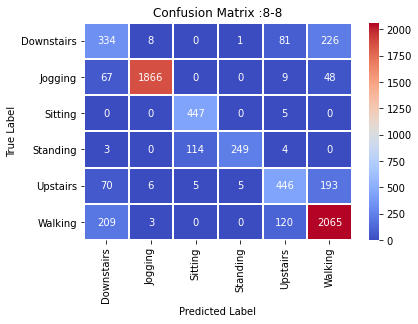


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.49      0.51      0.50       650
           1       0.99      0.94      0.96      1990
           2       0.79      0.99      0.88       452
           3       0.98      0.67      0.80       370
           4       0.67      0.62      0.64       725
           5       0.82      0.86      0.84      2397

    accuracy                           0.82      6584
   macro avg       0.79      0.77      0.77      6584
weighted avg       0.83      0.82      0.82      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 104us/step - loss: 1.1068 - accuracy: 0.5837 - val_loss: 0.8159 - val_accuracy: 0.7307
Epoch 2/25
16694/16694 [==============================] - 1s 69us/step - loss: 0.7089 - accuracy: 0.7349 - val_loss: 0.7172 - val_accuracy: 0.7789
Epoch 3/25
16694/16694 [==============================] - 1s 68u

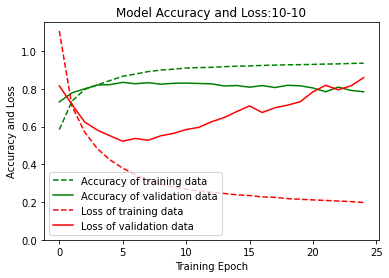


--- Check against test data ---

6584/6584 [==============================] - 0s 61us/step

Accuracy on test data: 0.83

Loss on test data: 0.55

--- Confusion matrix for test data ---



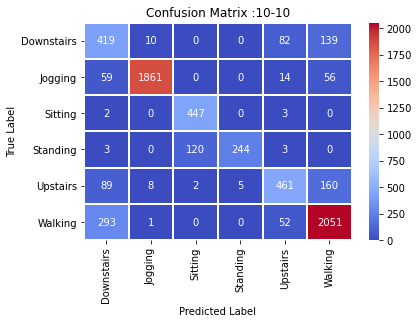


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.48      0.64      0.55       650
           1       0.99      0.94      0.96      1990
           2       0.79      0.99      0.88       452
           3       0.98      0.66      0.79       370
           4       0.75      0.64      0.69       725
           5       0.85      0.86      0.85      2397

    accuracy                           0.83      6584
   macro avg       0.81      0.79      0.79      6584
weighted avg       0.85      0.83      0.84      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 96us/step - loss: 1.2036 - accuracy: 0.5279 - val_loss: 0.8433 - val_accuracy: 0.7381
Epoch 2/25
16694/16694 [==============================] - 1s 67us/step - loss: 0.6886 - accuracy: 0.7539 - val_loss: 0.7085 - val_accuracy: 0.7774
Epoch 3/25
16694/16694 [==============================] - 1s 68

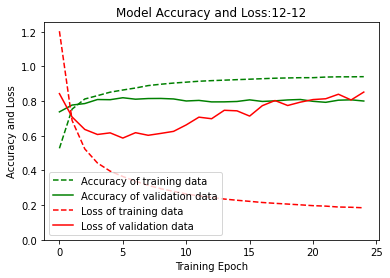


--- Check against test data ---

6584/6584 [==============================] - 0s 64us/step

Accuracy on test data: 0.82

Loss on test data: 0.66

--- Confusion matrix for test data ---



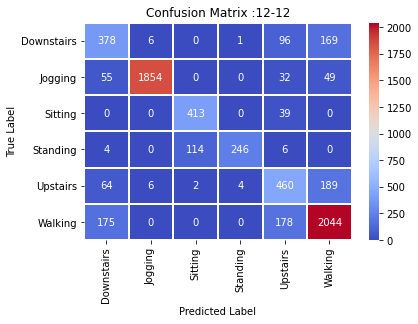


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.56      0.58      0.57       650
           1       0.99      0.93      0.96      1990
           2       0.78      0.91      0.84       452
           3       0.98      0.66      0.79       370
           4       0.57      0.63      0.60       725
           5       0.83      0.85      0.84      2397

    accuracy                           0.82      6584
   macro avg       0.79      0.76      0.77      6584
weighted avg       0.83      0.82      0.82      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 96us/step - loss: 1.0422 - accuracy: 0.6014 - val_loss: 0.7570 - val_accuracy: 0.7786
Epoch 2/25
16694/16694 [==============================] - 1s 73us/step - loss: 0.6679 - accuracy: 0.7572 - val_loss: 0.6632 - val_accuracy: 0.7832
Epoch 3/25
16694/16694 [==============================] - 1s 75

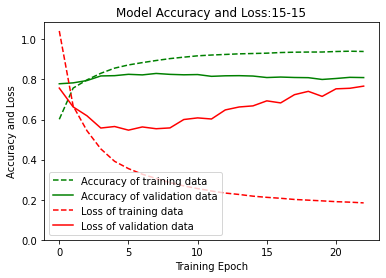


--- Check against test data ---

6584/6584 [==============================] - 1s 81us/step

Accuracy on test data: 0.85

Loss on test data: 0.58

--- Confusion matrix for test data ---



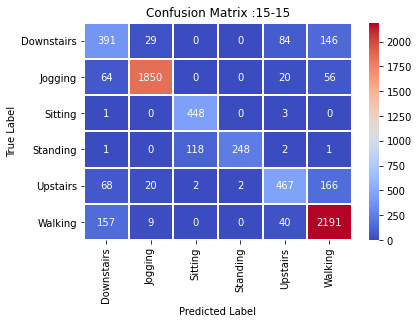


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.57      0.60      0.59       650
           1       0.97      0.93      0.95      1990
           2       0.79      0.99      0.88       452
           3       0.99      0.67      0.80       370
           4       0.76      0.64      0.70       725
           5       0.86      0.91      0.88      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.79      0.80      6584
weighted avg       0.85      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 132us/step - loss: 1.0152 - accuracy: 0.6335 - val_loss: 0.7649 - val_accuracy: 0.7561
Epoch 2/25
16694/16694 [==============================] - 1s 78us/step - loss: 0.6173 - accuracy: 0.7709 - val_loss: 0.6416 - val_accuracy: 0.7853
Epoch 3/25
16694/16694 [==============================] - 1s 8

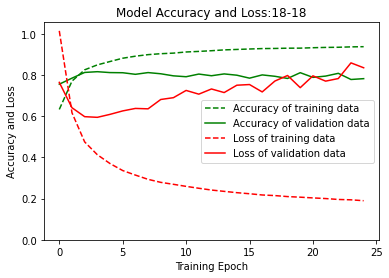


--- Check against test data ---

6584/6584 [==============================] - 0s 60us/step

Accuracy on test data: 0.82

Loss on test data: 0.66

--- Confusion matrix for test data ---



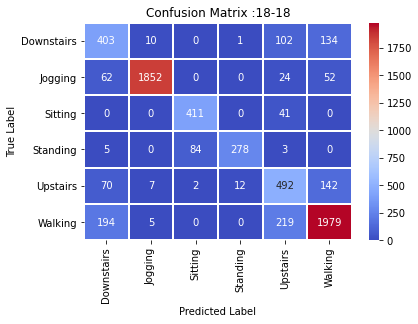


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.55      0.62      0.58       650
           1       0.99      0.93      0.96      1990
           2       0.83      0.91      0.87       452
           3       0.96      0.75      0.84       370
           4       0.56      0.68      0.61       725
           5       0.86      0.83      0.84      2397

    accuracy                           0.82      6584
   macro avg       0.79      0.79      0.78      6584
weighted avg       0.84      0.82      0.83      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 91us/step - loss: 1.0126 - accuracy: 0.6208 - val_loss: 0.6515 - val_accuracy: 0.8021
Epoch 2/25
16694/16694 [==============================] - 1s 70us/step - loss: 0.5968 - accuracy: 0.7808 - val_loss: 0.5790 - val_accuracy: 0.8165
Epoch 3/25
16694/16694 [==============================] - 1s 81

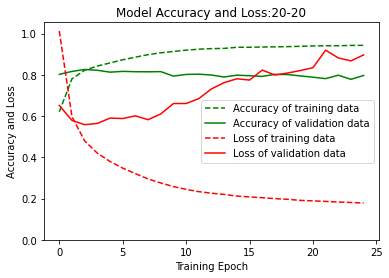


--- Check against test data ---

6584/6584 [==============================] - 0s 75us/step

Accuracy on test data: 0.84

Loss on test data: 0.57

--- Confusion matrix for test data ---



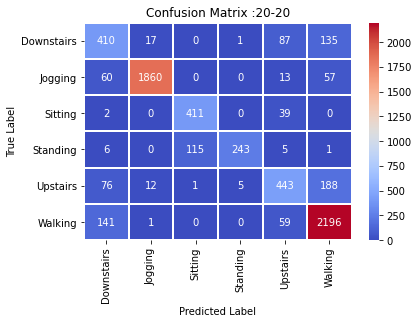


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.59      0.63      0.61       650
           1       0.98      0.93      0.96      1990
           2       0.78      0.91      0.84       452
           3       0.98      0.66      0.79       370
           4       0.69      0.61      0.65       725
           5       0.85      0.92      0.88      2397

    accuracy                           0.84      6584
   macro avg       0.81      0.78      0.79      6584
weighted avg       0.85      0.84      0.84      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 71us/step - loss: 0.9823 - accuracy: 0.6332 - val_loss: 0.7875 - val_accuracy: 0.7808
Epoch 2/25
16694/16694 [==============================] - 1s 50us/step - loss: 0.6644 - accuracy: 0.7764 - val_loss: 0.6810 - val_accuracy: 0.8057
Epoch 3/25
16694/16694 [==============================] - 1s 51

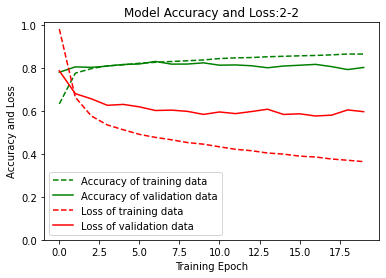


--- Check against test data ---

6584/6584 [==============================] - 1s 81us/step

Accuracy on test data: 0.76

Loss on test data: 0.90

--- Confusion matrix for test data ---



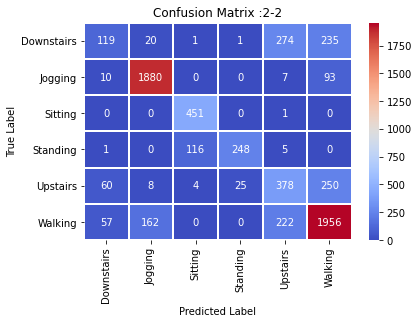


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.48      0.18      0.27       650
           1       0.91      0.94      0.93      1990
           2       0.79      1.00      0.88       452
           3       0.91      0.67      0.77       370
           4       0.43      0.52      0.47       725
           5       0.77      0.82      0.79      2397

    accuracy                           0.76      6584
   macro avg       0.71      0.69      0.68      6584
weighted avg       0.76      0.76      0.75      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 108us/step - loss: 0.9287 - accuracy: 0.6544 - val_loss: 0.7667 - val_accuracy: 0.7726
Epoch 2/25
16694/16694 [==============================] - 1s 78us/step - loss: 0.6050 - accuracy: 0.7871 - val_loss: 0.6438 - val_accuracy: 0.7908
Epoch 3/25
16694/16694 [==============================] - 1s 82u

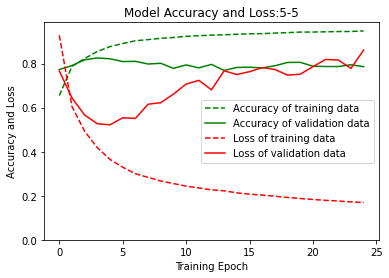


--- Check against test data ---

6584/6584 [==============================] - 0s 71us/step

Accuracy on test data: 0.80

Loss on test data: 0.78

--- Confusion matrix for test data ---



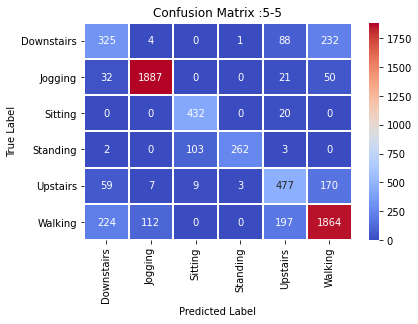


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.51      0.50      0.50       650
           1       0.94      0.95      0.94      1990
           2       0.79      0.96      0.87       452
           3       0.98      0.71      0.82       370
           4       0.59      0.66      0.62       725
           5       0.80      0.78      0.79      2397

    accuracy                           0.80      6584
   macro avg       0.77      0.76      0.76      6584
weighted avg       0.80      0.80      0.80      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 84us/step - loss: 1.0102 - accuracy: 0.6170 - val_loss: 0.7186 - val_accuracy: 0.7892
Epoch 2/25
16694/16694 [==============================] - 1s 62us/step - loss: 0.6360 - accuracy: 0.7579 - val_loss: 0.6544 - val_accuracy: 0.7925
Epoch 3/25
16694/16694 [==============================] - 1s 62us

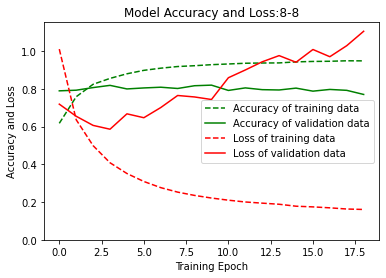


--- Check against test data ---

6584/6584 [==============================] - 0s 57us/step

Accuracy on test data: 0.84

Loss on test data: 0.59

--- Confusion matrix for test data ---



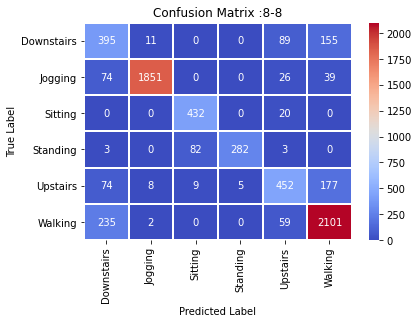


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.51      0.61      0.55       650
           1       0.99      0.93      0.96      1990
           2       0.83      0.96      0.89       452
           3       0.98      0.76      0.86       370
           4       0.70      0.62      0.66       725
           5       0.85      0.88      0.86      2397

    accuracy                           0.84      6584
   macro avg       0.81      0.79      0.80      6584
weighted avg       0.85      0.84      0.84      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 110us/step - loss: 0.9836 - accuracy: 0.6225 - val_loss: 0.7288 - val_accuracy: 0.7688
Epoch 2/25
16694/16694 [==============================] - 1s 82us/step - loss: 0.5731 - accuracy: 0.7942 - val_loss: 0.6178 - val_accuracy: 0.8033
Epoch 3/25
16694/16694 [==============================] - 1s 85u

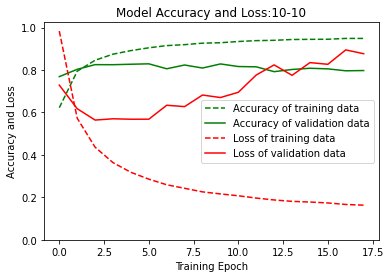


--- Check against test data ---

6584/6584 [==============================] - 0s 61us/step

Accuracy on test data: 0.84

Loss on test data: 0.57

--- Confusion matrix for test data ---



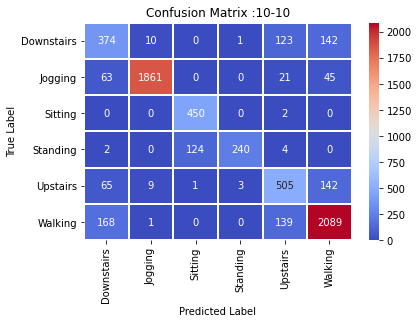


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.56      0.58      0.57       650
           1       0.99      0.94      0.96      1990
           2       0.78      1.00      0.88       452
           3       0.98      0.65      0.78       370
           4       0.64      0.70      0.66       725
           5       0.86      0.87      0.87      2397

    accuracy                           0.84      6584
   macro avg       0.80      0.79      0.79      6584
weighted avg       0.85      0.84      0.84      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 106us/step - loss: 0.9200 - accuracy: 0.6580 - val_loss: 0.6610 - val_accuracy: 0.8004
Epoch 2/25
16694/16694 [==============================] - 1s 78us/step - loss: 0.5185 - accuracy: 0.8123 - val_loss: 0.5487 - val_accuracy: 0.8234
Epoch 3/25
16694/16694 [==============================] - 1s 8

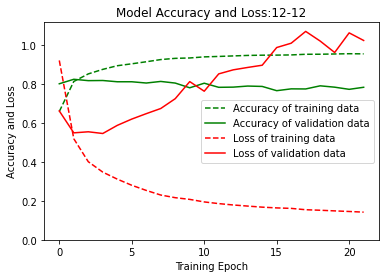


--- Check against test data ---

6584/6584 [==============================] - 0s 57us/step

Accuracy on test data: 0.85

Loss on test data: 0.57

--- Confusion matrix for test data ---



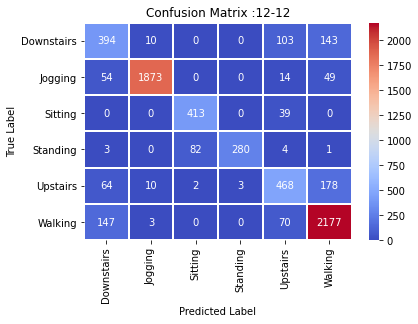


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.60      0.61      0.60       650
           1       0.99      0.94      0.96      1990
           2       0.83      0.91      0.87       452
           3       0.99      0.76      0.86       370
           4       0.67      0.65      0.66       725
           5       0.85      0.91      0.88      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.80      0.81      6584
weighted avg       0.85      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 103us/step - loss: 0.9891 - accuracy: 0.6293 - val_loss: 0.7099 - val_accuracy: 0.7916
Epoch 2/25
16694/16694 [==============================] - 1s 90us/step - loss: 0.5526 - accuracy: 0.7984 - val_loss: 0.5802 - val_accuracy: 0.8203
Epoch 3/25
16694/16694 [==============================] - 2s 9

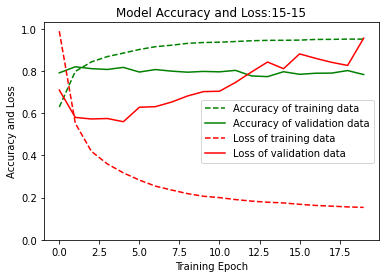


--- Check against test data ---

6584/6584 [==============================] - 0s 59us/step

Accuracy on test data: 0.86

Loss on test data: 0.54

--- Confusion matrix for test data ---



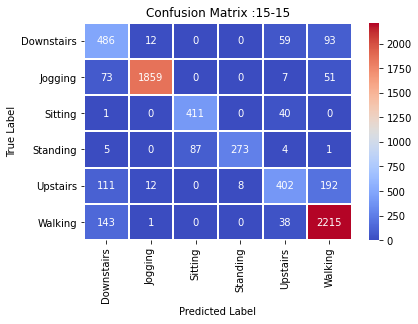


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.59      0.75      0.66       650
           1       0.99      0.93      0.96      1990
           2       0.83      0.91      0.87       452
           3       0.97      0.74      0.84       370
           4       0.73      0.55      0.63       725
           5       0.87      0.92      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 150us/step - loss: 0.9630 - accuracy: 0.6428 - val_loss: 0.7346 - val_accuracy: 0.7599
Epoch 2/25
16694/16694 [==============================] - 2s 107us/step - loss: 0.5434 - accuracy: 0.8057 - val_loss: 0.5969 - val_accuracy: 0.8220
Epoch 3/25
16694/16694 [==============================] - 2s 

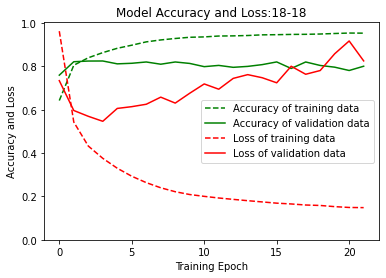


--- Check against test data ---

6584/6584 [==============================] - 0s 68us/step

Accuracy on test data: 0.86

Loss on test data: 0.57

--- Confusion matrix for test data ---



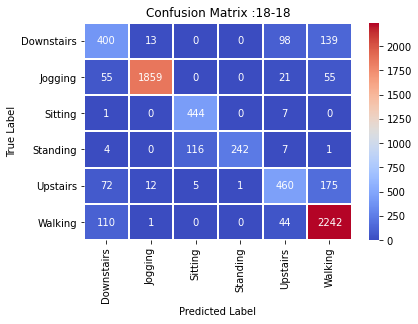


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       650
           1       0.99      0.93      0.96      1990
           2       0.79      0.98      0.87       452
           3       1.00      0.65      0.79       370
           4       0.72      0.63      0.68       725
           5       0.86      0.94      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.79      0.80      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 109us/step - loss: 0.8867 - accuracy: 0.6785 - val_loss: 0.6825 - val_accuracy: 0.7798
Epoch 2/25
16694/16694 [==============================] - 1s 71us/step - loss: 0.5253 - accuracy: 0.8081 - val_loss: 0.5924 - val_accuracy: 0.8050
Epoch 3/25
16694/16694 [==============================] - 1s 7

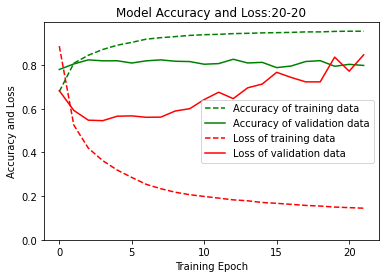


--- Check against test data ---

6584/6584 [==============================] - 0s 66us/step

Accuracy on test data: 0.85

Loss on test data: 0.55

--- Confusion matrix for test data ---



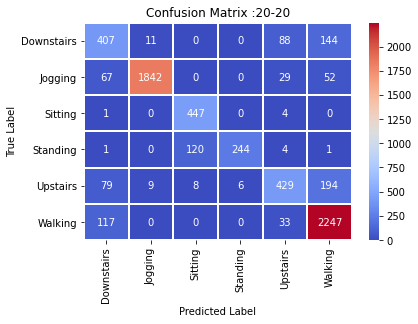


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.61      0.63      0.62       650
           1       0.99      0.93      0.96      1990
           2       0.78      0.99      0.87       452
           3       0.98      0.66      0.79       370
           4       0.73      0.59      0.65       725
           5       0.85      0.94      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.79      0.80      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 100us/step - loss: 0.9157 - accuracy: 0.6629 - val_loss: 0.7088 - val_accuracy: 0.7971
Epoch 2/25
16694/16694 [==============================] - 1s 82us/step - loss: 0.6003 - accuracy: 0.7984 - val_loss: 0.6449 - val_accuracy: 0.7973
Epoch 3/25
16694/16694 [==============================] - 1s 7

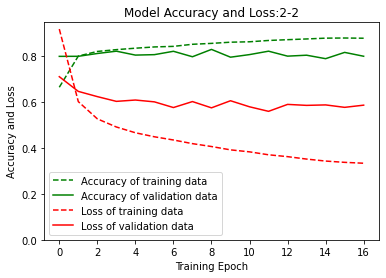


--- Check against test data ---

6584/6584 [==============================] - 0s 73us/step

Accuracy on test data: 0.77

Loss on test data: 0.94

--- Confusion matrix for test data ---



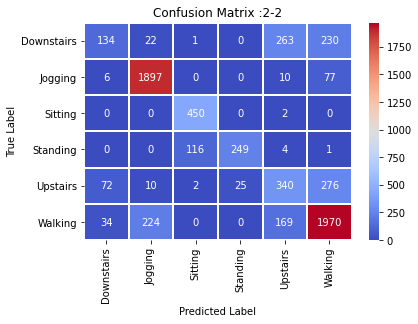


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.54      0.21      0.30       650
           1       0.88      0.95      0.92      1990
           2       0.79      1.00      0.88       452
           3       0.91      0.67      0.77       370
           4       0.43      0.47      0.45       725
           5       0.77      0.82      0.80      2397

    accuracy                           0.77      6584
   macro avg       0.72      0.69      0.69      6584
weighted avg       0.75      0.77      0.75      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 100us/step - loss: 0.9513 - accuracy: 0.6575 - val_loss: 0.6895 - val_accuracy: 0.8062
Epoch 2/25
16694/16694 [==============================] - 1s 76us/step - loss: 0.5770 - accuracy: 0.7946 - val_loss: 0.6193 - val_accuracy: 0.8122
Epoch 3/25
16694/16694 [==============================] - 1s 76u

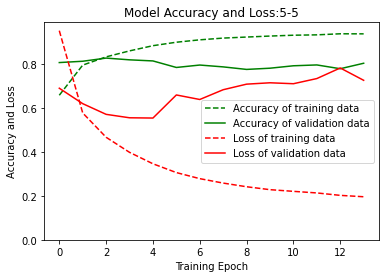


--- Check against test data ---

6584/6584 [==============================] - 0s 70us/step

Accuracy on test data: 0.82

Loss on test data: 0.66

--- Confusion matrix for test data ---



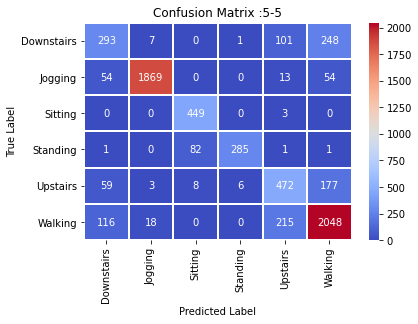


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.56      0.45      0.50       650
           1       0.99      0.94      0.96      1990
           2       0.83      0.99      0.91       452
           3       0.98      0.77      0.86       370
           4       0.59      0.65      0.62       725
           5       0.81      0.85      0.83      2397

    accuracy                           0.82      6584
   macro avg       0.79      0.78      0.78      6584
weighted avg       0.82      0.82      0.82      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 101us/step - loss: 0.8343 - accuracy: 0.7023 - val_loss: 0.6497 - val_accuracy: 0.8055
Epoch 2/25
16694/16694 [==============================] - 1s 71us/step - loss: 0.4934 - accuracy: 0.8228 - val_loss: 0.5509 - val_accuracy: 0.8210
Epoch 3/25
16694/16694 [==============================] - 1s 71u

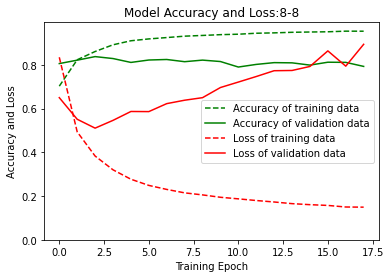


--- Check against test data ---

6584/6584 [==============================] - 0s 65us/step

Accuracy on test data: 0.82

Loss on test data: 0.63

--- Confusion matrix for test data ---



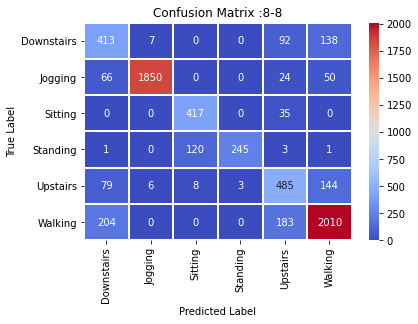


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.54      0.64      0.58       650
           1       0.99      0.93      0.96      1990
           2       0.77      0.92      0.84       452
           3       0.99      0.66      0.79       370
           4       0.59      0.67      0.63       725
           5       0.86      0.84      0.85      2397

    accuracy                           0.82      6584
   macro avg       0.79      0.78      0.77      6584
weighted avg       0.84      0.82      0.83      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 93us/step - loss: 0.8620 - accuracy: 0.6885 - val_loss: 0.6379 - val_accuracy: 0.8007
Epoch 2/25
16694/16694 [==============================] - 1s 69us/step - loss: 0.4906 - accuracy: 0.8217 - val_loss: 0.5278 - val_accuracy: 0.8297
Epoch 3/25
16694/16694 [==============================] - 1s 86us

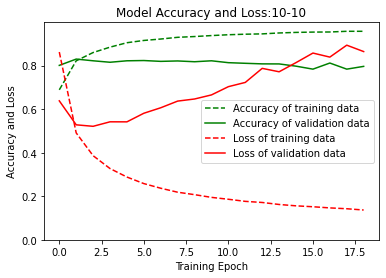


--- Check against test data ---

6584/6584 [==============================] - 0s 69us/step

Accuracy on test data: 0.84

Loss on test data: 0.57

--- Confusion matrix for test data ---



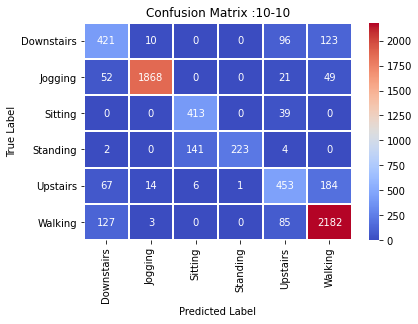


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       650
           1       0.99      0.94      0.96      1990
           2       0.74      0.91      0.82       452
           3       1.00      0.60      0.75       370
           4       0.65      0.62      0.64       725
           5       0.86      0.91      0.88      2397

    accuracy                           0.84      6584
   macro avg       0.81      0.77      0.78      6584
weighted avg       0.85      0.84      0.84      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 106us/step - loss: 0.8732 - accuracy: 0.6843 - val_loss: 0.6615 - val_accuracy: 0.7947
Epoch 2/25
16694/16694 [==============================] - 1s 85us/step - loss: 0.4816 - accuracy: 0.8255 - val_loss: 0.5440 - val_accuracy: 0.8287
Epoch 3/25
16694/16694 [==============================] - 1s 8

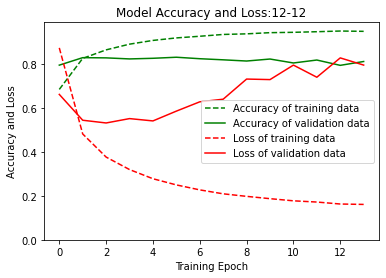


--- Check against test data ---

6584/6584 [==============================] - 0s 40us/step

Accuracy on test data: 0.85

Loss on test data: 0.55

--- Confusion matrix for test data ---



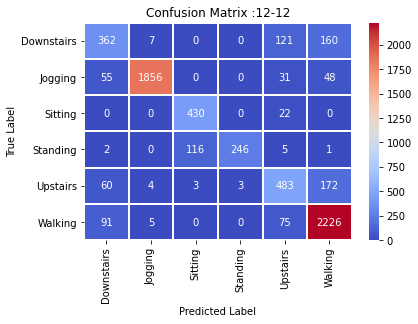


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.64      0.56      0.59       650
           1       0.99      0.93      0.96      1990
           2       0.78      0.95      0.86       452
           3       0.99      0.66      0.79       370
           4       0.66      0.67      0.66       725
           5       0.85      0.93      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.78      0.79      6584
weighted avg       0.85      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 117us/step - loss: 0.8677 - accuracy: 0.6791 - val_loss: 0.6495 - val_accuracy: 0.7971
Epoch 2/25
16694/16694 [==============================] - 2s 98us/step - loss: 0.4774 - accuracy: 0.8270 - val_loss: 0.5268 - val_accuracy: 0.8292
Epoch 3/25
16694/16694 [==============================] - 2s 9

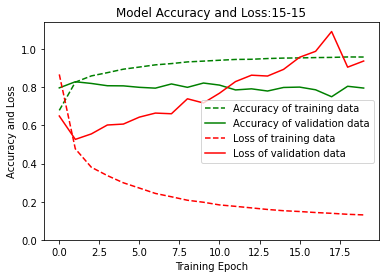


--- Check against test data ---

6584/6584 [==============================] - 0s 65us/step

Accuracy on test data: 0.85

Loss on test data: 0.55

--- Confusion matrix for test data ---



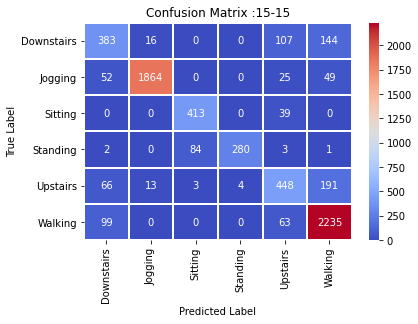


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.64      0.59      0.61       650
           1       0.98      0.94      0.96      1990
           2       0.83      0.91      0.87       452
           3       0.99      0.76      0.86       370
           4       0.65      0.62      0.64       725
           5       0.85      0.93      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.79      0.80      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 123us/step - loss: 0.8491 - accuracy: 0.6898 - val_loss: 0.6505 - val_accuracy: 0.7897
Epoch 2/25
16694/16694 [==============================] - 2s 101us/step - loss: 0.4746 - accuracy: 0.8287 - val_loss: 0.5805 - val_accuracy: 0.8138
Epoch 3/25
16694/16694 [==============================] - 2s 

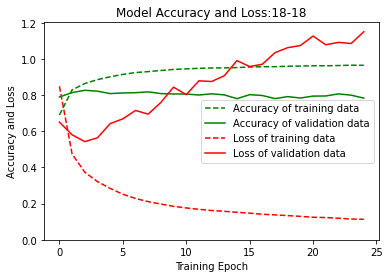


--- Check against test data ---

6584/6584 [==============================] - 0s 67us/step

Accuracy on test data: 0.85

Loss on test data: 0.59

--- Confusion matrix for test data ---



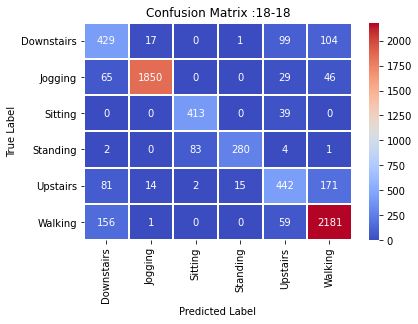


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.59      0.66      0.62       650
           1       0.98      0.93      0.96      1990
           2       0.83      0.91      0.87       452
           3       0.95      0.76      0.84       370
           4       0.66      0.61      0.63       725
           5       0.87      0.91      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.81      0.80      0.80      6584
weighted avg       0.85      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 111us/step - loss: 0.8985 - accuracy: 0.6651 - val_loss: 0.6812 - val_accuracy: 0.7863
Epoch 2/25
16694/16694 [==============================] - 1s 86us/step - loss: 0.4829 - accuracy: 0.8254 - val_loss: 0.5718 - val_accuracy: 0.8160
Epoch 3/25
16694/16694 [==============================] - 1s 8

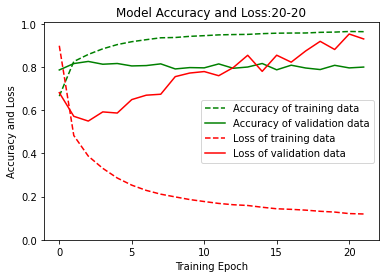


--- Check against test data ---

6584/6584 [==============================] - 1s 79us/step

Accuracy on test data: 0.86

Loss on test data: 0.55

--- Confusion matrix for test data ---



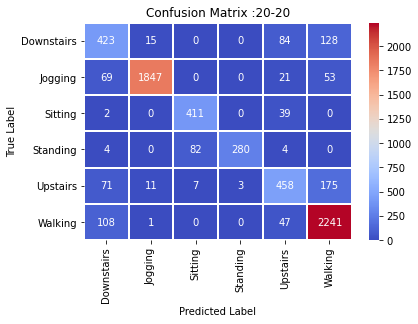


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.62      0.65      0.64       650
           1       0.99      0.93      0.96      1990
           2       0.82      0.91      0.86       452
           3       0.99      0.76      0.86       370
           4       0.70      0.63      0.66       725
           5       0.86      0.93      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 96us/step - loss: 0.9631 - accuracy: 0.6511 - val_loss: 0.7563 - val_accuracy: 0.7770
Epoch 2/25
16694/16694 [==============================] - 1s 72us/step - loss: 0.6237 - accuracy: 0.7854 - val_loss: 0.6718 - val_accuracy: 0.7930
Epoch 3/25
16694/16694 [==============================] - 1s 75

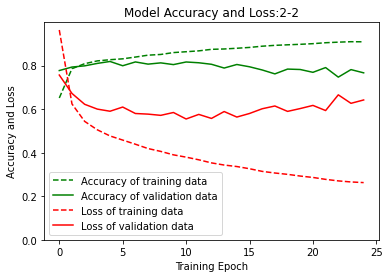


--- Check against test data ---

6584/6584 [==============================] - 0s 69us/step

Accuracy on test data: 0.79

Loss on test data: 1.00

--- Confusion matrix for test data ---



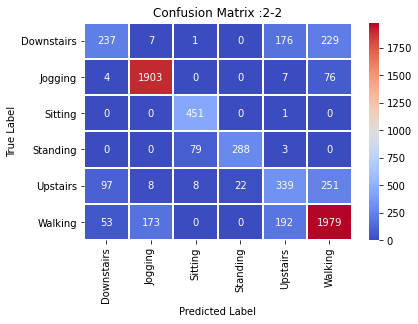


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.61      0.36      0.46       650
           1       0.91      0.96      0.93      1990
           2       0.84      1.00      0.91       452
           3       0.93      0.78      0.85       370
           4       0.47      0.47      0.47       725
           5       0.78      0.83      0.80      2397

    accuracy                           0.79      6584
   macro avg       0.76      0.73      0.74      6584
weighted avg       0.78      0.79      0.78      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 1s 74us/step - loss: 0.8698 - accuracy: 0.6831 - val_loss: 0.6750 - val_accuracy: 0.8095
Epoch 2/25
16694/16694 [==============================] - 1s 79us/step - loss: 0.5121 - accuracy: 0.8226 - val_loss: 0.5617 - val_accuracy: 0.8179
Epoch 3/25
16694/16694 [==============================] - 1s 81us

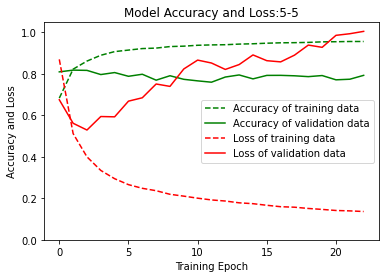


--- Check against test data ---

6584/6584 [==============================] - 0s 67us/step

Accuracy on test data: 0.83

Loss on test data: 0.65

--- Confusion matrix for test data ---



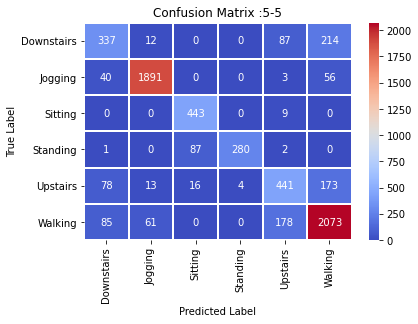


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.62      0.52      0.57       650
           1       0.96      0.95      0.95      1990
           2       0.81      0.98      0.89       452
           3       0.99      0.76      0.86       370
           4       0.61      0.61      0.61       725
           5       0.82      0.86      0.84      2397

    accuracy                           0.83      6584
   macro avg       0.80      0.78      0.79      6584
weighted avg       0.83      0.83      0.83      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 100us/step - loss: 0.8750 - accuracy: 0.6815 - val_loss: 0.7230 - val_accuracy: 0.7880
Epoch 2/25
16694/16694 [==============================] - 1s 82us/step - loss: 0.5172 - accuracy: 0.8216 - val_loss: 0.5949 - val_accuracy: 0.8167
Epoch 3/25
16694/16694 [==============================] - 1s 85u

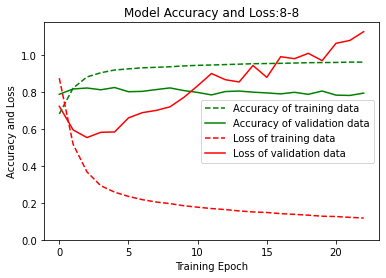


--- Check against test data ---

6584/6584 [==============================] - 0s 70us/step

Accuracy on test data: 0.85

Loss on test data: 0.57

--- Confusion matrix for test data ---



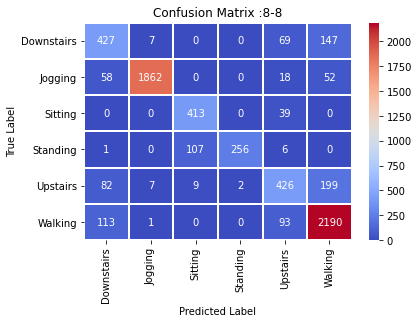


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.63      0.66      0.64       650
           1       0.99      0.94      0.96      1990
           2       0.78      0.91      0.84       452
           3       0.99      0.69      0.82       370
           4       0.65      0.59      0.62       725
           5       0.85      0.91      0.88      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.78      0.79      6584
weighted avg       0.85      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 112us/step - loss: 0.8568 - accuracy: 0.6888 - val_loss: 0.6525 - val_accuracy: 0.7964
Epoch 2/25
16694/16694 [==============================] - 2s 94us/step - loss: 0.4637 - accuracy: 0.8317 - val_loss: 0.5396 - val_accuracy: 0.8198
Epoch 3/25
16694/16694 [==============================] - 2s 100

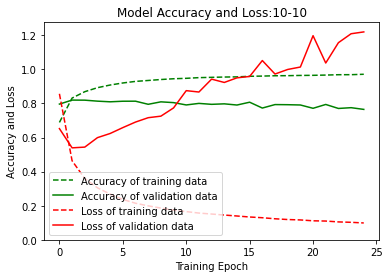


--- Check against test data ---

6584/6584 [==============================] - 0s 70us/step

Accuracy on test data: 0.85

Loss on test data: 0.58

--- Confusion matrix for test data ---



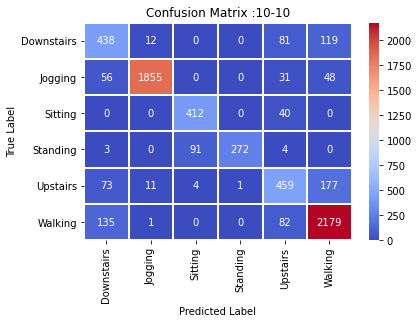


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.62      0.67      0.65       650
           1       0.99      0.93      0.96      1990
           2       0.81      0.91      0.86       452
           3       1.00      0.74      0.85       370
           4       0.66      0.63      0.65       725
           5       0.86      0.91      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.80      0.81      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 115us/step - loss: 0.8458 - accuracy: 0.6909 - val_loss: 0.6298 - val_accuracy: 0.7935
Epoch 2/25
16694/16694 [==============================] - 1s 89us/step - loss: 0.4498 - accuracy: 0.8386 - val_loss: 0.5235 - val_accuracy: 0.8277
Epoch 3/25
16694/16694 [==============================] - 1s 8

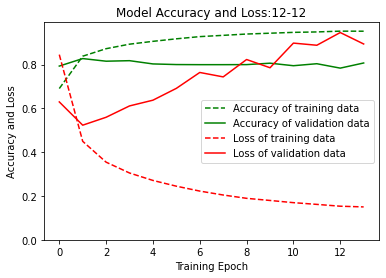


--- Check against test data ---

6584/6584 [==============================] - 0s 69us/step

Accuracy on test data: 0.85

Loss on test data: 0.57

--- Confusion matrix for test data ---



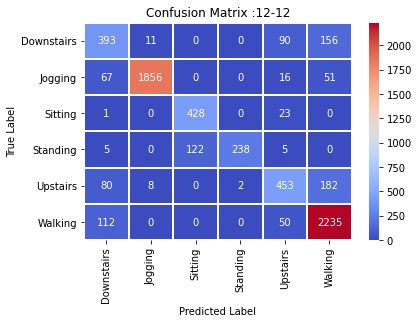


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.60      0.60      0.60       650
           1       0.99      0.93      0.96      1990
           2       0.78      0.95      0.85       452
           3       0.99      0.64      0.78       370
           4       0.71      0.62      0.67       725
           5       0.85      0.93      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.78      0.79      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 115us/step - loss: 0.8063 - accuracy: 0.7007 - val_loss: 0.6420 - val_accuracy: 0.7786
Epoch 2/25
16694/16694 [==============================] - 2s 99us/step - loss: 0.4307 - accuracy: 0.8432 - val_loss: 0.5516 - val_accuracy: 0.8184
Epoch 3/25
16694/16694 [==============================] - 2s 1

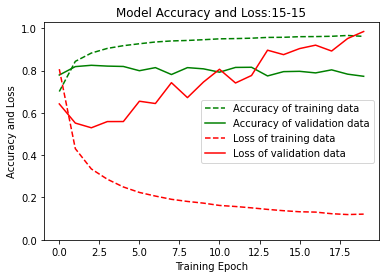


--- Check against test data ---

6584/6584 [==============================] - 0s 38us/step

Accuracy on test data: 0.85

Loss on test data: 0.59

--- Confusion matrix for test data ---



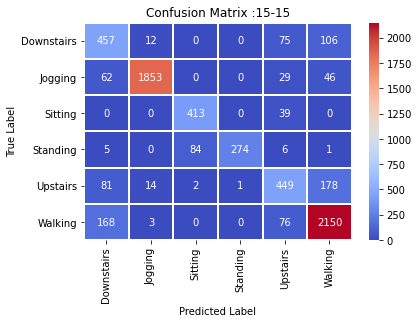


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.59      0.70      0.64       650
           1       0.98      0.93      0.96      1990
           2       0.83      0.91      0.87       452
           3       1.00      0.74      0.85       370
           4       0.67      0.62      0.64       725
           5       0.87      0.90      0.88      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.80      0.81      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 114us/step - loss: 0.7984 - accuracy: 0.7097 - val_loss: 0.6476 - val_accuracy: 0.7863
Epoch 2/25
16694/16694 [==============================] - 2s 106us/step - loss: 0.4486 - accuracy: 0.8328 - val_loss: 0.5563 - val_accuracy: 0.8138
Epoch 3/25
16694/16694 [==============================] - 2s 

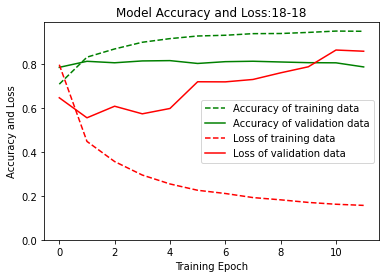


--- Check against test data ---

6584/6584 [==============================] - 0s 76us/step

Accuracy on test data: 0.85

Loss on test data: 0.56

--- Confusion matrix for test data ---



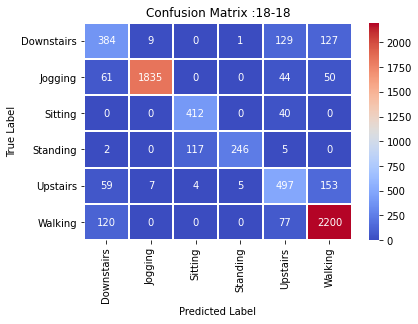


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.61      0.59      0.60       650
           1       0.99      0.92      0.96      1990
           2       0.77      0.91      0.84       452
           3       0.98      0.66      0.79       370
           4       0.63      0.69      0.66       725
           5       0.87      0.92      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.81      0.78      0.79      6584
weighted avg       0.85      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 125us/step - loss: 0.7631 - accuracy: 0.7207 - val_loss: 0.6105 - val_accuracy: 0.7851
Epoch 2/25
16694/16694 [==============================] - 2s 108us/step - loss: 0.4229 - accuracy: 0.8399 - val_loss: 0.5717 - val_accuracy: 0.8105
Epoch 3/25
16694/16694 [==============================] - 2s 

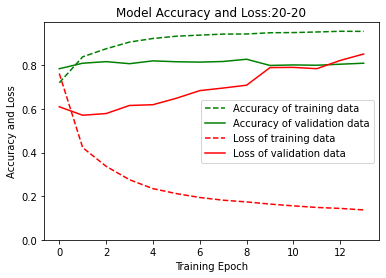


--- Check against test data ---

6584/6584 [==============================] - 1s 81us/step

Accuracy on test data: 0.86

Loss on test data: 0.55

--- Confusion matrix for test data ---



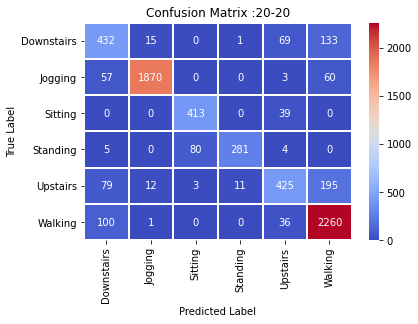


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.64      0.66      0.65       650
           1       0.99      0.94      0.96      1990
           2       0.83      0.91      0.87       452
           3       0.96      0.76      0.85       370
           4       0.74      0.59      0.65       725
           5       0.85      0.94      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 110us/step - loss: 0.9116 - accuracy: 0.6693 - val_loss: 0.7134 - val_accuracy: 0.8126
Epoch 2/25
16694/16694 [==============================] - 1s 83us/step - loss: 0.6002 - accuracy: 0.7936 - val_loss: 0.6410 - val_accuracy: 0.7971
Epoch 3/25
16694/16694 [==============================] - 1s 8

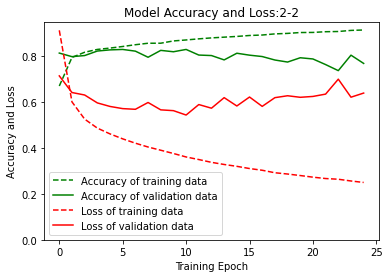


--- Check against test data ---

6584/6584 [==============================] - 0s 56us/step

Accuracy on test data: 0.79

Loss on test data: 1.09

--- Confusion matrix for test data ---



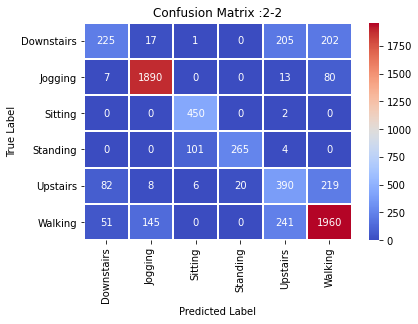


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.62      0.35      0.44       650
           1       0.92      0.95      0.93      1990
           2       0.81      1.00      0.89       452
           3       0.93      0.72      0.81       370
           4       0.46      0.54      0.49       725
           5       0.80      0.82      0.81      2397

    accuracy                           0.79      6584
   macro avg       0.75      0.73      0.73      6584
weighted avg       0.79      0.79      0.78      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 114us/step - loss: 0.8015 - accuracy: 0.7135 - val_loss: 0.6230 - val_accuracy: 0.8186
Epoch 2/25
16694/16694 [==============================] - 2s 95us/step - loss: 0.4877 - accuracy: 0.8245 - val_loss: 0.5487 - val_accuracy: 0.8345
Epoch 3/25
16694/16694 [==============================] - 2s 94u

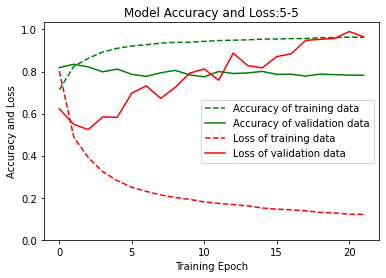


--- Check against test data ---

6584/6584 [==============================] - 0s 74us/step

Accuracy on test data: 0.82

Loss on test data: 0.81

--- Confusion matrix for test data ---



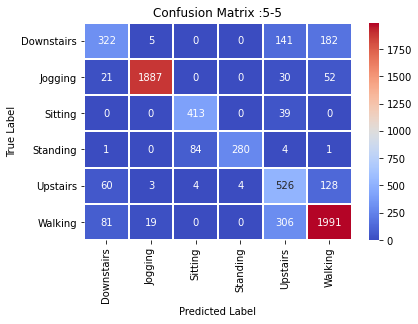


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.66      0.50      0.57       650
           1       0.99      0.95      0.97      1990
           2       0.82      0.91      0.87       452
           3       0.99      0.76      0.86       370
           4       0.50      0.73      0.59       725
           5       0.85      0.83      0.84      2397

    accuracy                           0.82      6584
   macro avg       0.80      0.78      0.78      6584
weighted avg       0.84      0.82      0.83      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 115us/step - loss: 0.8597 - accuracy: 0.6811 - val_loss: 0.6446 - val_accuracy: 0.8035
Epoch 2/25
16694/16694 [==============================] - 1s 89us/step - loss: 0.4704 - accuracy: 0.8253 - val_loss: 0.5445 - val_accuracy: 0.8241
Epoch 3/25
16694/16694 [==============================] - 2s 93u

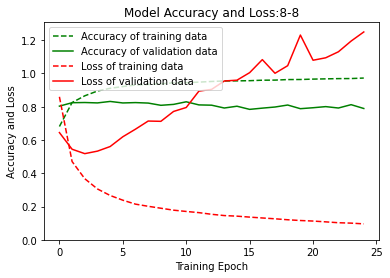


--- Check against test data ---

6584/6584 [==============================] - 0s 76us/step

Accuracy on test data: 0.85

Loss on test data: 0.57

--- Confusion matrix for test data ---



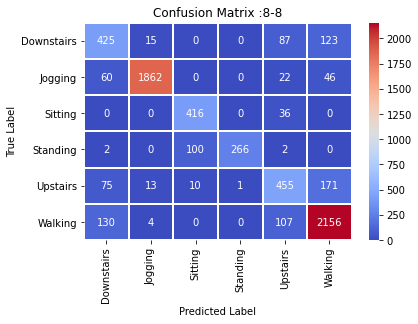


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.61      0.65      0.63       650
           1       0.98      0.94      0.96      1990
           2       0.79      0.92      0.85       452
           3       1.00      0.72      0.84       370
           4       0.64      0.63      0.63       725
           5       0.86      0.90      0.88      2397

    accuracy                           0.85      6584
   macro avg       0.81      0.79      0.80      6584
weighted avg       0.85      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 128us/step - loss: 0.7926 - accuracy: 0.7095 - val_loss: 0.6089 - val_accuracy: 0.8059
Epoch 2/25
16694/16694 [==============================] - 2s 106us/step - loss: 0.4156 - accuracy: 0.8515 - val_loss: 0.5173 - val_accuracy: 0.8289
Epoch 3/25
16694/16694 [==============================] - 2s 11

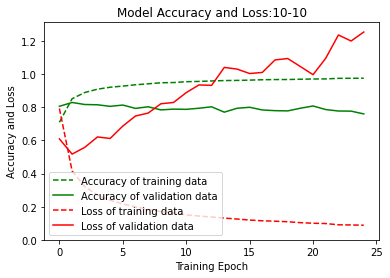


--- Check against test data ---

6584/6584 [==============================] - 0s 59us/step

Accuracy on test data: 0.87

Loss on test data: 0.55

--- Confusion matrix for test data ---



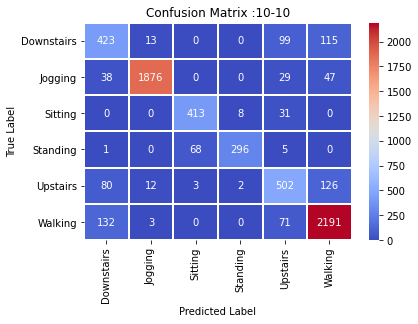


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       650
           1       0.99      0.94      0.96      1990
           2       0.85      0.91      0.88       452
           3       0.97      0.80      0.88       370
           4       0.68      0.69      0.69       725
           5       0.88      0.91      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.83      0.82      0.82      6584
weighted avg       0.87      0.87      0.87      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 115us/step - loss: 0.7463 - accuracy: 0.7233 - val_loss: 0.6064 - val_accuracy: 0.8086
Epoch 2/25
16694/16694 [==============================] - 2s 104us/step - loss: 0.4040 - accuracy: 0.8526 - val_loss: 0.5249 - val_accuracy: 0.8280
Epoch 3/25
16694/16694 [==============================] - 2s 

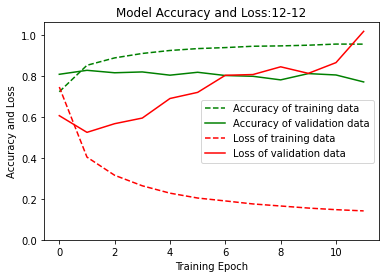


--- Check against test data ---

6584/6584 [==============================] - 0s 69us/step

Accuracy on test data: 0.85

Loss on test data: 0.54

--- Confusion matrix for test data ---



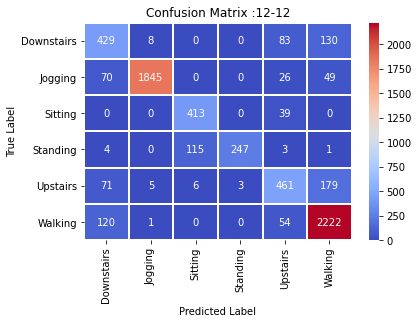


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.62      0.66      0.64       650
           1       0.99      0.93      0.96      1990
           2       0.77      0.91      0.84       452
           3       0.99      0.67      0.80       370
           4       0.69      0.64      0.66       725
           5       0.86      0.93      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.79      0.80      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 138us/step - loss: 0.7397 - accuracy: 0.7291 - val_loss: 0.5802 - val_accuracy: 0.8189
Epoch 2/25
16694/16694 [==============================] - 2s 115us/step - loss: 0.3929 - accuracy: 0.8580 - val_loss: 0.5492 - val_accuracy: 0.8122
Epoch 3/25
16694/16694 [==============================] - 2s 

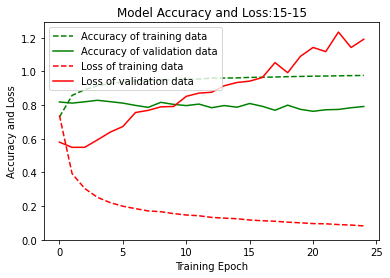


--- Check against test data ---

6584/6584 [==============================] - 0s 73us/step

Accuracy on test data: 0.85

Loss on test data: 0.66

--- Confusion matrix for test data ---



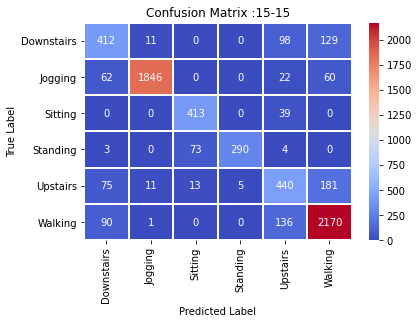


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.64      0.63      0.64       650
           1       0.99      0.93      0.96      1990
           2       0.83      0.91      0.87       452
           3       0.98      0.78      0.87       370
           4       0.60      0.61      0.60       725
           5       0.85      0.91      0.88      2397

    accuracy                           0.85      6584
   macro avg       0.81      0.80      0.80      6584
weighted avg       0.85      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 141us/step - loss: 0.7707 - accuracy: 0.7233 - val_loss: 0.5584 - val_accuracy: 0.8294
Epoch 2/25
16694/16694 [==============================] - 2s 121us/step - loss: 0.4165 - accuracy: 0.8458 - val_loss: 0.5246 - val_accuracy: 0.8241
Epoch 3/25
16694/16694 [==============================] - 2s 

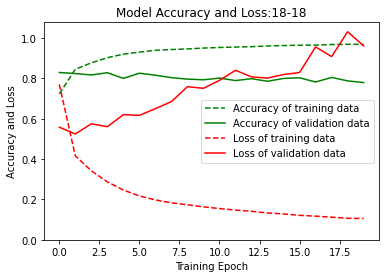


--- Check against test data ---

6584/6584 [==============================] - 0s 68us/step

Accuracy on test data: 0.85

Loss on test data: 0.57

--- Confusion matrix for test data ---



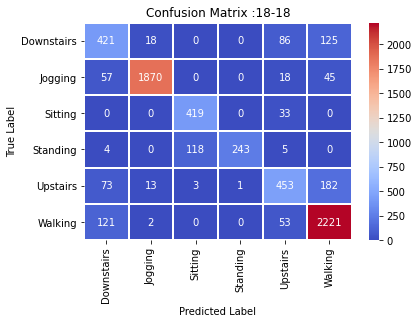


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.62      0.65      0.63       650
           1       0.98      0.94      0.96      1990
           2       0.78      0.93      0.84       452
           3       1.00      0.66      0.79       370
           4       0.70      0.62      0.66       725
           5       0.86      0.93      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.79      0.80      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 140us/step - loss: 0.7853 - accuracy: 0.7139 - val_loss: 0.6175 - val_accuracy: 0.8047
Epoch 2/25
16694/16694 [==============================] - 2s 119us/step - loss: 0.4218 - accuracy: 0.8484 - val_loss: 0.5398 - val_accuracy: 0.8117
Epoch 3/25
16694/16694 [==============================] - 2s 

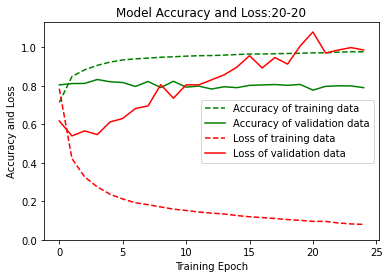


--- Check against test data ---

6584/6584 [==============================] - 0s 74us/step

Accuracy on test data: 0.85

Loss on test data: 0.61

--- Confusion matrix for test data ---



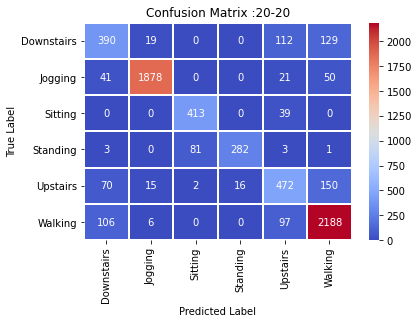


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.64      0.60      0.62       650
           1       0.98      0.94      0.96      1990
           2       0.83      0.91      0.87       452
           3       0.95      0.76      0.84       370
           4       0.63      0.65      0.64       725
           5       0.87      0.91      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.80      0.80      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 122us/step - loss: 0.8516 - accuracy: 0.7003 - val_loss: 0.6909 - val_accuracy: 0.8028
Epoch 2/25
16694/16694 [==============================] - 2s 99us/step - loss: 0.5618 - accuracy: 0.8101 - val_loss: 0.6406 - val_accuracy: 0.7971
Epoch 3/25
16694/16694 [==============================] - 2s 1

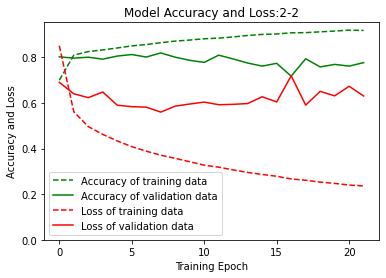


--- Check against test data ---

6584/6584 [==============================] - 1s 85us/step

Accuracy on test data: 0.80

Loss on test data: 1.09

--- Confusion matrix for test data ---



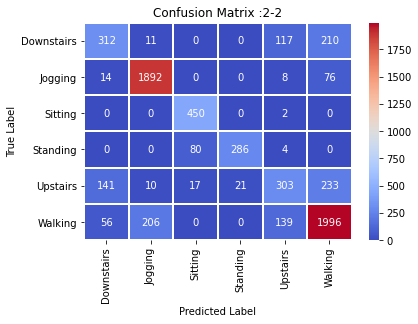


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.60      0.48      0.53       650
           1       0.89      0.95      0.92      1990
           2       0.82      1.00      0.90       452
           3       0.93      0.77      0.84       370
           4       0.53      0.42      0.47       725
           5       0.79      0.83      0.81      2397

    accuracy                           0.80      6584
   macro avg       0.76      0.74      0.75      6584
weighted avg       0.78      0.80      0.79      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 131us/step - loss: 0.8105 - accuracy: 0.7108 - val_loss: 0.6447 - val_accuracy: 0.8052
Epoch 2/25
16694/16694 [==============================] - 2s 109us/step - loss: 0.4758 - accuracy: 0.8299 - val_loss: 0.5831 - val_accuracy: 0.8074
Epoch 3/25
16694/16694 [==============================] - 2s 11

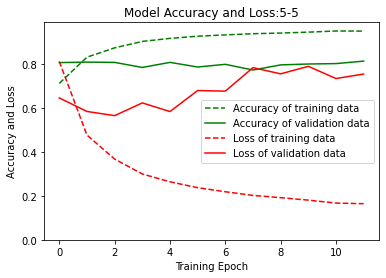


--- Check against test data ---

6584/6584 [==============================] - 0s 72us/step

Accuracy on test data: 0.81

Loss on test data: 0.74

--- Confusion matrix for test data ---



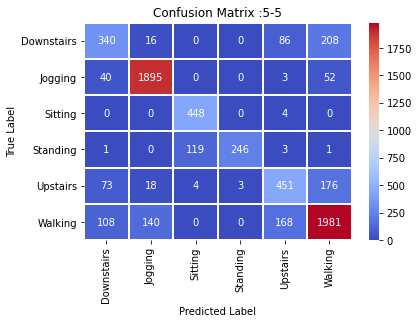


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.60      0.52      0.56       650
           1       0.92      0.95      0.93      1990
           2       0.78      0.99      0.88       452
           3       0.99      0.66      0.79       370
           4       0.63      0.62      0.63       725
           5       0.82      0.83      0.82      2397

    accuracy                           0.81      6584
   macro avg       0.79      0.76      0.77      6584
weighted avg       0.81      0.81      0.81      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 123us/step - loss: 0.7360 - accuracy: 0.7327 - val_loss: 0.6041 - val_accuracy: 0.8000
Epoch 2/25
16694/16694 [==============================] - 2s 106us/step - loss: 0.3986 - accuracy: 0.8601 - val_loss: 0.5108 - val_accuracy: 0.8265
Epoch 3/25
16694/16694 [==============================] - 2s 10

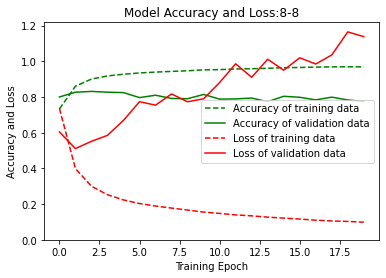


--- Check against test data ---

6584/6584 [==============================] - 0s 66us/step

Accuracy on test data: 0.86

Loss on test data: 0.56

--- Confusion matrix for test data ---



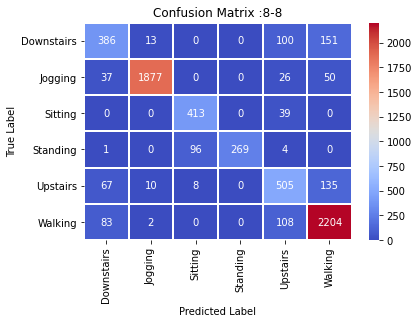


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       650
           1       0.99      0.94      0.96      1990
           2       0.80      0.91      0.85       452
           3       1.00      0.73      0.84       370
           4       0.65      0.70      0.67       725
           5       0.87      0.92      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 142us/step - loss: 0.7316 - accuracy: 0.7300 - val_loss: 0.6099 - val_accuracy: 0.8007
Epoch 2/25
16694/16694 [==============================] - 2s 118us/step - loss: 0.3808 - accuracy: 0.8653 - val_loss: 0.5165 - val_accuracy: 0.8292
Epoch 3/25
16694/16694 [==============================] - 2s 11

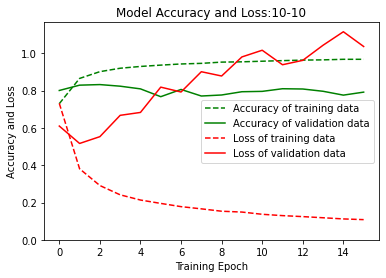


--- Check against test data ---

6584/6584 [==============================] - 1s 83us/step

Accuracy on test data: 0.85

Loss on test data: 0.55

--- Confusion matrix for test data ---



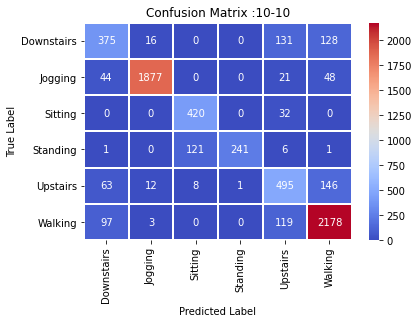


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.65      0.58      0.61       650
           1       0.98      0.94      0.96      1990
           2       0.77      0.93      0.84       452
           3       1.00      0.65      0.79       370
           4       0.62      0.68      0.65       725
           5       0.87      0.91      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.81      0.78      0.79      6584
weighted avg       0.85      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 139us/step - loss: 0.7306 - accuracy: 0.7317 - val_loss: 0.5648 - val_accuracy: 0.8208
Epoch 2/25
16694/16694 [==============================] - 2s 128us/step - loss: 0.3855 - accuracy: 0.8607 - val_loss: 0.5507 - val_accuracy: 0.8249
Epoch 3/25
16694/16694 [==============================] - 2s 

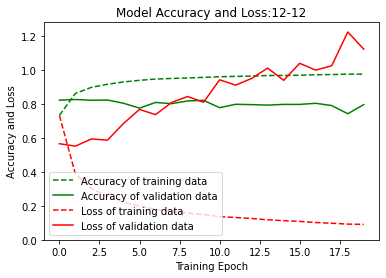


--- Check against test data ---

6584/6584 [==============================] - 0s 71us/step

Accuracy on test data: 0.86

Loss on test data: 0.61

--- Confusion matrix for test data ---



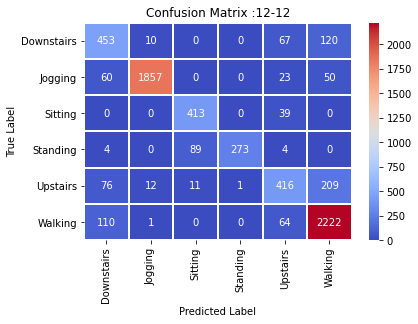


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.64      0.70      0.67       650
           1       0.99      0.93      0.96      1990
           2       0.81      0.91      0.86       452
           3       1.00      0.74      0.85       370
           4       0.68      0.57      0.62       725
           5       0.85      0.93      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.81      6584
weighted avg       0.86      0.86      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 102us/step - loss: 0.7554 - accuracy: 0.7262 - val_loss: 0.5541 - val_accuracy: 0.8198
Epoch 2/25
16694/16694 [==============================] - 2s 122us/step - loss: 0.3909 - accuracy: 0.8545 - val_loss: 0.5487 - val_accuracy: 0.8136
Epoch 3/25
16694/16694 [==============================] - 2s 

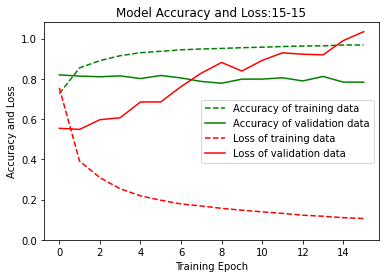


--- Check against test data ---

6584/6584 [==============================] - 1s 77us/step

Accuracy on test data: 0.85

Loss on test data: 0.59

--- Confusion matrix for test data ---



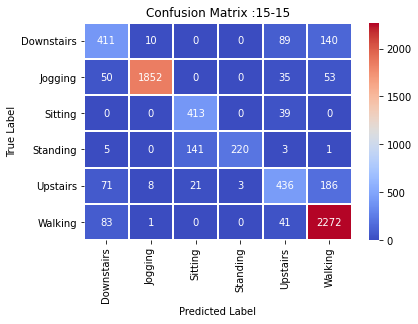


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.66      0.63      0.65       650
           1       0.99      0.93      0.96      1990
           2       0.72      0.91      0.80       452
           3       0.99      0.59      0.74       370
           4       0.68      0.60      0.64       725
           5       0.86      0.95      0.90      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.77      0.78      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 140us/step - loss: 0.7614 - accuracy: 0.7182 - val_loss: 0.6167 - val_accuracy: 0.8076
Epoch 2/25
16694/16694 [==============================] - 2s 103us/step - loss: 0.3928 - accuracy: 0.8576 - val_loss: 0.5522 - val_accuracy: 0.8270
Epoch 3/25
16694/16694 [==============================] - 2s 

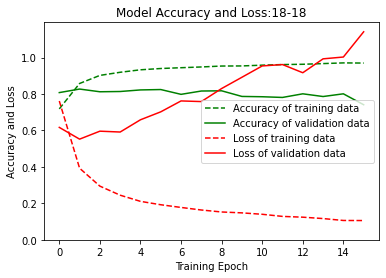


--- Check against test data ---

6584/6584 [==============================] - 1s 76us/step

Accuracy on test data: 0.85

Loss on test data: 0.53

--- Confusion matrix for test data ---



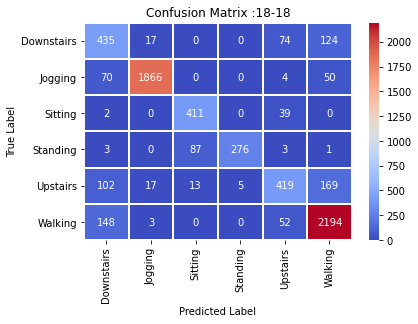


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.57      0.67      0.62       650
           1       0.98      0.94      0.96      1990
           2       0.80      0.91      0.85       452
           3       0.98      0.75      0.85       370
           4       0.71      0.58      0.64       725
           5       0.86      0.92      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.79      0.80      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 156us/step - loss: 0.7513 - accuracy: 0.7280 - val_loss: 0.6104 - val_accuracy: 0.8052
Epoch 2/25
16694/16694 [==============================] - 2s 136us/step - loss: 0.3988 - accuracy: 0.8547 - val_loss: 0.5443 - val_accuracy: 0.8234
Epoch 3/25
16694/16694 [==============================] - 2s 

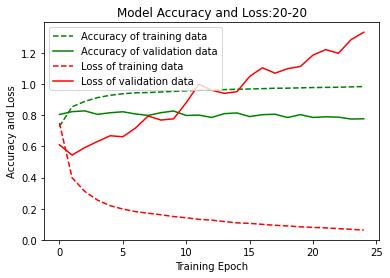


--- Check against test data ---

6584/6584 [==============================] - 1s 83us/step

Accuracy on test data: 0.85

Loss on test data: 0.65

--- Confusion matrix for test data ---



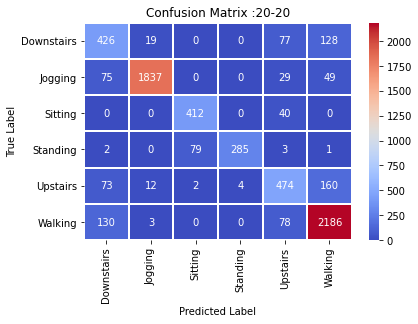


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.60      0.66      0.63       650
           1       0.98      0.92      0.95      1990
           2       0.84      0.91      0.87       452
           3       0.99      0.77      0.86       370
           4       0.68      0.65      0.66       725
           5       0.87      0.91      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.80      0.81      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 2s 140us/step - loss: 0.8188 - accuracy: 0.7091 - val_loss: 0.6740 - val_accuracy: 0.8091
Epoch 2/25
16694/16694 [==============================] - 2s 127us/step - loss: 0.5471 - accuracy: 0.8110 - val_loss: 0.6407 - val_accuracy: 0.7887
Epoch 3/25
16694/16694 [==============================] - 2s 

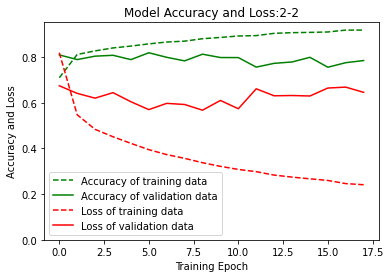


--- Check against test data ---

6584/6584 [==============================] - 1s 77us/step

Accuracy on test data: 0.79

Loss on test data: 1.04

--- Confusion matrix for test data ---



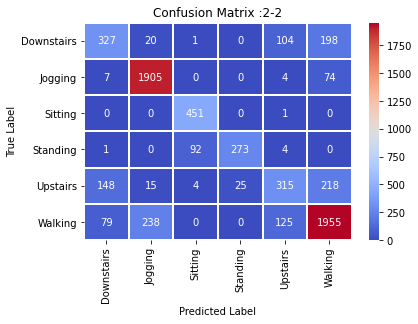


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.58      0.50      0.54       650
           1       0.87      0.96      0.91      1990
           2       0.82      1.00      0.90       452
           3       0.92      0.74      0.82       370
           4       0.57      0.43      0.49       725
           5       0.80      0.82      0.81      2397

    accuracy                           0.79      6584
   macro avg       0.76      0.74      0.75      6584
weighted avg       0.78      0.79      0.79      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 157us/step - loss: 0.7599 - accuracy: 0.7307 - val_loss: 0.5777 - val_accuracy: 0.8342
Epoch 2/25
16694/16694 [==============================] - 2s 141us/step - loss: 0.4355 - accuracy: 0.8476 - val_loss: 0.5194 - val_accuracy: 0.8215
Epoch 3/25
16694/16694 [==============================] - 2s 14

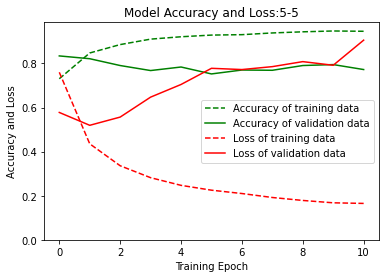


--- Check against test data ---

6584/6584 [==============================] - 1s 89us/step

Accuracy on test data: 0.82

Loss on test data: 0.64

--- Confusion matrix for test data ---



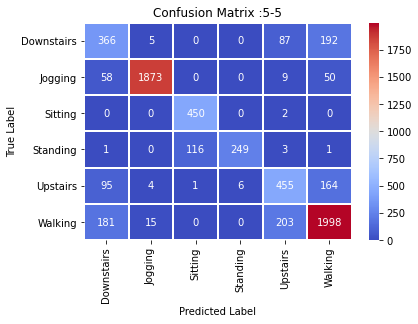


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.52      0.56      0.54       650
           1       0.99      0.94      0.96      1990
           2       0.79      1.00      0.88       452
           3       0.98      0.67      0.80       370
           4       0.60      0.63      0.61       725
           5       0.83      0.83      0.83      2397

    accuracy                           0.82      6584
   macro avg       0.78      0.77      0.77      6584
weighted avg       0.83      0.82      0.82      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 157us/step - loss: 0.7245 - accuracy: 0.7400 - val_loss: 0.5893 - val_accuracy: 0.7995
Epoch 2/25
16694/16694 [==============================] - 2s 140us/step - loss: 0.3845 - accuracy: 0.8659 - val_loss: 0.5497 - val_accuracy: 0.8253
Epoch 3/25
16694/16694 [==============================] - 2s 14

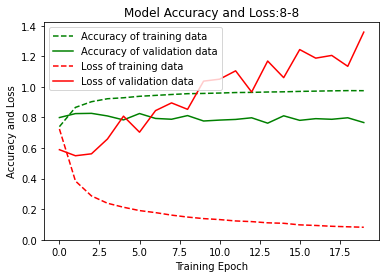


--- Check against test data ---

6584/6584 [==============================] - 1s 80us/step

Accuracy on test data: 0.85

Loss on test data: 0.60

--- Confusion matrix for test data ---



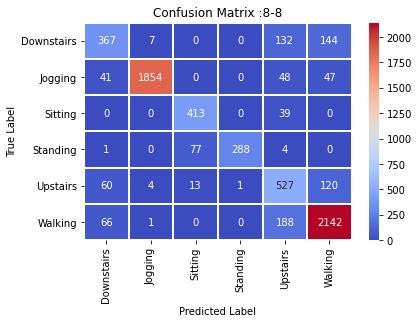


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.69      0.56      0.62       650
           1       0.99      0.93      0.96      1990
           2       0.82      0.91      0.86       452
           3       1.00      0.78      0.87       370
           4       0.56      0.73      0.63       725
           5       0.87      0.89      0.88      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.80      0.81      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 170us/step - loss: 0.6752 - accuracy: 0.7566 - val_loss: 0.5473 - val_accuracy: 0.8081
Epoch 2/25
16694/16694 [==============================] - 2s 148us/step - loss: 0.3566 - accuracy: 0.8703 - val_loss: 0.5220 - val_accuracy: 0.8270
Epoch 3/25
16694/16694 [==============================] - 3s 15

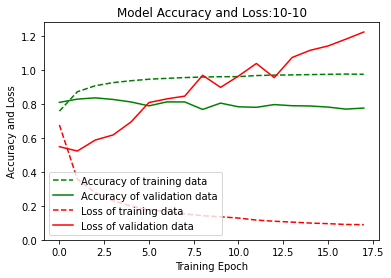


--- Check against test data ---

6584/6584 [==============================] - 1s 76us/step

Accuracy on test data: 0.87

Loss on test data: 0.53

--- Confusion matrix for test data ---



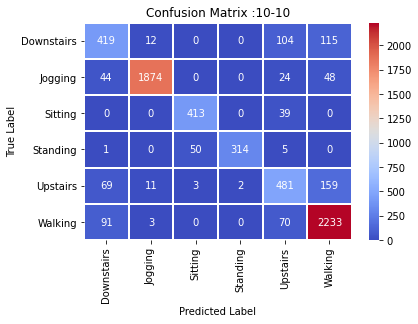


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.67      0.64      0.66       650
           1       0.99      0.94      0.96      1990
           2       0.89      0.91      0.90       452
           3       0.99      0.85      0.92       370
           4       0.67      0.66      0.66       725
           5       0.87      0.93      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.85      0.82      0.83      6584
weighted avg       0.87      0.87      0.87      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 171us/step - loss: 0.6751 - accuracy: 0.7584 - val_loss: 0.5566 - val_accuracy: 0.8218
Epoch 2/25
16694/16694 [==============================] - 3s 157us/step - loss: 0.3483 - accuracy: 0.8777 - val_loss: 0.5667 - val_accuracy: 0.8253
Epoch 3/25
16694/16694 [==============================] - 3s 

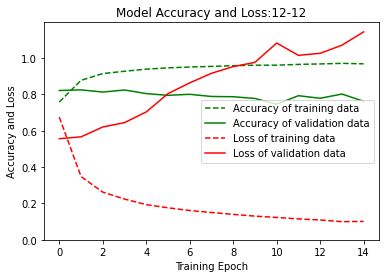


--- Check against test data ---

6584/6584 [==============================] - 1s 76us/step

Accuracy on test data: 0.85

Loss on test data: 0.55

--- Confusion matrix for test data ---



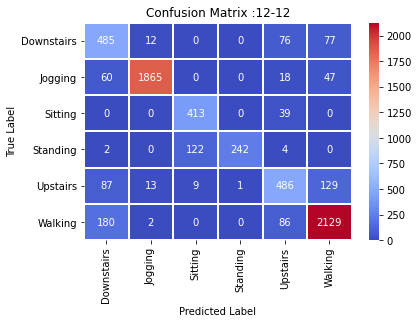


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.60      0.75      0.66       650
           1       0.99      0.94      0.96      1990
           2       0.76      0.91      0.83       452
           3       1.00      0.65      0.79       370
           4       0.69      0.67      0.68       725
           5       0.89      0.89      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.80      0.80      6584
weighted avg       0.87      0.85      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 181us/step - loss: 0.7049 - accuracy: 0.7414 - val_loss: 0.5567 - val_accuracy: 0.8241
Epoch 2/25
16694/16694 [==============================] - 3s 161us/step - loss: 0.3667 - accuracy: 0.8670 - val_loss: 0.5477 - val_accuracy: 0.8256
Epoch 3/25
16694/16694 [==============================] - 3s 

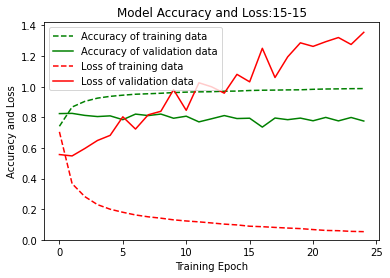


--- Check against test data ---

6584/6584 [==============================] - 1s 82us/step

Accuracy on test data: 0.86

Loss on test data: 0.64

--- Confusion matrix for test data ---



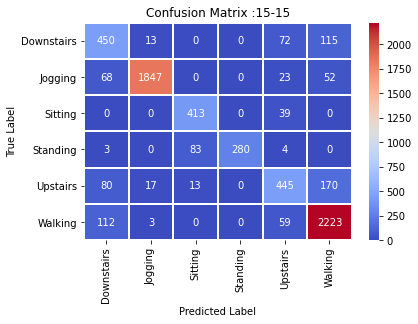


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       650
           1       0.98      0.93      0.95      1990
           2       0.81      0.91      0.86       452
           3       1.00      0.76      0.86       370
           4       0.69      0.61      0.65       725
           5       0.87      0.93      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.81      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 186us/step - loss: 0.7005 - accuracy: 0.7443 - val_loss: 0.5377 - val_accuracy: 0.8368
Epoch 2/25
16694/16694 [==============================] - 3s 169us/step - loss: 0.3685 - accuracy: 0.8670 - val_loss: 0.5029 - val_accuracy: 0.8309
Epoch 3/25
16694/16694 [==============================] - 3s 

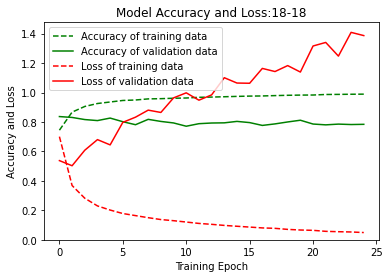


--- Check against test data ---

6584/6584 [==============================] - 1s 82us/step

Accuracy on test data: 0.85

Loss on test data: 0.68

--- Confusion matrix for test data ---



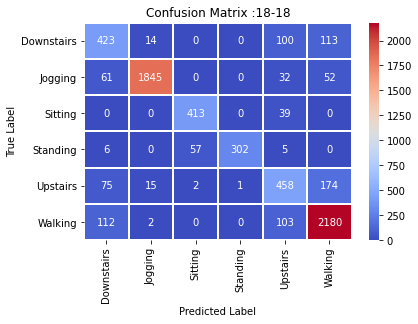


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.62      0.65      0.64       650
           1       0.98      0.93      0.95      1990
           2       0.88      0.91      0.89       452
           3       1.00      0.82      0.90       370
           4       0.62      0.63      0.63       725
           5       0.87      0.91      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.86      0.85      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 183us/step - loss: 0.6643 - accuracy: 0.7612 - val_loss: 0.5805 - val_accuracy: 0.8095
Epoch 2/25
16694/16694 [==============================] - 3s 165us/step - loss: 0.3582 - accuracy: 0.8680 - val_loss: 0.5595 - val_accuracy: 0.8265
Epoch 3/25
16694/16694 [==============================] - 3s 

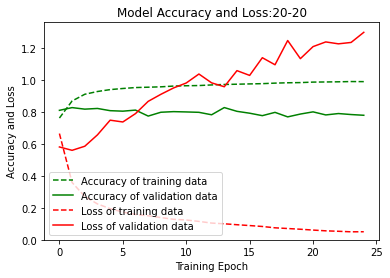


--- Check against test data ---

6584/6584 [==============================] - 1s 89us/step

Accuracy on test data: 0.86

Loss on test data: 0.66

--- Confusion matrix for test data ---



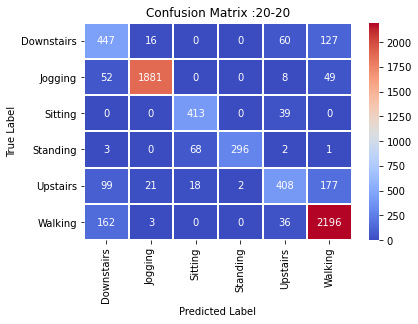


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.59      0.69      0.63       650
           1       0.98      0.95      0.96      1990
           2       0.83      0.91      0.87       452
           3       0.99      0.80      0.89       370
           4       0.74      0.56      0.64       725
           5       0.86      0.92      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 154us/step - loss: 0.8154 - accuracy: 0.7106 - val_loss: 0.6679 - val_accuracy: 0.7995
Epoch 2/25
16694/16694 [==============================] - 2s 113us/step - loss: 0.5358 - accuracy: 0.8181 - val_loss: 0.6171 - val_accuracy: 0.8160
Epoch 3/25
16694/16694 [==============================] - 2s 

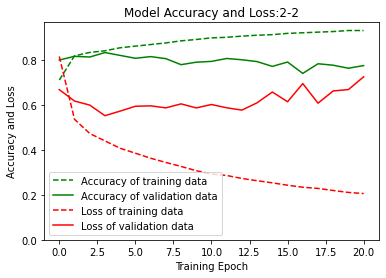


--- Check against test data ---

6584/6584 [==============================] - 0s 71us/step

Accuracy on test data: 0.79

Loss on test data: 1.03

--- Confusion matrix for test data ---



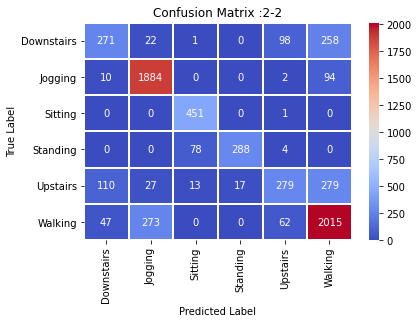


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.62      0.42      0.50       650
           1       0.85      0.95      0.90      1990
           2       0.83      1.00      0.91       452
           3       0.94      0.78      0.85       370
           4       0.63      0.38      0.48       725
           5       0.76      0.84      0.80      2397

    accuracy                           0.79      6584
   macro avg       0.77      0.73      0.74      6584
weighted avg       0.78      0.79      0.77      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 171us/step - loss: 0.7600 - accuracy: 0.7312 - val_loss: 0.5879 - val_accuracy: 0.8062
Epoch 2/25
16694/16694 [==============================] - 3s 162us/step - loss: 0.4271 - accuracy: 0.8483 - val_loss: 0.5726 - val_accuracy: 0.8064
Epoch 3/25
16694/16694 [==============================] - 3s 16

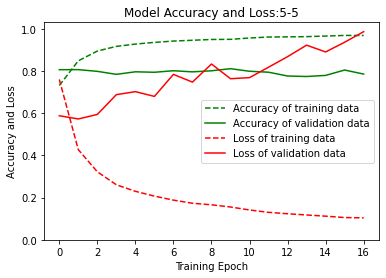


--- Check against test data ---

6584/6584 [==============================] - 0s 76us/step

Accuracy on test data: 0.83

Loss on test data: 0.68

--- Confusion matrix for test data ---



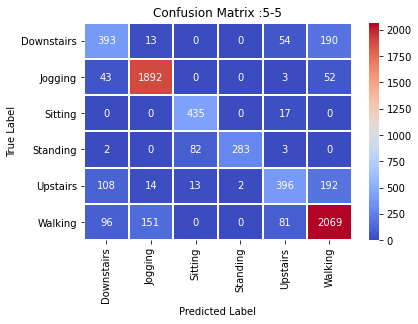


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.61      0.60      0.61       650
           1       0.91      0.95      0.93      1990
           2       0.82      0.96      0.89       452
           3       0.99      0.76      0.86       370
           4       0.71      0.55      0.62       725
           5       0.83      0.86      0.84      2397

    accuracy                           0.83      6584
   macro avg       0.81      0.78      0.79      6584
weighted avg       0.83      0.83      0.83      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 169us/step - loss: 0.6771 - accuracy: 0.7557 - val_loss: 0.5240 - val_accuracy: 0.8301
Epoch 2/25
16694/16694 [==============================] - 3s 156us/step - loss: 0.3487 - accuracy: 0.8768 - val_loss: 0.5262 - val_accuracy: 0.8170
Epoch 3/25
16694/16694 [==============================] - 3s 15

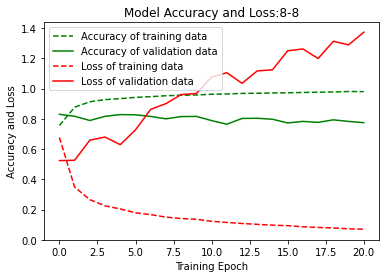


--- Check against test data ---

6584/6584 [==============================] - 0s 67us/step

Accuracy on test data: 0.87

Loss on test data: 0.58

--- Confusion matrix for test data ---



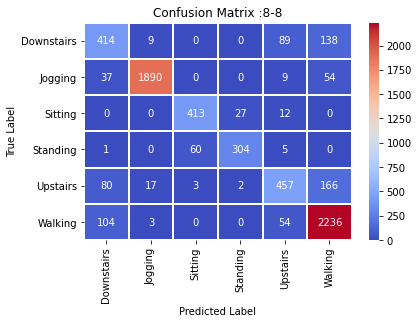


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.65      0.64      0.64       650
           1       0.98      0.95      0.97      1990
           2       0.87      0.91      0.89       452
           3       0.91      0.82      0.86       370
           4       0.73      0.63      0.68       725
           5       0.86      0.93      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.87      0.87      0.87      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 187us/step - loss: 0.6736 - accuracy: 0.7546 - val_loss: 0.5466 - val_accuracy: 0.8232
Epoch 2/25
16694/16694 [==============================] - 3s 177us/step - loss: 0.3402 - accuracy: 0.8810 - val_loss: 0.5843 - val_accuracy: 0.8210
Epoch 3/25
16694/16694 [==============================] - 3s 18

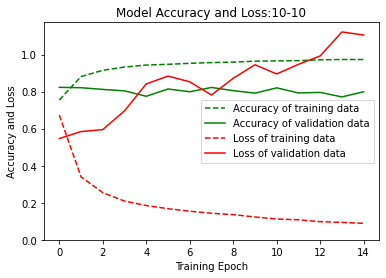


--- Check against test data ---

6584/6584 [==============================] - 0s 76us/step 

Accuracy on test data: 0.86

Loss on test data: 0.59

--- Confusion matrix for test data ---



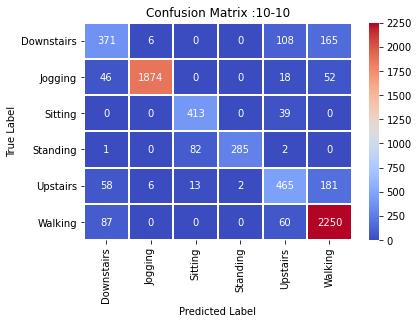


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.66      0.57      0.61       650
           1       0.99      0.94      0.97      1990
           2       0.81      0.91      0.86       452
           3       0.99      0.77      0.87       370
           4       0.67      0.64      0.66       725
           5       0.85      0.94      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 185us/step - loss: 0.6243 - accuracy: 0.7743 - val_loss: 0.5437 - val_accuracy: 0.8170
Epoch 2/25
16694/16694 [==============================] - 3s 199us/step - loss: 0.3314 - accuracy: 0.8811 - val_loss: 0.5179 - val_accuracy: 0.8299
Epoch 3/25
16694/16694 [==============================] - 3s 

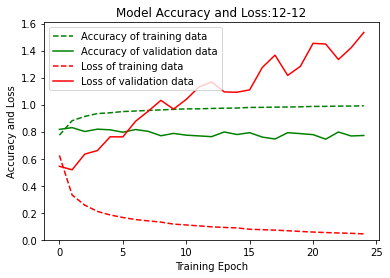


--- Check against test data ---

6584/6584 [==============================] - 0s 72us/step

Accuracy on test data: 0.86

Loss on test data: 0.70

--- Confusion matrix for test data ---



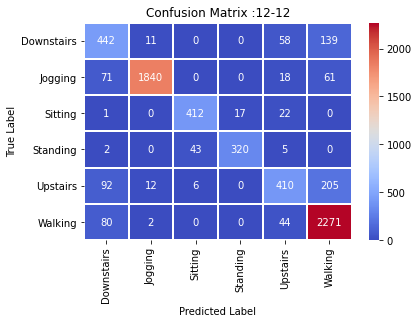


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.64      0.68      0.66       650
           1       0.99      0.92      0.95      1990
           2       0.89      0.91      0.90       452
           3       0.95      0.86      0.91       370
           4       0.74      0.57      0.64       725
           5       0.85      0.95      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.82      0.83      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 196us/step - loss: 0.6486 - accuracy: 0.7642 - val_loss: 0.5568 - val_accuracy: 0.8261
Epoch 2/25
16694/16694 [==============================] - 3s 192us/step - loss: 0.3349 - accuracy: 0.8807 - val_loss: 0.5786 - val_accuracy: 0.8158
Epoch 3/25
16694/16694 [==============================] - 3s 

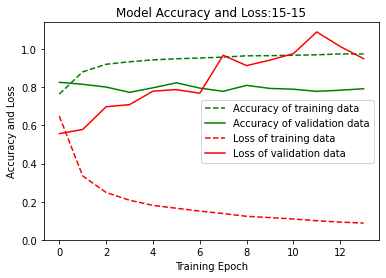


--- Check against test data ---

6584/6584 [==============================] - 0s 70us/step

Accuracy on test data: 0.86

Loss on test data: 0.56

--- Confusion matrix for test data ---



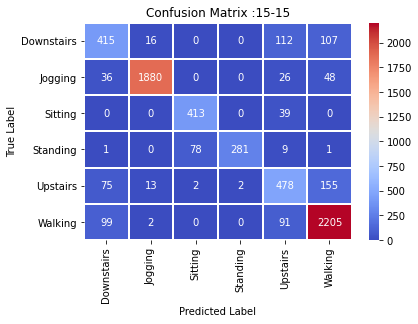


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       650
           1       0.98      0.94      0.96      1990
           2       0.84      0.91      0.87       452
           3       0.99      0.76      0.86       370
           4       0.63      0.66      0.65       725
           5       0.88      0.92      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 179us/step - loss: 0.6742 - accuracy: 0.7527 - val_loss: 0.5481 - val_accuracy: 0.8210
Epoch 2/25
16694/16694 [==============================] - 3s 164us/step - loss: 0.3515 - accuracy: 0.8723 - val_loss: 0.5668 - val_accuracy: 0.8129
Epoch 3/25
16694/16694 [==============================] - 3s 

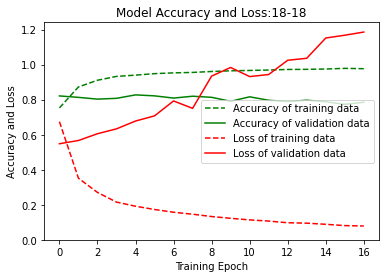


--- Check against test data ---

6584/6584 [==============================] - 1s 82us/step

Accuracy on test data: 0.86

Loss on test data: 0.61

--- Confusion matrix for test data ---



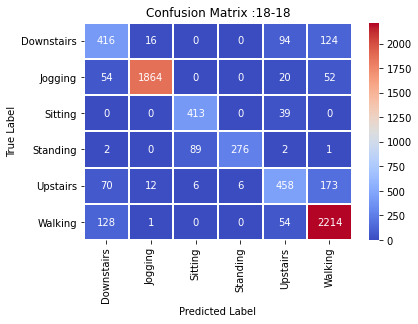


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.62      0.64      0.63       650
           1       0.98      0.94      0.96      1990
           2       0.81      0.91      0.86       452
           3       0.98      0.75      0.85       370
           4       0.69      0.63      0.66       725
           5       0.86      0.92      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.82      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 174us/step - loss: 0.6721 - accuracy: 0.7541 - val_loss: 0.5335 - val_accuracy: 0.8227
Epoch 2/25
16694/16694 [==============================] - 3s 164us/step - loss: 0.3484 - accuracy: 0.8749 - val_loss: 0.5686 - val_accuracy: 0.8119
Epoch 3/25
16694/16694 [==============================] - 3s 

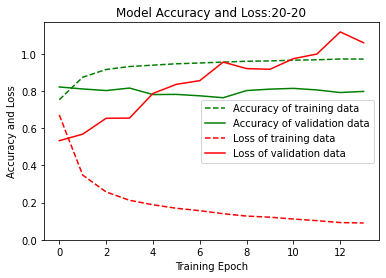


--- Check against test data ---

6584/6584 [==============================] - 0s 70us/step

Accuracy on test data: 0.85

Loss on test data: 0.57

--- Confusion matrix for test data ---



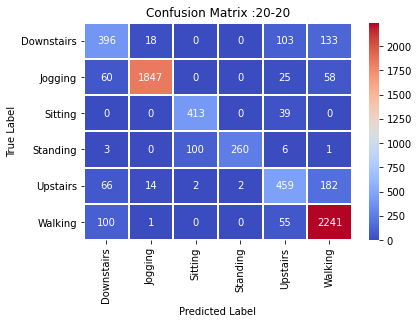


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.63      0.61      0.62       650
           1       0.98      0.93      0.95      1990
           2       0.80      0.91      0.85       452
           3       0.99      0.70      0.82       370
           4       0.67      0.63      0.65       725
           5       0.86      0.93      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.79      0.80      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 166us/step - loss: 0.7918 - accuracy: 0.7248 - val_loss: 0.6832 - val_accuracy: 0.8035
Epoch 2/25
16694/16694 [==============================] - 3s 159us/step - loss: 0.5261 - accuracy: 0.8169 - val_loss: 0.5994 - val_accuracy: 0.8234
Epoch 3/25
16694/16694 [==============================] - 3s 

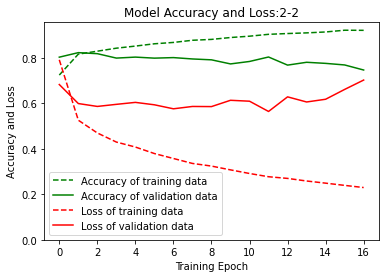


--- Check against test data ---

6584/6584 [==============================] - 1s 85us/step

Accuracy on test data: 0.79

Loss on test data: 1.04

--- Confusion matrix for test data ---



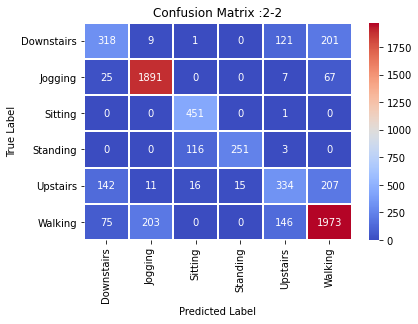


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.57      0.49      0.53       650
           1       0.89      0.95      0.92      1990
           2       0.77      1.00      0.87       452
           3       0.94      0.68      0.79       370
           4       0.55      0.46      0.50       725
           5       0.81      0.82      0.81      2397

    accuracy                           0.79      6584
   macro avg       0.75      0.73      0.74      6584
weighted avg       0.79      0.79      0.79      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 168us/step - loss: 0.7457 - accuracy: 0.7352 - val_loss: 0.5495 - val_accuracy: 0.8414
Epoch 2/25
16694/16694 [==============================] - 3s 151us/step - loss: 0.4104 - accuracy: 0.8563 - val_loss: 0.5402 - val_accuracy: 0.8062
Epoch 3/25
16694/16694 [==============================] - 2s 12

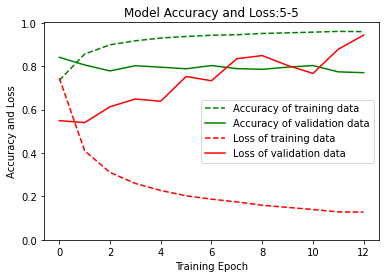


--- Check against test data ---

6584/6584 [==============================] - 1s 93us/step

Accuracy on test data: 0.83

Loss on test data: 0.67

--- Confusion matrix for test data ---



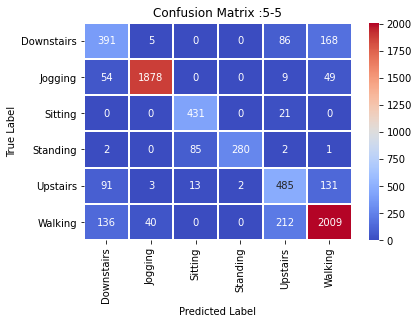


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.58      0.60      0.59       650
           1       0.98      0.94      0.96      1990
           2       0.81      0.95      0.88       452
           3       0.99      0.76      0.86       370
           4       0.60      0.67      0.63       725
           5       0.85      0.84      0.85      2397

    accuracy                           0.83      6584
   macro avg       0.80      0.79      0.79      6584
weighted avg       0.84      0.83      0.83      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 196us/step - loss: 0.6970 - accuracy: 0.7476 - val_loss: 0.5589 - val_accuracy: 0.8277
Epoch 2/25
16694/16694 [==============================] - 3s 183us/step - loss: 0.3525 - accuracy: 0.8780 - val_loss: 0.5272 - val_accuracy: 0.8268
Epoch 3/25
16694/16694 [==============================] - 3s 18

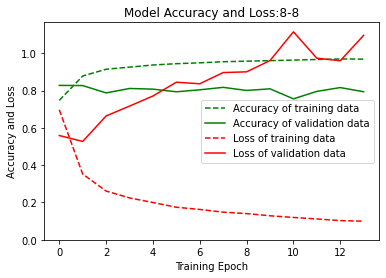


--- Check against test data ---

6584/6584 [==============================] - 1s 95us/step

Accuracy on test data: 0.86

Loss on test data: 0.54

--- Confusion matrix for test data ---



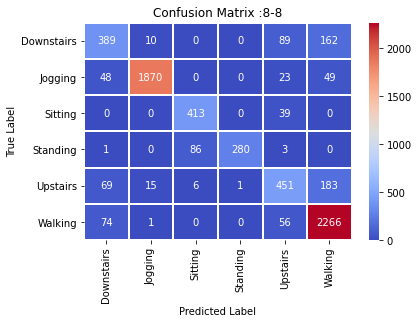


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.67      0.60      0.63       650
           1       0.99      0.94      0.96      1990
           2       0.82      0.91      0.86       452
           3       1.00      0.76      0.86       370
           4       0.68      0.62      0.65       725
           5       0.85      0.95      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 206us/step - loss: 0.6286 - accuracy: 0.7721 - val_loss: 0.5301 - val_accuracy: 0.8194
Epoch 2/25
16694/16694 [==============================] - 3s 195us/step - loss: 0.3273 - accuracy: 0.8862 - val_loss: 0.5523 - val_accuracy: 0.8215
Epoch 3/25
16694/16694 [==============================] - 3s 19

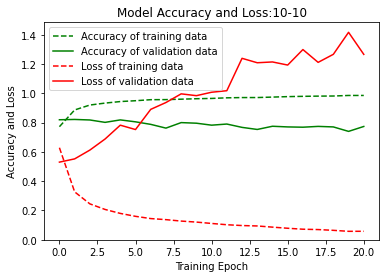


--- Check against test data ---

6584/6584 [==============================] - 1s 90us/step

Accuracy on test data: 0.86

Loss on test data: 0.63

--- Confusion matrix for test data ---



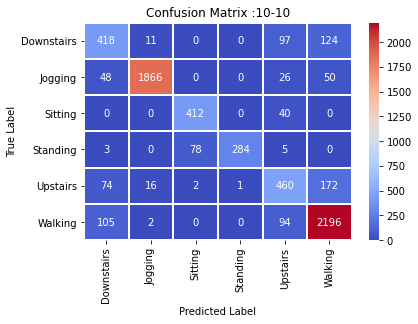


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.65      0.64      0.64       650
           1       0.98      0.94      0.96      1990
           2       0.84      0.91      0.87       452
           3       1.00      0.77      0.87       370
           4       0.64      0.63      0.64       725
           5       0.86      0.92      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 213us/step - loss: 0.6437 - accuracy: 0.7628 - val_loss: 0.5587 - val_accuracy: 0.8141
Epoch 2/25
16694/16694 [==============================] - 3s 185us/step - loss: 0.3259 - accuracy: 0.8831 - val_loss: 0.5503 - val_accuracy: 0.8261
Epoch 3/25
16694/16694 [==============================] - 3s 

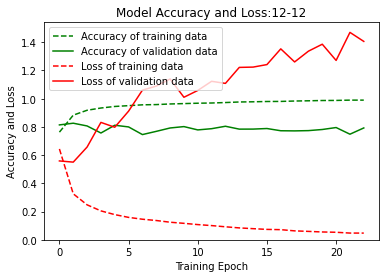


--- Check against test data ---

6584/6584 [==============================] - 1s 93us/step

Accuracy on test data: 0.87

Loss on test data: 0.65

--- Confusion matrix for test data ---



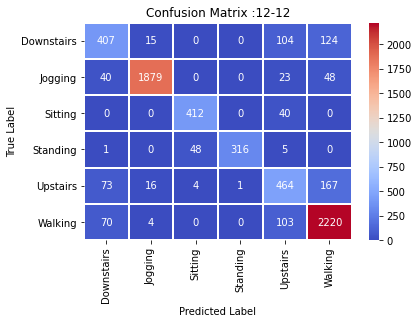


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.69      0.63      0.66       650
           1       0.98      0.94      0.96      1990
           2       0.89      0.91      0.90       452
           3       1.00      0.85      0.92       370
           4       0.63      0.64      0.63       725
           5       0.87      0.93      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.82      0.83      6584
weighted avg       0.87      0.87      0.87      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 231us/step - loss: 0.6691 - accuracy: 0.7612 - val_loss: 0.5170 - val_accuracy: 0.8337
Epoch 2/25
16694/16694 [==============================] - 3s 207us/step - loss: 0.3343 - accuracy: 0.8825 - val_loss: 0.5230 - val_accuracy: 0.8206
Epoch 3/25
16694/16694 [==============================] - 3s 

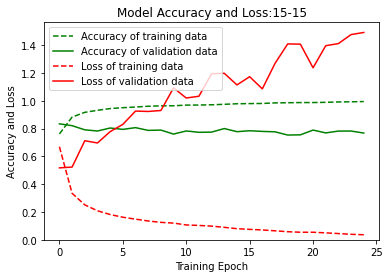


--- Check against test data ---

6584/6584 [==============================] - 1s 86us/step

Accuracy on test data: 0.86

Loss on test data: 0.71

--- Confusion matrix for test data ---



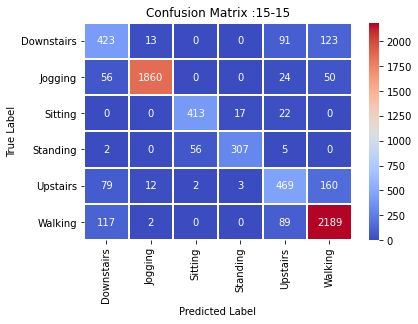


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.62      0.65      0.64       650
           1       0.99      0.93      0.96      1990
           2       0.88      0.91      0.89       452
           3       0.94      0.83      0.88       370
           4       0.67      0.65      0.66       725
           5       0.87      0.91      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 224us/step - loss: 0.6486 - accuracy: 0.7654 - val_loss: 0.5800 - val_accuracy: 0.8162
Epoch 2/25
16694/16694 [==============================] - 3s 207us/step - loss: 0.3298 - accuracy: 0.8840 - val_loss: 0.5797 - val_accuracy: 0.8258
Epoch 3/25
16694/16694 [==============================] - 3s 

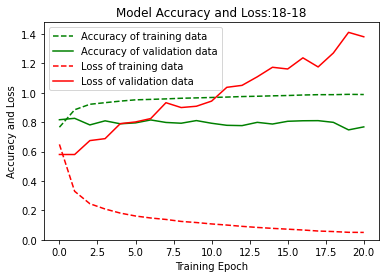


--- Check against test data ---

6584/6584 [==============================] - 1s 86us/step

Accuracy on test data: 0.85

Loss on test data: 0.65

--- Confusion matrix for test data ---



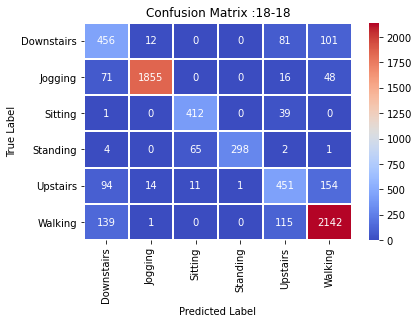


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.60      0.70      0.64       650
           1       0.99      0.93      0.96      1990
           2       0.84      0.91      0.88       452
           3       1.00      0.81      0.89       370
           4       0.64      0.62      0.63       725
           5       0.88      0.89      0.88      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.81      0.81      6584
weighted avg       0.86      0.85      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 228us/step - loss: 0.6840 - accuracy: 0.7500 - val_loss: 0.5357 - val_accuracy: 0.8246
Epoch 2/25
16694/16694 [==============================] - 4s 213us/step - loss: 0.3519 - accuracy: 0.8729 - val_loss: 0.5536 - val_accuracy: 0.8138
Epoch 3/25
16694/16694 [==============================] - 3s 

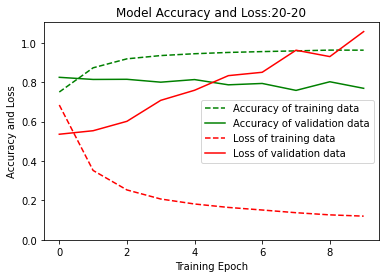


--- Check against test data ---

6584/6584 [==============================] - 1s 87us/step

Accuracy on test data: 0.85

Loss on test data: 0.56

--- Confusion matrix for test data ---



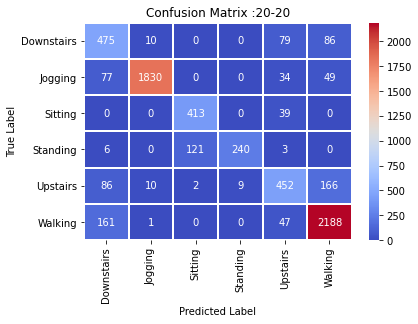


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.59      0.73      0.65       650
           1       0.99      0.92      0.95      1990
           2       0.77      0.91      0.84       452
           3       0.96      0.65      0.78       370
           4       0.69      0.62      0.66       725
           5       0.88      0.91      0.90      2397

    accuracy                           0.85      6584
   macro avg       0.81      0.79      0.79      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 221us/step - loss: 0.7806 - accuracy: 0.7273 - val_loss: 0.6473 - val_accuracy: 0.7961
Epoch 2/25
16694/16694 [==============================] - 3s 196us/step - loss: 0.5189 - accuracy: 0.8174 - val_loss: 0.6016 - val_accuracy: 0.8189
Epoch 3/25
16694/16694 [==============================] - 3s 

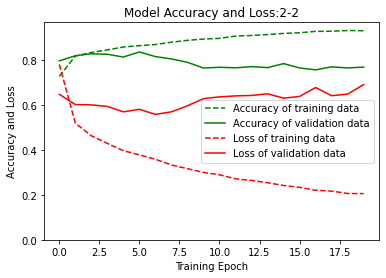


--- Check against test data ---

6584/6584 [==============================] - 1s 85us/step

Accuracy on test data: 0.79

Loss on test data: 1.01

--- Confusion matrix for test data ---



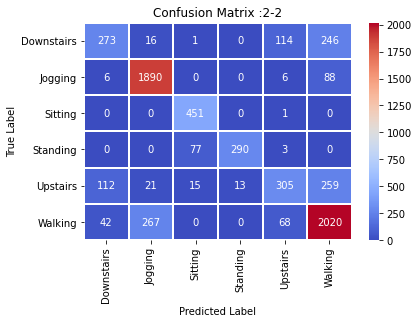


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.63      0.42      0.50       650
           1       0.86      0.95      0.90      1990
           2       0.83      1.00      0.91       452
           3       0.96      0.78      0.86       370
           4       0.61      0.42      0.50       725
           5       0.77      0.84      0.81      2397

    accuracy                           0.79      6584
   macro avg       0.78      0.74      0.75      6584
weighted avg       0.78      0.79      0.78      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 229us/step - loss: 0.7144 - accuracy: 0.7466 - val_loss: 0.5635 - val_accuracy: 0.8220
Epoch 2/25
16694/16694 [==============================] - 3s 206us/step - loss: 0.3970 - accuracy: 0.8616 - val_loss: 0.5414 - val_accuracy: 0.8045
Epoch 3/25
16694/16694 [==============================] - 3s 20

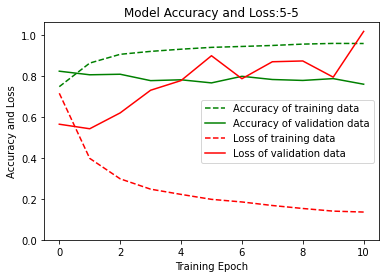


--- Check against test data ---

6584/6584 [==============================] - 1s 77us/step

Accuracy on test data: 0.83

Loss on test data: 0.68

--- Confusion matrix for test data ---



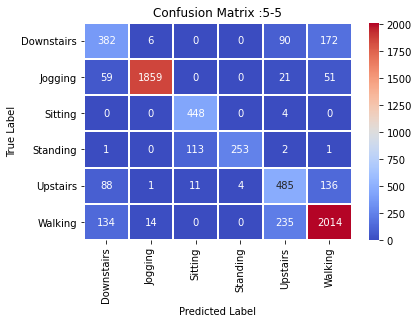


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.58      0.59      0.58       650
           1       0.99      0.93      0.96      1990
           2       0.78      0.99      0.88       452
           3       0.98      0.68      0.81       370
           4       0.58      0.67      0.62       725
           5       0.85      0.84      0.84      2397

    accuracy                           0.83      6584
   macro avg       0.79      0.78      0.78      6584
weighted avg       0.84      0.83      0.83      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 187us/step - loss: 0.6494 - accuracy: 0.7687 - val_loss: 0.5437 - val_accuracy: 0.8265
Epoch 2/25
16694/16694 [==============================] - 3s 184us/step - loss: 0.3255 - accuracy: 0.8896 - val_loss: 0.5947 - val_accuracy: 0.8158
Epoch 3/25
16694/16694 [==============================] - 3s 18

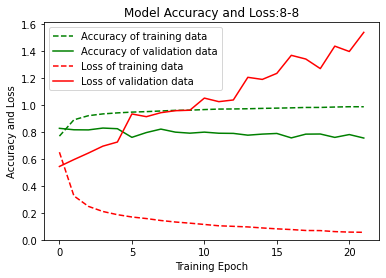


--- Check against test data ---

6584/6584 [==============================] - 0s 73us/step

Accuracy on test data: 0.86

Loss on test data: 0.61

--- Confusion matrix for test data ---



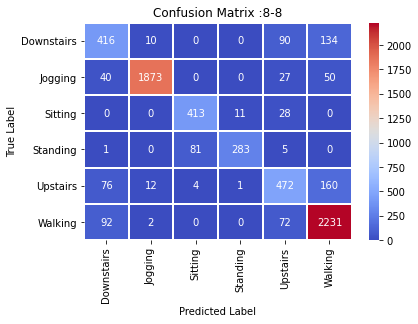


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       650
           1       0.99      0.94      0.96      1990
           2       0.83      0.91      0.87       452
           3       0.96      0.76      0.85       370
           4       0.68      0.65      0.67       725
           5       0.87      0.93      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 206us/step - loss: 0.6449 - accuracy: 0.7684 - val_loss: 0.5181 - val_accuracy: 0.8306
Epoch 2/25
16694/16694 [==============================] - 3s 195us/step - loss: 0.3273 - accuracy: 0.8846 - val_loss: 0.6171 - val_accuracy: 0.8016
Epoch 3/25
16694/16694 [==============================] - 3s 19

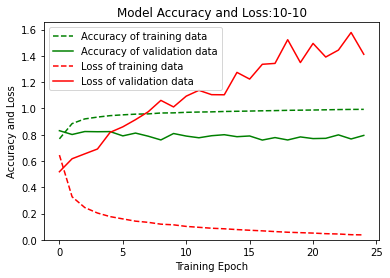


--- Check against test data ---

6584/6584 [==============================] - 0s 75us/step

Accuracy on test data: 0.86

Loss on test data: 0.69

--- Confusion matrix for test data ---



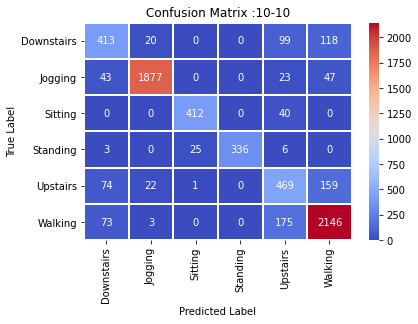


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       650
           1       0.98      0.94      0.96      1990
           2       0.94      0.91      0.93       452
           3       1.00      0.91      0.95       370
           4       0.58      0.65      0.61       725
           5       0.87      0.90      0.88      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.82      0.83      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 200us/step - loss: 0.6392 - accuracy: 0.7704 - val_loss: 0.5226 - val_accuracy: 0.8436
Epoch 2/25
16694/16694 [==============================] - 3s 209us/step - loss: 0.3304 - accuracy: 0.8844 - val_loss: 0.5583 - val_accuracy: 0.8198
Epoch 3/25
16694/16694 [==============================] - 3s 

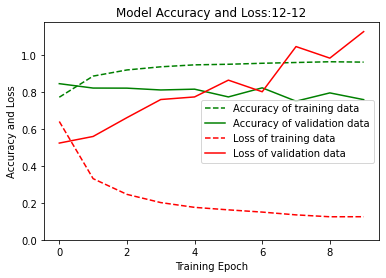


--- Check against test data ---

6584/6584 [==============================] - 0s 69us/step

Accuracy on test data: 0.86

Loss on test data: 0.53

--- Confusion matrix for test data ---



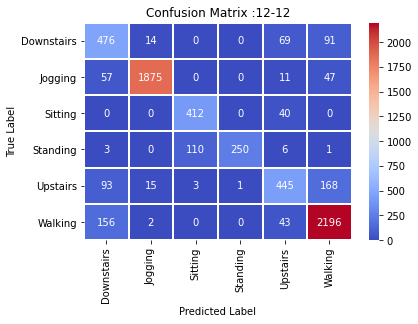


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.61      0.73      0.66       650
           1       0.98      0.94      0.96      1990
           2       0.78      0.91      0.84       452
           3       1.00      0.68      0.81       370
           4       0.72      0.61      0.66       725
           5       0.88      0.92      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.81      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 206us/step - loss: 0.6338 - accuracy: 0.7714 - val_loss: 0.5635 - val_accuracy: 0.8100
Epoch 2/25
16694/16694 [==============================] - 3s 203us/step - loss: 0.3205 - accuracy: 0.8858 - val_loss: 0.5910 - val_accuracy: 0.8126
Epoch 3/25
16694/16694 [==============================] - 3s 

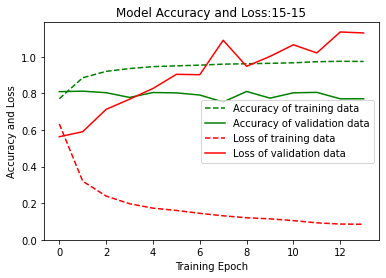


--- Check against test data ---

6584/6584 [==============================] - 0s 69us/step

Accuracy on test data: 0.85

Loss on test data: 0.58

--- Confusion matrix for test data ---



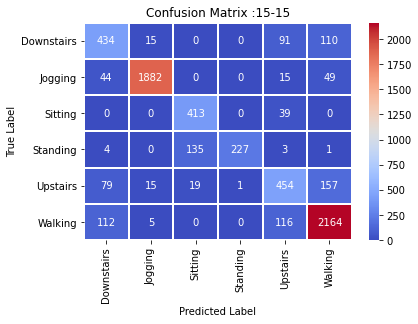


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.64      0.67      0.66       650
           1       0.98      0.95      0.96      1990
           2       0.73      0.91      0.81       452
           3       1.00      0.61      0.76       370
           4       0.63      0.63      0.63       725
           5       0.87      0.90      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.81      0.78      0.78      6584
weighted avg       0.85      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 210us/step - loss: 0.6553 - accuracy: 0.7638 - val_loss: 0.5463 - val_accuracy: 0.8203
Epoch 2/25
16694/16694 [==============================] - 3s 206us/step - loss: 0.3329 - accuracy: 0.8803 - val_loss: 0.5531 - val_accuracy: 0.8098
Epoch 3/25
16694/16694 [==============================] - 3s 

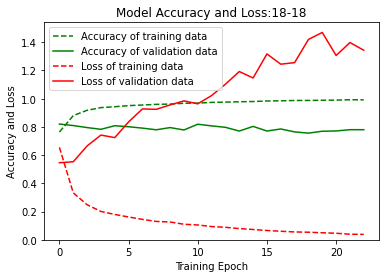


--- Check against test data ---

6584/6584 [==============================] - 0s 76us/step

Accuracy on test data: 0.86

Loss on test data: 0.69

--- Confusion matrix for test data ---



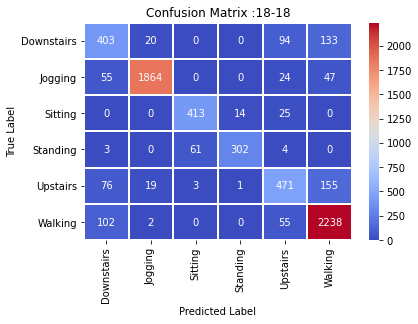


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.63      0.62      0.63       650
           1       0.98      0.94      0.96      1990
           2       0.87      0.91      0.89       452
           3       0.95      0.82      0.88       370
           4       0.70      0.65      0.67       725
           5       0.87      0.93      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 219us/step - loss: 0.6111 - accuracy: 0.7785 - val_loss: 0.5172 - val_accuracy: 0.8244
Epoch 2/25
16694/16694 [==============================] - 3s 206us/step - loss: 0.3147 - accuracy: 0.8885 - val_loss: 0.5679 - val_accuracy: 0.8237
Epoch 3/25
16694/16694 [==============================] - 3s 

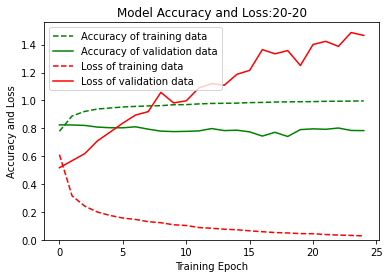


--- Check against test data ---

6584/6584 [==============================] - 0s 74us/step

Accuracy on test data: 0.86

Loss on test data: 0.74

--- Confusion matrix for test data ---



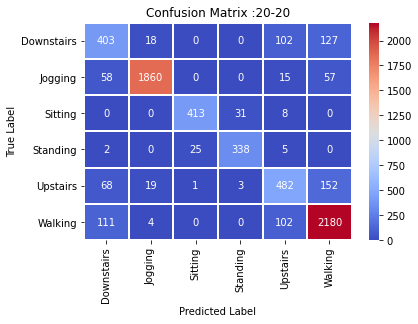


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.63      0.62      0.62       650
           1       0.98      0.93      0.96      1990
           2       0.94      0.91      0.93       452
           3       0.91      0.91      0.91       370
           4       0.68      0.66      0.67       725
           5       0.87      0.91      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.83      0.83      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 218us/step - loss: 0.7847 - accuracy: 0.7213 - val_loss: 0.6564 - val_accuracy: 0.8004
Epoch 2/25
16694/16694 [==============================] - 4s 210us/step - loss: 0.5182 - accuracy: 0.8186 - val_loss: 0.6148 - val_accuracy: 0.8110
Epoch 3/25
16694/16694 [==============================] - 4s 

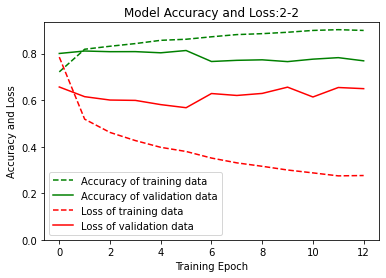


--- Check against test data ---

6584/6584 [==============================] - 1s 86us/step

Accuracy on test data: 0.78

Loss on test data: 0.97

--- Confusion matrix for test data ---



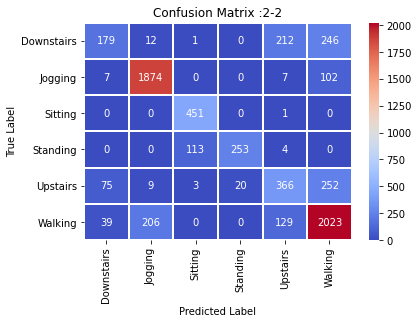


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.60      0.28      0.38       650
           1       0.89      0.94      0.92      1990
           2       0.79      1.00      0.88       452
           3       0.93      0.68      0.79       370
           4       0.51      0.50      0.51       725
           5       0.77      0.84      0.81      2397

    accuracy                           0.78      6584
   macro avg       0.75      0.71      0.71      6584
weighted avg       0.77      0.78      0.77      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 238us/step - loss: 0.7176 - accuracy: 0.7376 - val_loss: 0.5794 - val_accuracy: 0.8115
Epoch 2/25
16694/16694 [==============================] - 4s 226us/step - loss: 0.3954 - accuracy: 0.8625 - val_loss: 0.6020 - val_accuracy: 0.7973
Epoch 3/25
16694/16694 [==============================] - 4s 23

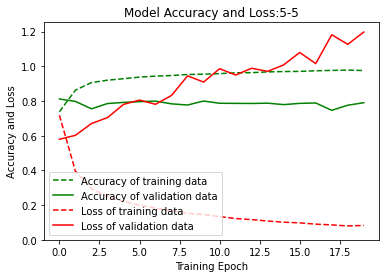


--- Check against test data ---

6584/6584 [==============================] - 0s 75us/step

Accuracy on test data: 0.83

Loss on test data: 0.74

--- Confusion matrix for test data ---



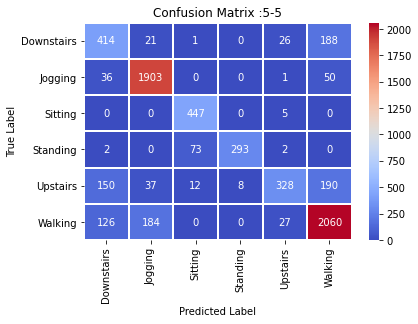


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.57      0.64      0.60       650
           1       0.89      0.96      0.92      1990
           2       0.84      0.99      0.91       452
           3       0.97      0.79      0.87       370
           4       0.84      0.45      0.59       725
           5       0.83      0.86      0.84      2397

    accuracy                           0.83      6584
   macro avg       0.82      0.78      0.79      6584
weighted avg       0.83      0.83      0.82      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 213us/step - loss: 0.6600 - accuracy: 0.7607 - val_loss: 0.5239 - val_accuracy: 0.8258
Epoch 2/25
16694/16694 [==============================] - 3s 204us/step - loss: 0.3252 - accuracy: 0.8904 - val_loss: 0.5698 - val_accuracy: 0.8268
Epoch 3/25
16694/16694 [==============================] - 4s 22

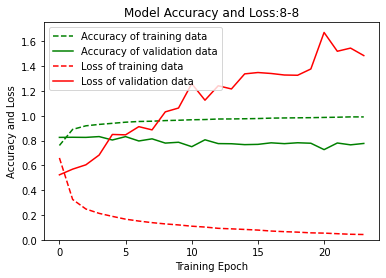


--- Check against test data ---

6584/6584 [==============================] - 1s 83us/step

Accuracy on test data: 0.87

Loss on test data: 0.61

--- Confusion matrix for test data ---



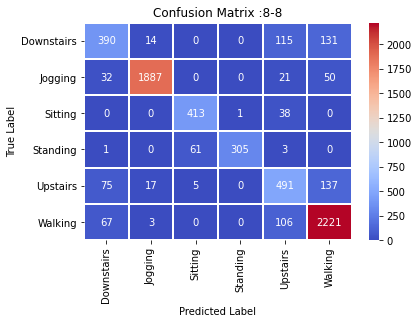


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.69      0.60      0.64       650
           1       0.98      0.95      0.96      1990
           2       0.86      0.91      0.89       452
           3       1.00      0.82      0.90       370
           4       0.63      0.68      0.66       725
           5       0.87      0.93      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.82      0.83      6584
weighted avg       0.87      0.87      0.87      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 228us/step - loss: 0.6375 - accuracy: 0.7675 - val_loss: 0.5252 - val_accuracy: 0.8241
Epoch 2/25
16694/16694 [==============================] - 4s 226us/step - loss: 0.3146 - accuracy: 0.8902 - val_loss: 0.5767 - val_accuracy: 0.8148
Epoch 3/25
16694/16694 [==============================] - 4s 23

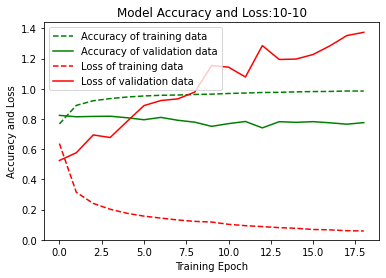


--- Check against test data ---

6584/6584 [==============================] - 1s 81us/step

Accuracy on test data: 0.86

Loss on test data: 0.64

--- Confusion matrix for test data ---



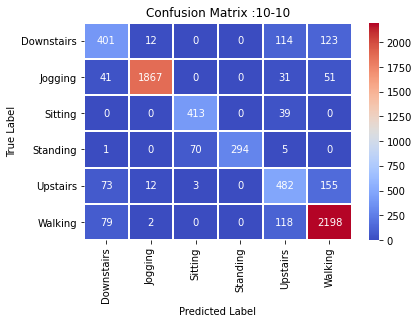


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.67      0.62      0.64       650
           1       0.99      0.94      0.96      1990
           2       0.85      0.91      0.88       452
           3       1.00      0.79      0.89       370
           4       0.61      0.66      0.64       725
           5       0.87      0.92      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 224us/step - loss: 0.6155 - accuracy: 0.7755 - val_loss: 0.5392 - val_accuracy: 0.8337
Epoch 2/25
16694/16694 [==============================] - 4s 210us/step - loss: 0.3078 - accuracy: 0.8926 - val_loss: 0.6001 - val_accuracy: 0.8088
Epoch 3/25
16694/16694 [==============================] - 4s 

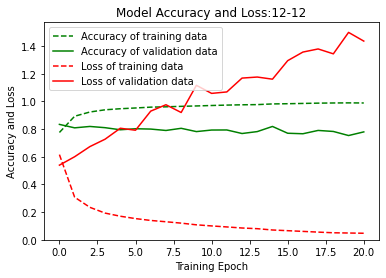


--- Check against test data ---

6584/6584 [==============================] - 0s 72us/step

Accuracy on test data: 0.85

Loss on test data: 0.66

--- Confusion matrix for test data ---



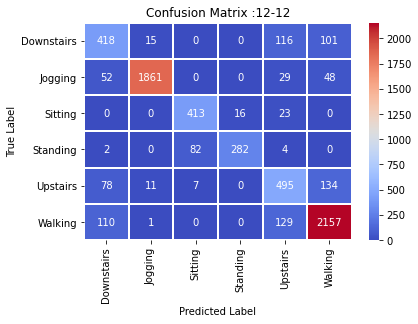


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.63      0.64      0.64       650
           1       0.99      0.94      0.96      1990
           2       0.82      0.91      0.87       452
           3       0.95      0.76      0.84       370
           4       0.62      0.68      0.65       725
           5       0.88      0.90      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.81      0.81      6584
weighted avg       0.86      0.85      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 199us/step - loss: 0.6407 - accuracy: 0.7691 - val_loss: 0.5711 - val_accuracy: 0.8150
Epoch 2/25
16694/16694 [==============================] - 3s 190us/step - loss: 0.3242 - accuracy: 0.8868 - val_loss: 0.5708 - val_accuracy: 0.8258
Epoch 3/25
16694/16694 [==============================] - 3s 

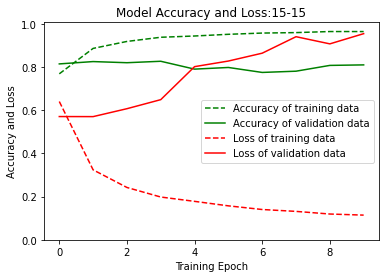


--- Check against test data ---

6584/6584 [==============================] - 1s 84us/step

Accuracy on test data: 0.86

Loss on test data: 0.55

--- Confusion matrix for test data ---



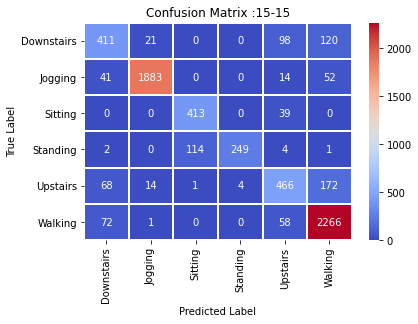


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.69      0.63      0.66       650
           1       0.98      0.95      0.96      1990
           2       0.78      0.91      0.84       452
           3       0.98      0.67      0.80       370
           4       0.69      0.64      0.66       725
           5       0.87      0.95      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.79      0.81      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 204us/step - loss: 0.5961 - accuracy: 0.7824 - val_loss: 0.5355 - val_accuracy: 0.8309
Epoch 2/25
16694/16694 [==============================] - 3s 194us/step - loss: 0.3115 - accuracy: 0.8928 - val_loss: 0.6236 - val_accuracy: 0.8004
Epoch 3/25
16694/16694 [==============================] - 3s 

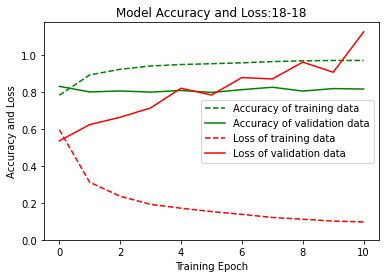


--- Check against test data ---

6584/6584 [==============================] - 1s 83us/step

Accuracy on test data: 0.86

Loss on test data: 0.53

--- Confusion matrix for test data ---



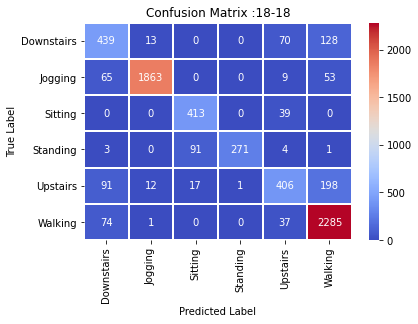


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.65      0.68      0.66       650
           1       0.99      0.94      0.96      1990
           2       0.79      0.91      0.85       452
           3       1.00      0.73      0.84       370
           4       0.72      0.56      0.63       725
           5       0.86      0.95      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 3s 201us/step - loss: 0.6164 - accuracy: 0.7787 - val_loss: 0.5736 - val_accuracy: 0.8105
Epoch 2/25
16694/16694 [==============================] - 3s 189us/step - loss: 0.3207 - accuracy: 0.8882 - val_loss: 0.5186 - val_accuracy: 0.8287
Epoch 3/25
16694/16694 [==============================] - 3s 

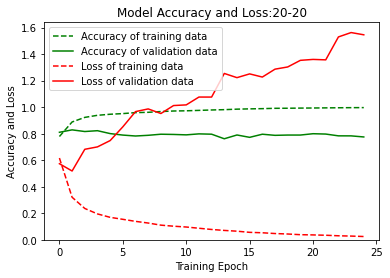


--- Check against test data ---

6584/6584 [==============================] - 1s 85us/step

Accuracy on test data: 0.86

Loss on test data: 0.69

--- Confusion matrix for test data ---



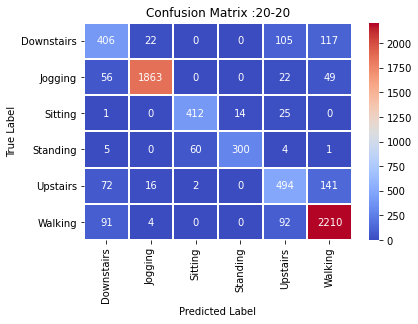


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       650
           1       0.98      0.94      0.96      1990
           2       0.87      0.91      0.89       452
           3       0.96      0.81      0.88       370
           4       0.67      0.68      0.67       725
           5       0.88      0.92      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 225us/step - loss: 0.7613 - accuracy: 0.7318 - val_loss: 0.6525 - val_accuracy: 0.8002
Epoch 2/25
16694/16694 [==============================] - 4s 213us/step - loss: 0.5057 - accuracy: 0.8187 - val_loss: 0.5951 - val_accuracy: 0.8174
Epoch 3/25
16694/16694 [==============================] - 4s 

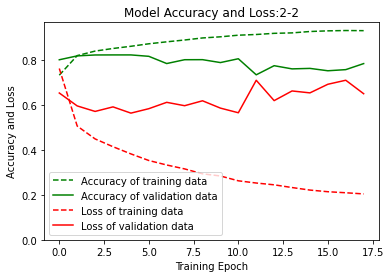


--- Check against test data ---

6584/6584 [==============================] - 1s 99us/step

Accuracy on test data: 0.80

Loss on test data: 1.15

--- Confusion matrix for test data ---



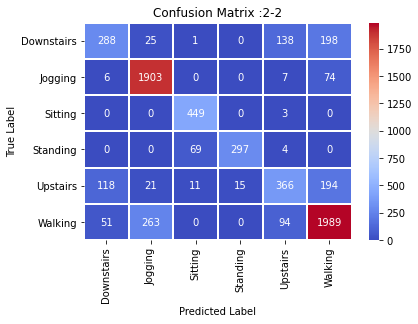


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.62      0.44      0.52       650
           1       0.86      0.96      0.91      1990
           2       0.85      0.99      0.91       452
           3       0.95      0.80      0.87       370
           4       0.60      0.50      0.55       725
           5       0.81      0.83      0.82      2397

    accuracy                           0.80      6584
   macro avg       0.78      0.76      0.76      6584
weighted avg       0.79      0.80      0.80      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 281us/step - loss: 0.6855 - accuracy: 0.7542 - val_loss: 0.6439 - val_accuracy: 0.7839
Epoch 2/25
16694/16694 [==============================] - 5s 275us/step - loss: 0.3859 - accuracy: 0.8644 - val_loss: 0.5433 - val_accuracy: 0.8076
Epoch 3/25
16694/16694 [==============================] - 4s 26

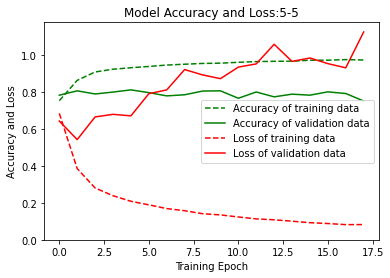


--- Check against test data ---

6584/6584 [==============================] - 1s 99us/step

Accuracy on test data: 0.83

Loss on test data: 0.81

--- Confusion matrix for test data ---



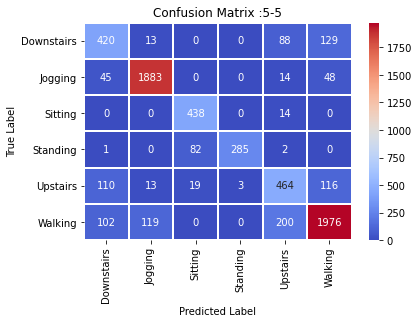


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.62      0.65      0.63       650
           1       0.93      0.95      0.94      1990
           2       0.81      0.97      0.88       452
           3       0.99      0.77      0.87       370
           4       0.59      0.64      0.62       725
           5       0.87      0.82      0.85      2397

    accuracy                           0.83      6584
   macro avg       0.80      0.80      0.80      6584
weighted avg       0.84      0.83      0.83      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 273us/step - loss: 0.6574 - accuracy: 0.7675 - val_loss: 0.5405 - val_accuracy: 0.8220
Epoch 2/25
16694/16694 [==============================] - 4s 258us/step - loss: 0.3332 - accuracy: 0.8857 - val_loss: 0.5460 - val_accuracy: 0.8241
Epoch 3/25
16694/16694 [==============================] - 4s 26

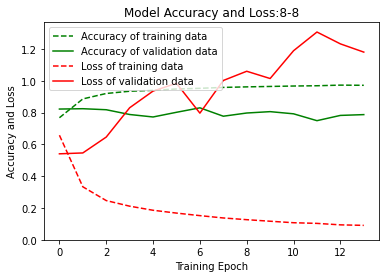


--- Check against test data ---

6584/6584 [==============================] - 1s 90us/step

Accuracy on test data: 0.85

Loss on test data: 0.57

--- Confusion matrix for test data ---



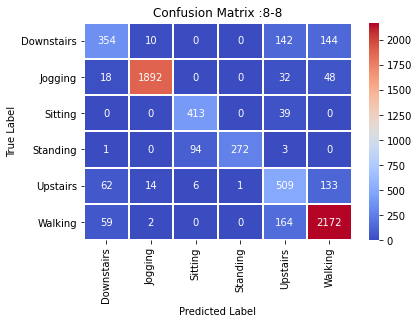


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.72      0.54      0.62       650
           1       0.99      0.95      0.97      1990
           2       0.81      0.91      0.86       452
           3       1.00      0.74      0.85       370
           4       0.57      0.70      0.63       725
           5       0.87      0.91      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.79      0.80      6584
weighted avg       0.86      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 273us/step - loss: 0.6197 - accuracy: 0.7697 - val_loss: 0.5278 - val_accuracy: 0.8270
Epoch 2/25
16694/16694 [==============================] - 4s 268us/step - loss: 0.3006 - accuracy: 0.8961 - val_loss: 0.5886 - val_accuracy: 0.8170
Epoch 3/25
16694/16694 [==============================] - 4s 26

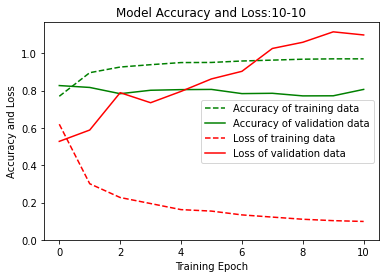


--- Check against test data ---

6584/6584 [==============================] - 0s 70us/step

Accuracy on test data: 0.85

Loss on test data: 0.63

--- Confusion matrix for test data ---



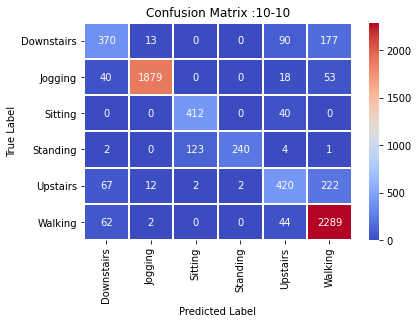


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.68      0.57      0.62       650
           1       0.99      0.94      0.96      1990
           2       0.77      0.91      0.83       452
           3       0.99      0.65      0.78       370
           4       0.68      0.58      0.63       725
           5       0.83      0.95      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.77      0.79      6584
weighted avg       0.85      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 270us/step - loss: 0.6004 - accuracy: 0.7854 - val_loss: 0.5555 - val_accuracy: 0.8232
Epoch 2/25
16694/16694 [==============================] - 4s 256us/step - loss: 0.3031 - accuracy: 0.8966 - val_loss: 0.5692 - val_accuracy: 0.8301
Epoch 3/25
16694/16694 [==============================] - 4s 

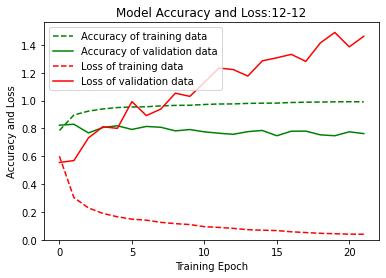


--- Check against test data ---

6584/6584 [==============================] - 1s 93us/step

Accuracy on test data: 0.86

Loss on test data: 0.68

--- Confusion matrix for test data ---



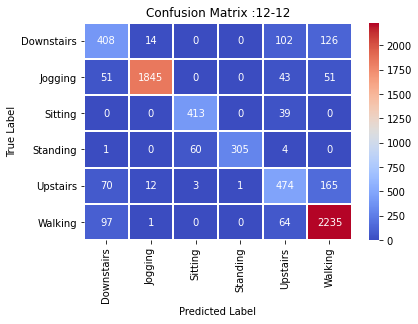


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.65      0.63      0.64       650
           1       0.99      0.93      0.96      1990
           2       0.87      0.91      0.89       452
           3       1.00      0.82      0.90       370
           4       0.65      0.65      0.65       725
           5       0.87      0.93      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 274us/step - loss: 0.5924 - accuracy: 0.7848 - val_loss: 0.5073 - val_accuracy: 0.8304
Epoch 2/25
16694/16694 [==============================] - 4s 257us/step - loss: 0.2988 - accuracy: 0.8967 - val_loss: 0.5619 - val_accuracy: 0.8110
Epoch 3/25
16694/16694 [==============================] - 4s 

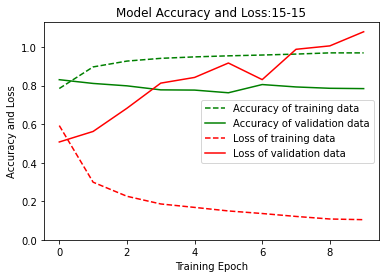


--- Check against test data ---

6584/6584 [==============================] - 1s 118us/step

Accuracy on test data: 0.86

Loss on test data: 0.56

--- Confusion matrix for test data ---



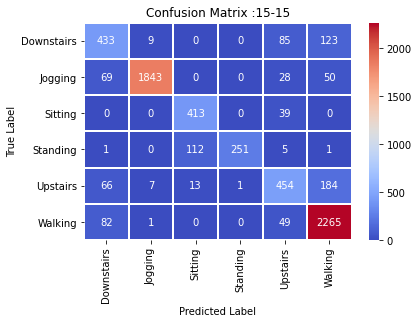


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       650
           1       0.99      0.93      0.96      1990
           2       0.77      0.91      0.83       452
           3       1.00      0.68      0.81       370
           4       0.69      0.63      0.66       725
           5       0.86      0.94      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.79      0.80      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 270us/step - loss: 0.6035 - accuracy: 0.7861 - val_loss: 0.5605 - val_accuracy: 0.8239
Epoch 2/25
16694/16694 [==============================] - 4s 269us/step - loss: 0.3129 - accuracy: 0.8919 - val_loss: 0.5689 - val_accuracy: 0.8191
Epoch 3/25
16694/16694 [==============================] - 4s 

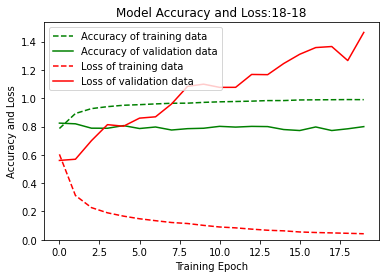


--- Check against test data ---

6584/6584 [==============================] - 1s 100us/step

Accuracy on test data: 0.86

Loss on test data: 0.71

--- Confusion matrix for test data ---



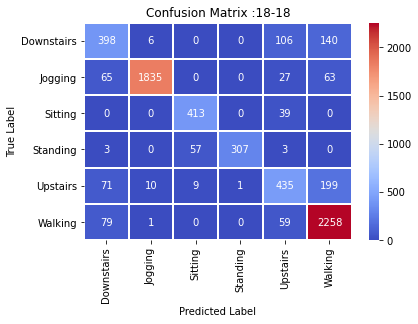


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.65      0.61      0.63       650
           1       0.99      0.92      0.96      1990
           2       0.86      0.91      0.89       452
           3       1.00      0.83      0.91       370
           4       0.65      0.60      0.62       725
           5       0.85      0.94      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 254us/step - loss: 0.6119 - accuracy: 0.7742 - val_loss: 0.5342 - val_accuracy: 0.8263
Epoch 2/25
16694/16694 [==============================] - 3s 202us/step - loss: 0.3169 - accuracy: 0.8873 - val_loss: 0.6598 - val_accuracy: 0.8055
Epoch 3/25
16694/16694 [==============================] - 4s 

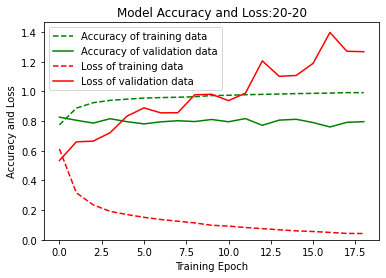


--- Check against test data ---

6584/6584 [==============================] - 1s 79us/step

Accuracy on test data: 0.87

Loss on test data: 0.66

--- Confusion matrix for test data ---



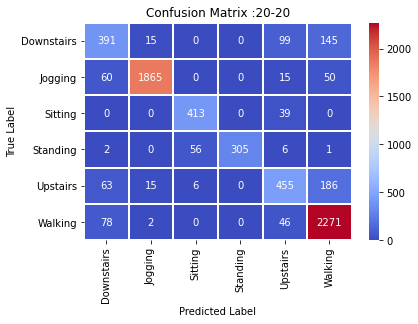


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.66      0.60      0.63       650
           1       0.98      0.94      0.96      1990
           2       0.87      0.91      0.89       452
           3       1.00      0.82      0.90       370
           4       0.69      0.63      0.66       725
           5       0.86      0.95      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.87      0.87      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 4s 269us/step - loss: 0.7642 - accuracy: 0.7353 - val_loss: 0.6551 - val_accuracy: 0.8019
Epoch 2/25
16694/16694 [==============================] - 5s 272us/step - loss: 0.5045 - accuracy: 0.8230 - val_loss: 0.6197 - val_accuracy: 0.8134
Epoch 3/25
16694/16694 [==============================] - 5s 

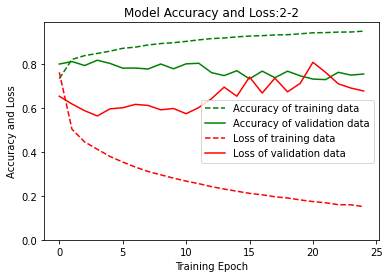


--- Check against test data ---

6584/6584 [==============================] - 1s 85us/step

Accuracy on test data: 0.82

Loss on test data: 1.43

--- Confusion matrix for test data ---



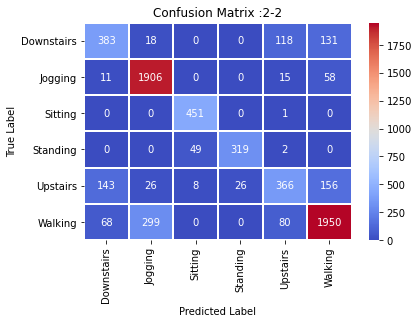


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.63      0.59      0.61       650
           1       0.85      0.96      0.90      1990
           2       0.89      1.00      0.94       452
           3       0.92      0.86      0.89       370
           4       0.63      0.50      0.56       725
           5       0.85      0.81      0.83      2397

    accuracy                           0.82      6584
   macro avg       0.80      0.79      0.79      6584
weighted avg       0.81      0.82      0.81      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 283us/step - loss: 0.6938 - accuracy: 0.7539 - val_loss: 0.5664 - val_accuracy: 0.8182
Epoch 2/25
16694/16694 [==============================] - 5s 282us/step - loss: 0.3622 - accuracy: 0.8750 - val_loss: 0.5450 - val_accuracy: 0.8023
Epoch 3/25
16694/16694 [==============================] - 5s 28

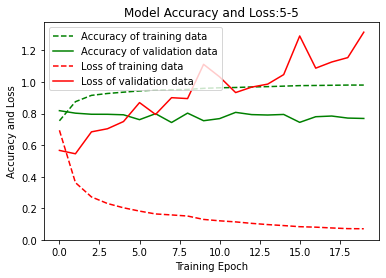


--- Check against test data ---

6584/6584 [==============================] - 1s 81us/step

Accuracy on test data: 0.84

Loss on test data: 0.74

--- Confusion matrix for test data ---



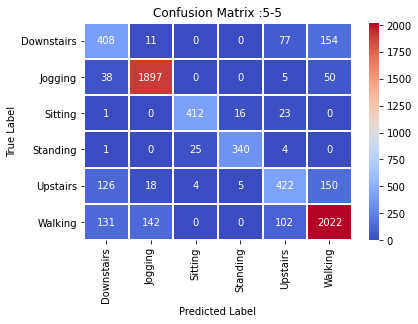


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.58      0.63      0.60       650
           1       0.92      0.95      0.93      1990
           2       0.93      0.91      0.92       452
           3       0.94      0.92      0.93       370
           4       0.67      0.58      0.62       725
           5       0.85      0.84      0.85      2397

    accuracy                           0.84      6584
   macro avg       0.81      0.81      0.81      6584
weighted avg       0.83      0.84      0.83      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 285us/step - loss: 0.6159 - accuracy: 0.7758 - val_loss: 0.5216 - val_accuracy: 0.8165
Epoch 2/25
16694/16694 [==============================] - 5s 282us/step - loss: 0.3021 - accuracy: 0.8992 - val_loss: 0.5632 - val_accuracy: 0.8258
Epoch 3/25
16694/16694 [==============================] - 4s 26

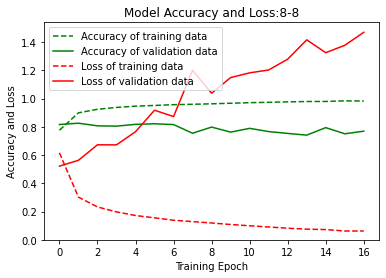


--- Check against test data ---

6584/6584 [==============================] - 1s 78us/step

Accuracy on test data: 0.87

Loss on test data: 0.59

--- Confusion matrix for test data ---



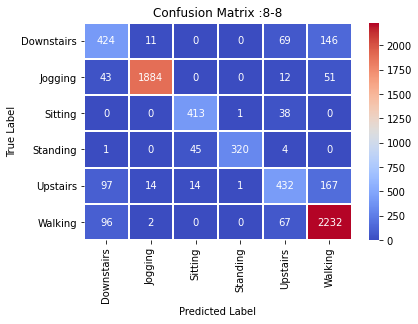


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.64      0.65      0.65       650
           1       0.99      0.95      0.97      1990
           2       0.88      0.91      0.89       452
           3       0.99      0.86      0.92       370
           4       0.69      0.60      0.64       725
           5       0.86      0.93      0.89      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.82      0.83      6584
weighted avg       0.87      0.87      0.87      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 293us/step - loss: 0.6300 - accuracy: 0.7697 - val_loss: 0.5277 - val_accuracy: 0.8234
Epoch 2/25
16694/16694 [==============================] - 5s 282us/step - loss: 0.3123 - accuracy: 0.8887 - val_loss: 0.5210 - val_accuracy: 0.8354
Epoch 3/25
16694/16694 [==============================] - 5s 28

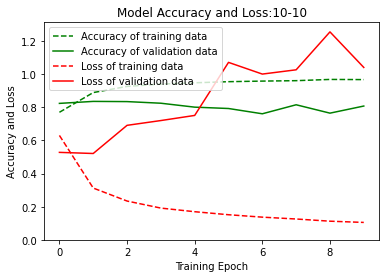


--- Check against test data ---

6584/6584 [==============================] - 1s 92us/step

Accuracy on test data: 0.86

Loss on test data: 0.56

--- Confusion matrix for test data ---



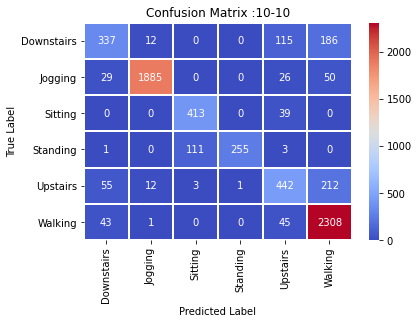


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.72      0.52      0.60       650
           1       0.99      0.95      0.97      1990
           2       0.78      0.91      0.84       452
           3       1.00      0.69      0.81       370
           4       0.66      0.61      0.63       725
           5       0.84      0.96      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.77      0.79      6584
weighted avg       0.86      0.86      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 277us/step - loss: 0.6208 - accuracy: 0.7739 - val_loss: 0.5014 - val_accuracy: 0.8256
Epoch 2/25
16694/16694 [==============================] - 4s 269us/step - loss: 0.3032 - accuracy: 0.8937 - val_loss: 0.5753 - val_accuracy: 0.8198
Epoch 3/25
16694/16694 [==============================] - 4s 

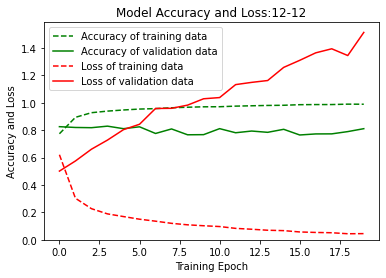


--- Check against test data ---

6584/6584 [==============================] - 1s 86us/step

Accuracy on test data: 0.86

Loss on test data: 0.69

--- Confusion matrix for test data ---



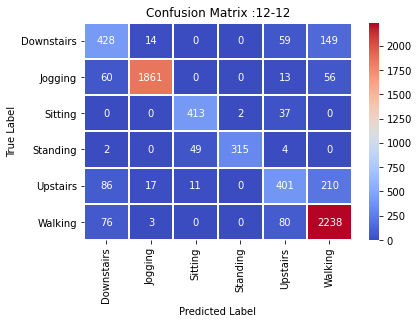


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       650
           1       0.98      0.94      0.96      1990
           2       0.87      0.91      0.89       452
           3       0.99      0.85      0.92       370
           4       0.68      0.55      0.61       725
           5       0.84      0.93      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 294us/step - loss: 0.6036 - accuracy: 0.7840 - val_loss: 0.5633 - val_accuracy: 0.8177
Epoch 2/25
16694/16694 [==============================] - 5s 282us/step - loss: 0.3016 - accuracy: 0.8969 - val_loss: 0.6507 - val_accuracy: 0.8208
Epoch 3/25
16694/16694 [==============================] - 5s 

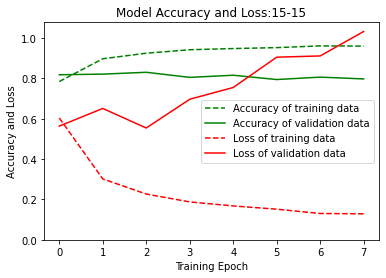


--- Check against test data ---

6584/6584 [==============================] - 1s 86us/step

Accuracy on test data: 0.86

Loss on test data: 0.58

--- Confusion matrix for test data ---



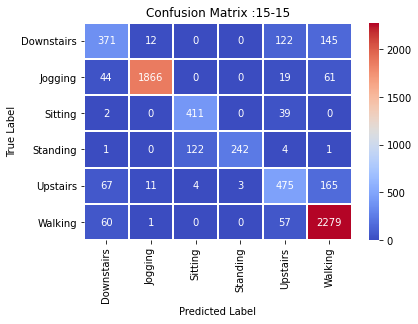


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.68      0.57      0.62       650
           1       0.99      0.94      0.96      1990
           2       0.77      0.91      0.83       452
           3       0.99      0.65      0.79       370
           4       0.66      0.66      0.66       725
           5       0.86      0.95      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.82      0.78      0.79      6584
weighted avg       0.86      0.86      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 275us/step - loss: 0.5918 - accuracy: 0.7827 - val_loss: 0.5334 - val_accuracy: 0.8253
Epoch 2/25
16694/16694 [==============================] - 5s 271us/step - loss: 0.2934 - accuracy: 0.8977 - val_loss: 0.6023 - val_accuracy: 0.8182
Epoch 3/25
16694/16694 [==============================] - 4s 

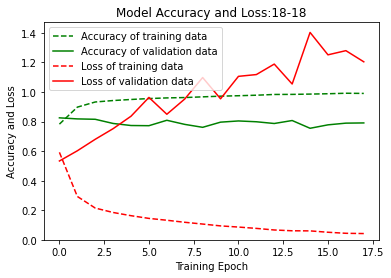


--- Check against test data ---

6584/6584 [==============================] - 1s 106us/step

Accuracy on test data: 0.86

Loss on test data: 0.69

--- Confusion matrix for test data ---



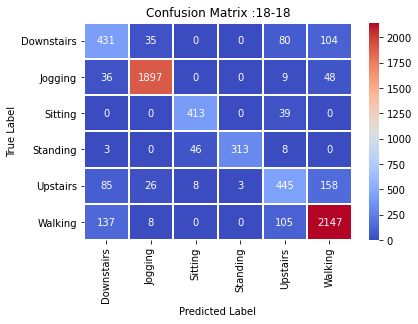


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.62      0.66      0.64       650
           1       0.96      0.95      0.96      1990
           2       0.88      0.91      0.90       452
           3       0.99      0.85      0.91       370
           4       0.65      0.61      0.63       725
           5       0.87      0.90      0.88      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 287us/step - loss: 0.6214 - accuracy: 0.7733 - val_loss: 0.5697 - val_accuracy: 0.8076
Epoch 2/25
16694/16694 [==============================] - 5s 271us/step - loss: 0.3091 - accuracy: 0.8895 - val_loss: 0.5951 - val_accuracy: 0.8218
Epoch 3/25
16694/16694 [==============================] - 5s 

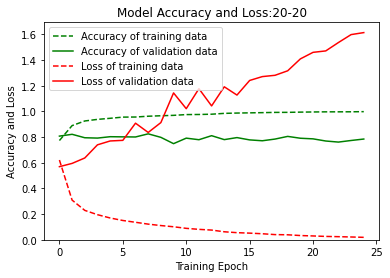


--- Check against test data ---

6584/6584 [==============================] - 1s 92us/step

Accuracy on test data: 0.86

Loss on test data: 0.79

--- Confusion matrix for test data ---



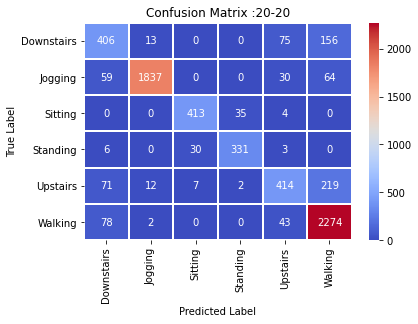


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.65      0.62      0.64       650
           1       0.99      0.92      0.95      1990
           2       0.92      0.91      0.92       452
           3       0.90      0.89      0.90       370
           4       0.73      0.57      0.64       725
           5       0.84      0.95      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 342us/step - loss: 0.7377 - accuracy: 0.7457 - val_loss: 0.6331 - val_accuracy: 0.8160
Epoch 2/25
16694/16694 [==============================] - 5s 321us/step - loss: 0.4941 - accuracy: 0.8243 - val_loss: 0.5850 - val_accuracy: 0.8136
Epoch 3/25
16694/16694 [==============================] - 5s 

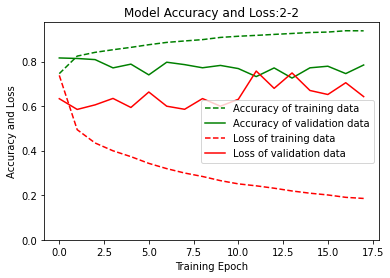


--- Check against test data ---

6584/6584 [==============================] - 1s 104us/step

Accuracy on test data: 0.81

Loss on test data: 1.26

--- Confusion matrix for test data ---



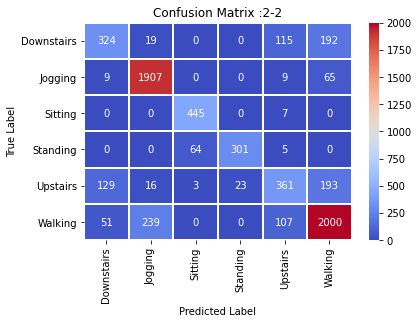


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.63      0.50      0.56       650
           1       0.87      0.96      0.91      1990
           2       0.87      0.98      0.92       452
           3       0.93      0.81      0.87       370
           4       0.60      0.50      0.54       725
           5       0.82      0.83      0.83      2397

    accuracy                           0.81      6584
   macro avg       0.79      0.76      0.77      6584
weighted avg       0.80      0.81      0.80      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 336us/step - loss: 0.6557 - accuracy: 0.7664 - val_loss: 0.5241 - val_accuracy: 0.8232
Epoch 2/25
16694/16694 [==============================] - 5s 328us/step - loss: 0.3427 - accuracy: 0.8864 - val_loss: 0.5888 - val_accuracy: 0.7875
Epoch 3/25
16694/16694 [==============================] - 5s 32

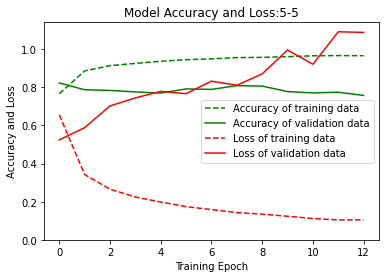


--- Check against test data ---

6584/6584 [==============================] - 1s 90us/step

Accuracy on test data: 0.83

Loss on test data: 0.84

--- Confusion matrix for test data ---



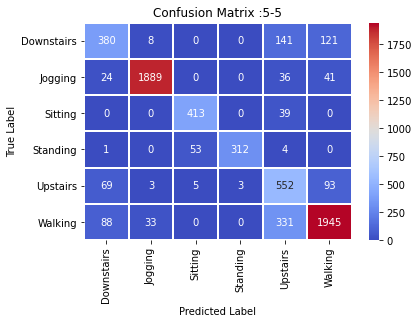


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.68      0.58      0.63       650
           1       0.98      0.95      0.96      1990
           2       0.88      0.91      0.89       452
           3       0.99      0.84      0.91       370
           4       0.50      0.76      0.60       725
           5       0.88      0.81      0.85      2397

    accuracy                           0.83      6584
   macro avg       0.82      0.81      0.81      6584
weighted avg       0.85      0.83      0.84      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 330us/step - loss: 0.6060 - accuracy: 0.7788 - val_loss: 0.5379 - val_accuracy: 0.8170
Epoch 2/25
16694/16694 [==============================] - 5s 320us/step - loss: 0.2955 - accuracy: 0.9013 - val_loss: 0.5704 - val_accuracy: 0.8225
Epoch 3/25
16694/16694 [==============================] - 5s 31

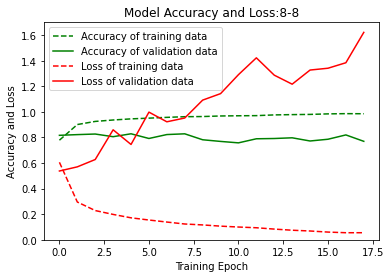


--- Check against test data ---

6584/6584 [==============================] - 1s 80us/step

Accuracy on test data: 0.86

Loss on test data: 0.61

--- Confusion matrix for test data ---



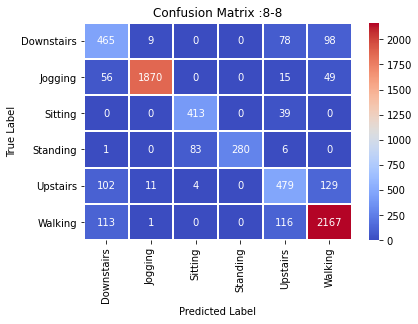


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.63      0.72      0.67       650
           1       0.99      0.94      0.96      1990
           2       0.83      0.91      0.87       452
           3       1.00      0.76      0.86       370
           4       0.65      0.66      0.66       725
           5       0.89      0.90      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.82      0.82      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 296us/step - loss: 0.5995 - accuracy: 0.7798 - val_loss: 0.5507 - val_accuracy: 0.8318
Epoch 2/25
16694/16694 [==============================] - 5s 293us/step - loss: 0.2908 - accuracy: 0.9025 - val_loss: 0.5938 - val_accuracy: 0.8184
Epoch 3/25
16694/16694 [==============================] - 5s 28

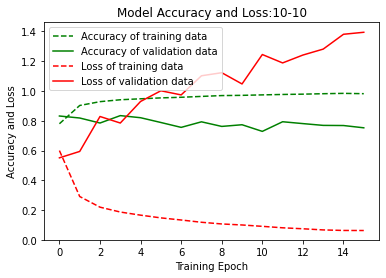


--- Check against test data ---

6584/6584 [==============================] - 1s 102us/step

Accuracy on test data: 0.86

Loss on test data: 0.57

--- Confusion matrix for test data ---



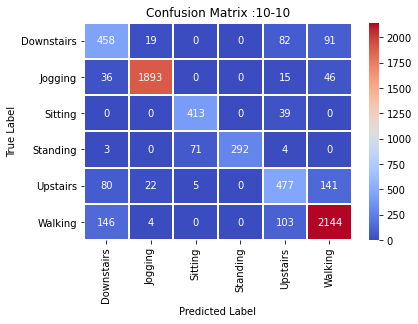


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.63      0.70      0.67       650
           1       0.98      0.95      0.96      1990
           2       0.84      0.91      0.88       452
           3       1.00      0.79      0.88       370
           4       0.66      0.66      0.66       725
           5       0.89      0.89      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.82      0.82      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 289us/step - loss: 0.5892 - accuracy: 0.7848 - val_loss: 0.5083 - val_accuracy: 0.8342
Epoch 2/25
16694/16694 [==============================] - 5s 297us/step - loss: 0.2912 - accuracy: 0.9001 - val_loss: 0.5845 - val_accuracy: 0.8210
Epoch 3/25
16694/16694 [==============================] - 5s 

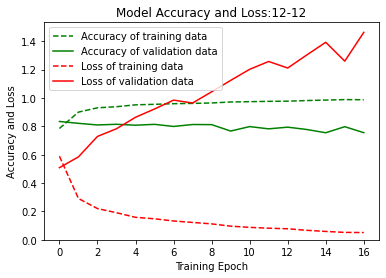


--- Check against test data ---

6584/6584 [==============================] - 1s 123us/step

Accuracy on test data: 0.86

Loss on test data: 0.66

--- Confusion matrix for test data ---



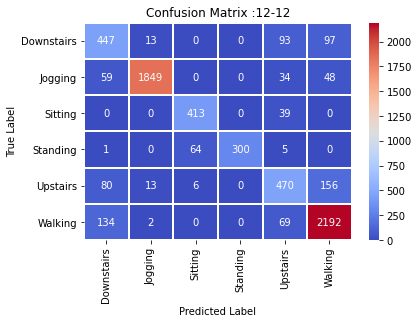


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.62      0.69      0.65       650
           1       0.99      0.93      0.96      1990
           2       0.86      0.91      0.88       452
           3       1.00      0.81      0.90       370
           4       0.66      0.65      0.66       725
           5       0.88      0.91      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.82      0.82      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 291us/step - loss: 0.5765 - accuracy: 0.7908 - val_loss: 0.5429 - val_accuracy: 0.8158
Epoch 2/25
16694/16694 [==============================] - 5s 282us/step - loss: 0.2941 - accuracy: 0.8984 - val_loss: 0.5860 - val_accuracy: 0.8045
Epoch 3/25
16694/16694 [==============================] - 5s 

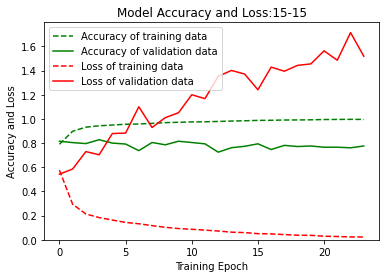


--- Check against test data ---

6584/6584 [==============================] - 1s 117us/step

Accuracy on test data: 0.86

Loss on test data: 0.76

--- Confusion matrix for test data ---



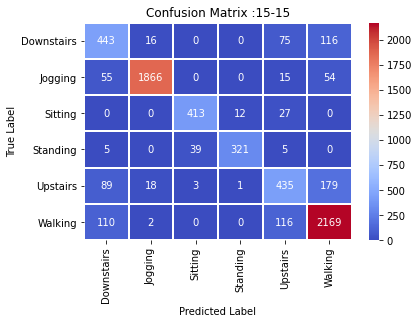


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.63      0.68      0.66       650
           1       0.98      0.94      0.96      1990
           2       0.91      0.91      0.91       452
           3       0.96      0.87      0.91       370
           4       0.65      0.60      0.62       725
           5       0.86      0.90      0.88      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.82      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 355us/step - loss: 0.5737 - accuracy: 0.7891 - val_loss: 0.5513 - val_accuracy: 0.8184
Epoch 2/25
16694/16694 [==============================] - 6s 343us/step - loss: 0.2835 - accuracy: 0.9045 - val_loss: 0.6075 - val_accuracy: 0.8285
Epoch 3/25
16694/16694 [==============================] - 6s 

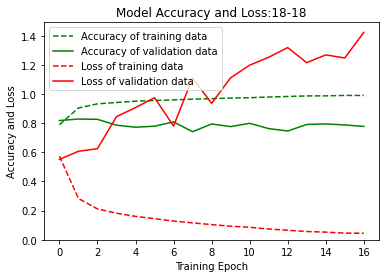


--- Check against test data ---

6584/6584 [==============================] - 1s 132us/step

Accuracy on test data: 0.86

Loss on test data: 0.64

--- Confusion matrix for test data ---



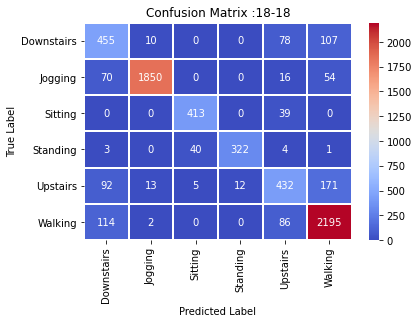


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.62      0.70      0.66       650
           1       0.99      0.93      0.96      1990
           2       0.90      0.91      0.91       452
           3       0.96      0.87      0.91       370
           4       0.66      0.60      0.63       725
           5       0.87      0.92      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.82      0.83      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 7s 403us/step - loss: 0.5869 - accuracy: 0.7867 - val_loss: 0.5111 - val_accuracy: 0.8275
Epoch 2/25
16694/16694 [==============================] - 6s 378us/step - loss: 0.2888 - accuracy: 0.9005 - val_loss: 0.6094 - val_accuracy: 0.8287
Epoch 3/25
16694/16694 [==============================] - 6s 

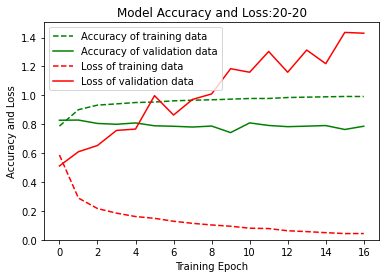


--- Check against test data ---

6584/6584 [==============================] - 1s 114us/step

Accuracy on test data: 0.86

Loss on test data: 0.68

--- Confusion matrix for test data ---



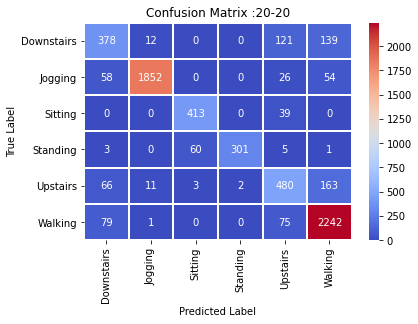


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.65      0.58      0.61       650
           1       0.99      0.93      0.96      1990
           2       0.87      0.91      0.89       452
           3       0.99      0.81      0.89       370
           4       0.64      0.66      0.65       725
           5       0.86      0.94      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 355us/step - loss: 0.7372 - accuracy: 0.7426 - val_loss: 0.6517 - val_accuracy: 0.7822
Epoch 2/25
16694/16694 [==============================] - 5s 321us/step - loss: 0.4972 - accuracy: 0.8217 - val_loss: 0.6026 - val_accuracy: 0.8055
Epoch 3/25
16694/16694 [==============================] - 6s 

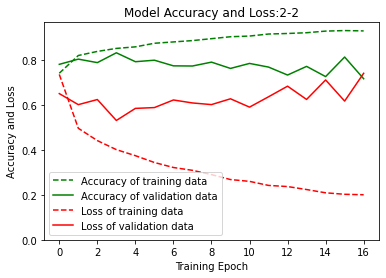


--- Check against test data ---

6584/6584 [==============================] - 1s 84us/step

Accuracy on test data: 0.80

Loss on test data: 1.27

--- Confusion matrix for test data ---



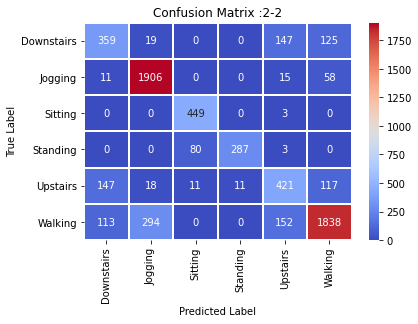


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.57      0.55      0.56       650
           1       0.85      0.96      0.90      1990
           2       0.83      0.99      0.91       452
           3       0.96      0.78      0.86       370
           4       0.57      0.58      0.57       725
           5       0.86      0.77      0.81      2397

    accuracy                           0.80      6584
   macro avg       0.77      0.77      0.77      6584
weighted avg       0.80      0.80      0.80      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 360us/step - loss: 0.6691 - accuracy: 0.7643 - val_loss: 0.5440 - val_accuracy: 0.8385
Epoch 2/25
16694/16694 [==============================] - 6s 348us/step - loss: 0.3468 - accuracy: 0.8829 - val_loss: 0.5382 - val_accuracy: 0.8225
Epoch 3/25
16694/16694 [==============================] - 6s 35

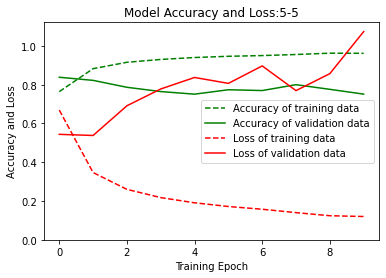


--- Check against test data ---

6584/6584 [==============================] - 1s 86us/step

Accuracy on test data: 0.83

Loss on test data: 0.75

--- Confusion matrix for test data ---



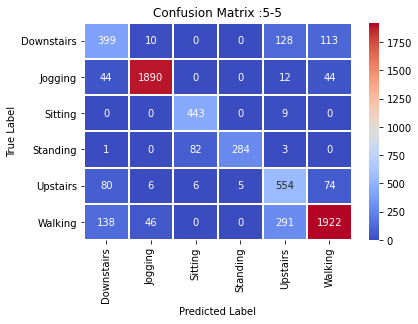


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.60      0.61      0.61       650
           1       0.97      0.95      0.96      1990
           2       0.83      0.98      0.90       452
           3       0.98      0.77      0.86       370
           4       0.56      0.76      0.64       725
           5       0.89      0.80      0.84      2397

    accuracy                           0.83      6584
   macro avg       0.81      0.81      0.80      6584
weighted avg       0.85      0.83      0.84      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 323us/step - loss: 0.5994 - accuracy: 0.7831 - val_loss: 0.5239 - val_accuracy: 0.8208
Epoch 2/25
16694/16694 [==============================] - 5s 317us/step - loss: 0.2957 - accuracy: 0.8988 - val_loss: 0.6508 - val_accuracy: 0.7995
Epoch 3/25
16694/16694 [==============================] - 5s 31

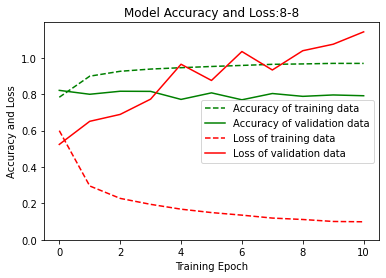


--- Check against test data ---

6584/6584 [==============================] - 1s 86us/step

Accuracy on test data: 0.86

Loss on test data: 0.51

--- Confusion matrix for test data ---



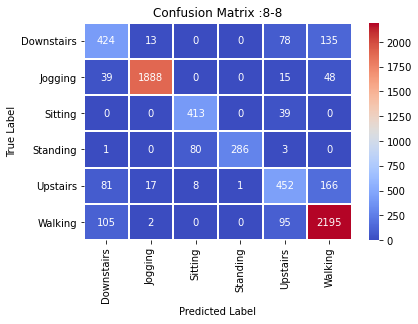


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       650
           1       0.98      0.95      0.97      1990
           2       0.82      0.91      0.87       452
           3       1.00      0.77      0.87       370
           4       0.66      0.62      0.64       725
           5       0.86      0.92      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 329us/step - loss: 0.5844 - accuracy: 0.7911 - val_loss: 0.5244 - val_accuracy: 0.8263
Epoch 2/25
16694/16694 [==============================] - 5s 324us/step - loss: 0.2864 - accuracy: 0.9021 - val_loss: 0.5990 - val_accuracy: 0.8299
Epoch 3/25
16694/16694 [==============================] - 5s 32

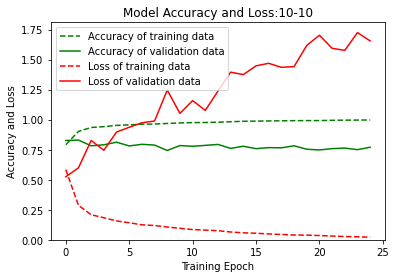


--- Check against test data ---

6584/6584 [==============================] - 1s 91us/step

Accuracy on test data: 0.87

Loss on test data: 0.76

--- Confusion matrix for test data ---



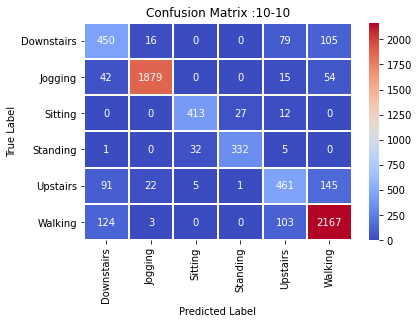


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.64      0.69      0.66       650
           1       0.98      0.94      0.96      1990
           2       0.92      0.91      0.92       452
           3       0.92      0.90      0.91       370
           4       0.68      0.64      0.66       725
           5       0.88      0.90      0.89      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.83      0.83      6584
weighted avg       0.87      0.87      0.87      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 319us/step - loss: 0.5705 - accuracy: 0.7948 - val_loss: 0.5348 - val_accuracy: 0.8232
Epoch 2/25
16694/16694 [==============================] - 5s 315us/step - loss: 0.2774 - accuracy: 0.9054 - val_loss: 0.6550 - val_accuracy: 0.8103
Epoch 3/25
16694/16694 [==============================] - 5s 

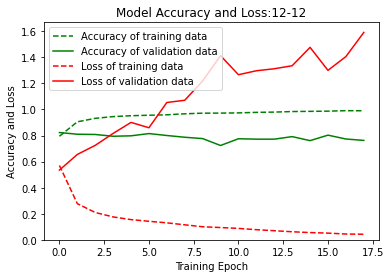


--- Check against test data ---

6584/6584 [==============================] - 1s 84us/step

Accuracy on test data: 0.86

Loss on test data: 0.68

--- Confusion matrix for test data ---



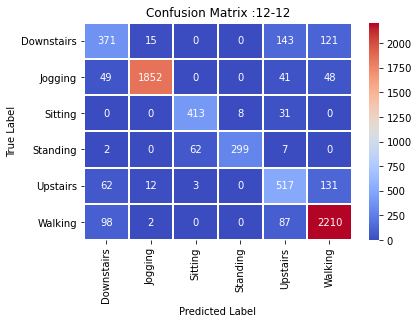


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.64      0.57      0.60       650
           1       0.98      0.93      0.96      1990
           2       0.86      0.91      0.89       452
           3       0.97      0.81      0.88       370
           4       0.63      0.71      0.67       725
           5       0.88      0.92      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 331us/step - loss: 0.6197 - accuracy: 0.7697 - val_loss: 0.5519 - val_accuracy: 0.8201
Epoch 2/25
16694/16694 [==============================] - 5s 323us/step - loss: 0.2993 - accuracy: 0.8966 - val_loss: 0.5763 - val_accuracy: 0.8196
Epoch 3/25
16694/16694 [==============================] - 5s 

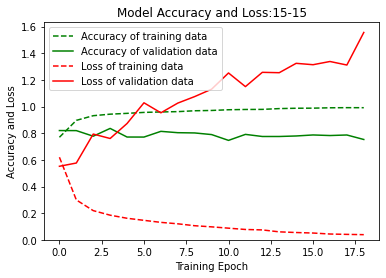


--- Check against test data ---

6584/6584 [==============================] - 1s 97us/step

Accuracy on test data: 0.86

Loss on test data: 0.69

--- Confusion matrix for test data ---



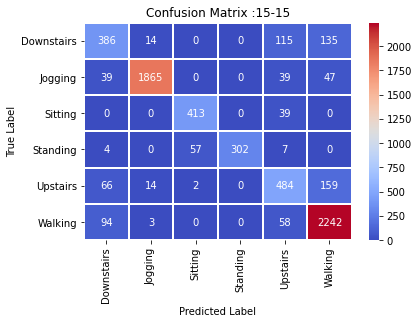


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.66      0.59      0.62       650
           1       0.98      0.94      0.96      1990
           2       0.88      0.91      0.89       452
           3       1.00      0.82      0.90       370
           4       0.65      0.67      0.66       725
           5       0.87      0.94      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 386us/step - loss: 0.5984 - accuracy: 0.7826 - val_loss: 0.5758 - val_accuracy: 0.8009
Epoch 2/25
16694/16694 [==============================] - 6s 384us/step - loss: 0.2929 - accuracy: 0.8998 - val_loss: 0.6844 - val_accuracy: 0.7827
Epoch 3/25
16694/16694 [==============================] - 7s 

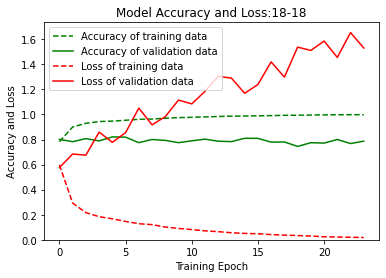


--- Check against test data ---

6584/6584 [==============================] - 1s 96us/step

Accuracy on test data: 0.87

Loss on test data: 0.74

--- Confusion matrix for test data ---



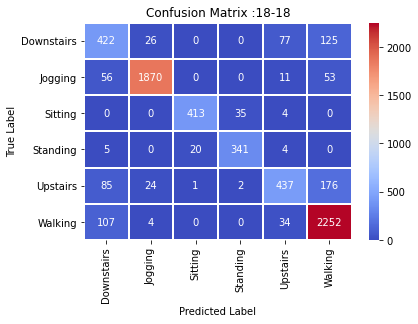


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       650
           1       0.97      0.94      0.96      1990
           2       0.95      0.91      0.93       452
           3       0.90      0.92      0.91       370
           4       0.77      0.60      0.68       725
           5       0.86      0.94      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.85      0.83      0.84      6584
weighted avg       0.87      0.87      0.87      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 386us/step - loss: 0.5800 - accuracy: 0.7932 - val_loss: 0.5779 - val_accuracy: 0.8165
Epoch 2/25
16694/16694 [==============================] - 7s 391us/step - loss: 0.2959 - accuracy: 0.8954 - val_loss: 0.5978 - val_accuracy: 0.8033
Epoch 3/25
16694/16694 [==============================] - 6s 

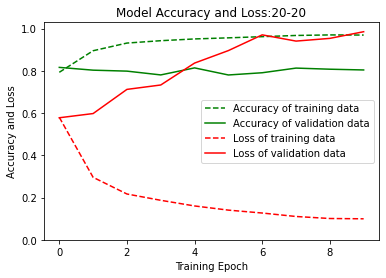


--- Check against test data ---

6584/6584 [==============================] - 1s 115us/step

Accuracy on test data: 0.85

Loss on test data: 0.60

--- Confusion matrix for test data ---



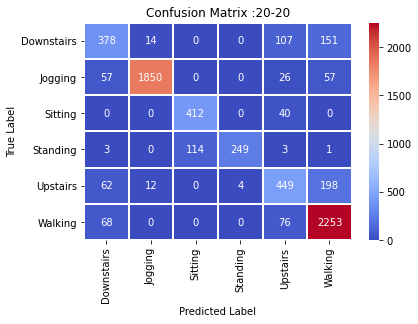


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.67      0.58      0.62       650
           1       0.99      0.93      0.96      1990
           2       0.78      0.91      0.84       452
           3       0.98      0.67      0.80       370
           4       0.64      0.62      0.63       725
           5       0.85      0.94      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.78      0.79      6584
weighted avg       0.85      0.85      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 343us/step - loss: 0.7484 - accuracy: 0.7380 - val_loss: 0.6632 - val_accuracy: 0.7856
Epoch 2/25
16694/16694 [==============================] - 6s 346us/step - loss: 0.4952 - accuracy: 0.8248 - val_loss: 0.5969 - val_accuracy: 0.8131
Epoch 3/25
16694/16694 [==============================] - 6s 

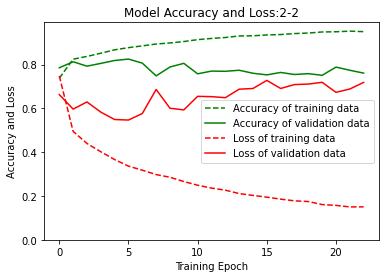


--- Check against test data ---

6584/6584 [==============================] - 1s 84us/step

Accuracy on test data: 0.81

Loss on test data: 1.46

--- Confusion matrix for test data ---



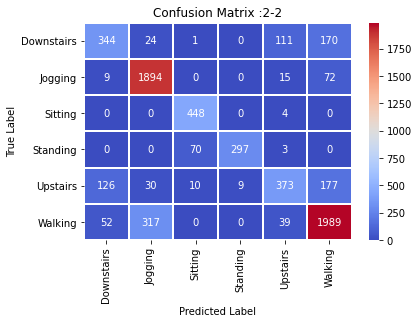


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.65      0.53      0.58       650
           1       0.84      0.95      0.89      1990
           2       0.85      0.99      0.91       452
           3       0.97      0.80      0.88       370
           4       0.68      0.51      0.59       725
           5       0.83      0.83      0.83      2397

    accuracy                           0.81      6584
   macro avg       0.80      0.77      0.78      6584
weighted avg       0.81      0.81      0.80      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 381us/step - loss: 0.6480 - accuracy: 0.7679 - val_loss: 0.5573 - val_accuracy: 0.8167
Epoch 2/25
16694/16694 [==============================] - 6s 372us/step - loss: 0.3424 - accuracy: 0.8850 - val_loss: 0.6437 - val_accuracy: 0.7851
Epoch 3/25
16694/16694 [==============================] - 6s 36

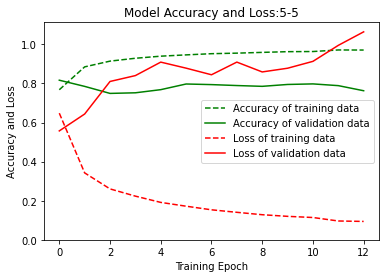


--- Check against test data ---

6584/6584 [==============================] - 1s 108us/step

Accuracy on test data: 0.83

Loss on test data: 0.76

--- Confusion matrix for test data ---



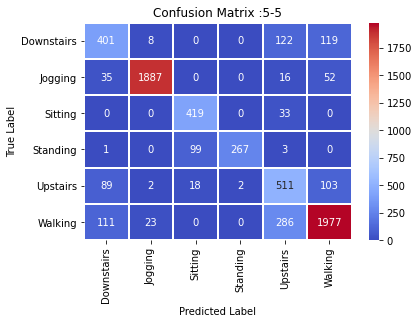


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.63      0.62      0.62       650
           1       0.98      0.95      0.97      1990
           2       0.78      0.93      0.85       452
           3       0.99      0.72      0.84       370
           4       0.53      0.70      0.60       725
           5       0.88      0.82      0.85      2397

    accuracy                           0.83      6584
   macro avg       0.80      0.79      0.79      6584
weighted avg       0.85      0.83      0.83      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 355us/step - loss: 0.5925 - accuracy: 0.7895 - val_loss: 0.5078 - val_accuracy: 0.8289
Epoch 2/25
16694/16694 [==============================] - 6s 346us/step - loss: 0.2903 - accuracy: 0.9027 - val_loss: 0.5678 - val_accuracy: 0.8270
Epoch 3/25
16694/16694 [==============================] - 6s 34

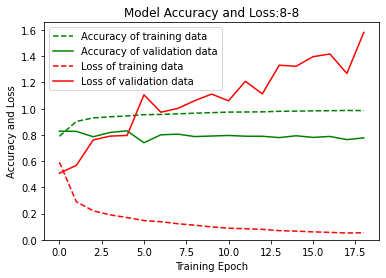


--- Check against test data ---

6584/6584 [==============================] - 1s 92us/step

Accuracy on test data: 0.86

Loss on test data: 0.61

--- Confusion matrix for test data ---



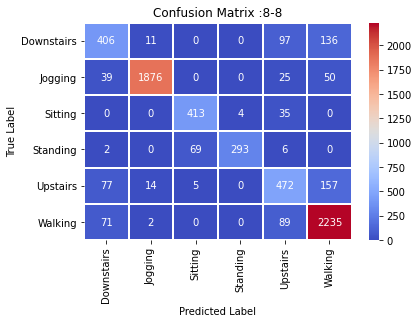


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.68      0.62      0.65       650
           1       0.99      0.94      0.96      1990
           2       0.85      0.91      0.88       452
           3       0.99      0.79      0.88       370
           4       0.65      0.65      0.65       725
           5       0.87      0.93      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 7s 391us/step - loss: 0.5869 - accuracy: 0.7914 - val_loss: 0.5073 - val_accuracy: 0.8371
Epoch 2/25
16694/16694 [==============================] - 6s 382us/step - loss: 0.2811 - accuracy: 0.9044 - val_loss: 0.5960 - val_accuracy: 0.8148
Epoch 3/25
16694/16694 [==============================] - 6s 37

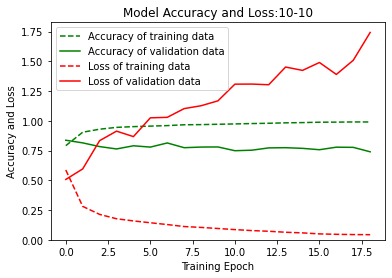


--- Check against test data ---

6584/6584 [==============================] - 1s 120us/step

Accuracy on test data: 0.85

Loss on test data: 0.69

--- Confusion matrix for test data ---



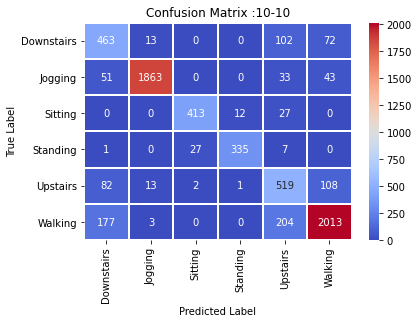


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.60      0.71      0.65       650
           1       0.98      0.94      0.96      1990
           2       0.93      0.91      0.92       452
           3       0.96      0.91      0.93       370
           4       0.58      0.72      0.64       725
           5       0.90      0.84      0.87      2397

    accuracy                           0.85      6584
   macro avg       0.83      0.84      0.83      6584
weighted avg       0.87      0.85      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 377us/step - loss: 0.5535 - accuracy: 0.8046 - val_loss: 0.5508 - val_accuracy: 0.8270
Epoch 2/25
16694/16694 [==============================] - 6s 372us/step - loss: 0.2822 - accuracy: 0.9045 - val_loss: 0.6601 - val_accuracy: 0.7918
Epoch 3/25
16694/16694 [==============================] - 6s 

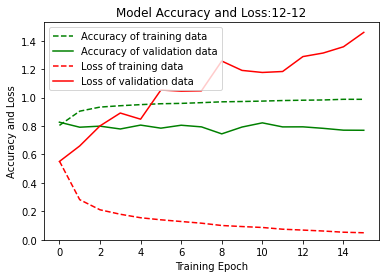


--- Check against test data ---

6584/6584 [==============================] - 1s 100us/step

Accuracy on test data: 0.87

Loss on test data: 0.59

--- Confusion matrix for test data ---



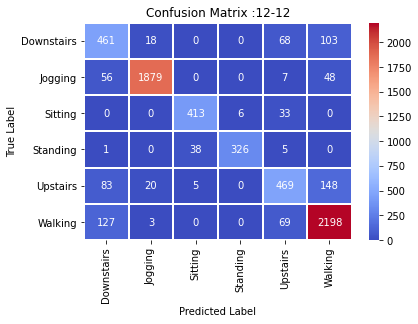


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.63      0.71      0.67       650
           1       0.98      0.94      0.96      1990
           2       0.91      0.91      0.91       452
           3       0.98      0.88      0.93       370
           4       0.72      0.65      0.68       725
           5       0.88      0.92      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.85      0.84      0.84      6584
weighted avg       0.88      0.87      0.87      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 376us/step - loss: 0.5902 - accuracy: 0.7833 - val_loss: 0.5294 - val_accuracy: 0.8292
Epoch 2/25
16694/16694 [==============================] - 6s 371us/step - loss: 0.2884 - accuracy: 0.9003 - val_loss: 0.5959 - val_accuracy: 0.8208
Epoch 3/25
16694/16694 [==============================] - 6s 

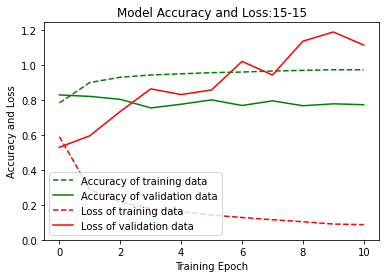


--- Check against test data ---

6584/6584 [==============================] - 1s 100us/step

Accuracy on test data: 0.85

Loss on test data: 0.58

--- Confusion matrix for test data ---



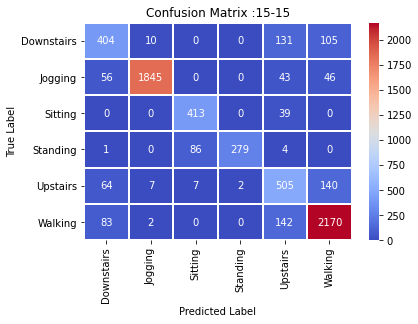


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       650
           1       0.99      0.93      0.96      1990
           2       0.82      0.91      0.86       452
           3       0.99      0.75      0.86       370
           4       0.58      0.70      0.64       725
           5       0.88      0.91      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.80      0.81      6584
weighted avg       0.86      0.85      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 8s 460us/step - loss: 0.5621 - accuracy: 0.7905 - val_loss: 0.5624 - val_accuracy: 0.8129
Epoch 2/25
16694/16694 [==============================] - 7s 445us/step - loss: 0.2755 - accuracy: 0.9060 - val_loss: 0.6627 - val_accuracy: 0.7935
Epoch 3/25
16694/16694 [==============================] - 7s 

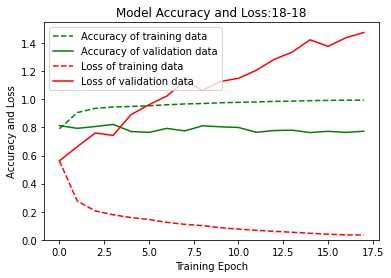


--- Check against test data ---

6584/6584 [==============================] - 1s 116us/step

Accuracy on test data: 0.86

Loss on test data: 0.70

--- Confusion matrix for test data ---



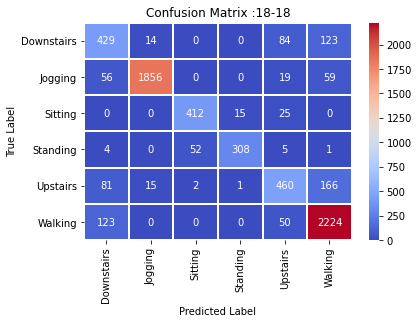


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.62      0.66      0.64       650
           1       0.98      0.93      0.96      1990
           2       0.88      0.91      0.90       452
           3       0.95      0.83      0.89       370
           4       0.72      0.63      0.67       725
           5       0.86      0.93      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.84      0.82      0.82      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 378us/step - loss: 0.5904 - accuracy: 0.7838 - val_loss: 0.5728 - val_accuracy: 0.8088
Epoch 2/25
16694/16694 [==============================] - 6s 365us/step - loss: 0.2957 - accuracy: 0.8977 - val_loss: 0.6113 - val_accuracy: 0.8237
Epoch 3/25
16694/16694 [==============================] - 6s 

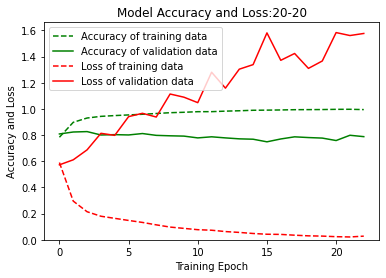


--- Check against test data ---

6584/6584 [==============================] - 1s 109us/step

Accuracy on test data: 0.85

Loss on test data: 0.78

--- Confusion matrix for test data ---



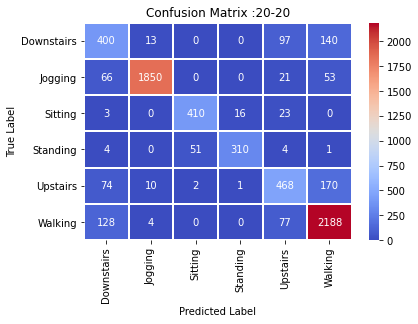


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.59      0.62      0.60       650
           1       0.99      0.93      0.96      1990
           2       0.89      0.91      0.90       452
           3       0.95      0.84      0.89       370
           4       0.68      0.65      0.66       725
           5       0.86      0.91      0.88      2397

    accuracy                           0.85      6584
   macro avg       0.82      0.81      0.82      6584
weighted avg       0.86      0.85      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 5s 320us/step - loss: 0.7222 - accuracy: 0.7494 - val_loss: 0.6293 - val_accuracy: 0.8170
Epoch 2/25
16694/16694 [==============================] - 5s 314us/step - loss: 0.4941 - accuracy: 0.8239 - val_loss: 0.6280 - val_accuracy: 0.7980
Epoch 3/25
16694/16694 [==============================] - 5s 

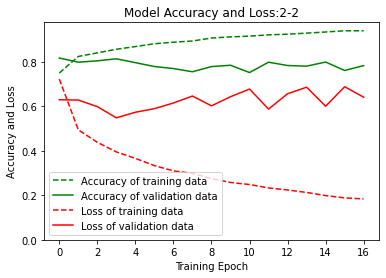


--- Check against test data ---

6584/6584 [==============================] - 1s 101us/step

Accuracy on test data: 0.81

Loss on test data: 1.29

--- Confusion matrix for test data ---



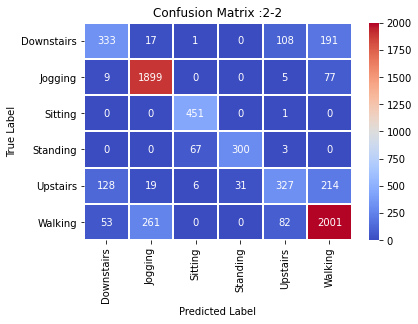


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.64      0.51      0.57       650
           1       0.86      0.95      0.91      1990
           2       0.86      1.00      0.92       452
           3       0.91      0.81      0.86       370
           4       0.62      0.45      0.52       725
           5       0.81      0.83      0.82      2397

    accuracy                           0.81      6584
   macro avg       0.78      0.76      0.77      6584
weighted avg       0.80      0.81      0.80      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 349us/step - loss: 0.6615 - accuracy: 0.7642 - val_loss: 0.5771 - val_accuracy: 0.8131
Epoch 2/25
16694/16694 [==============================] - 5s 309us/step - loss: 0.3462 - accuracy: 0.8817 - val_loss: 0.5204 - val_accuracy: 0.8196
Epoch 3/25
16694/16694 [==============================] - 7s 43

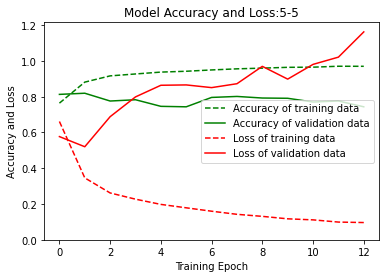


--- Check against test data ---

6584/6584 [==============================] - 1s 105us/step

Accuracy on test data: 0.83

Loss on test data: 0.74

--- Confusion matrix for test data ---



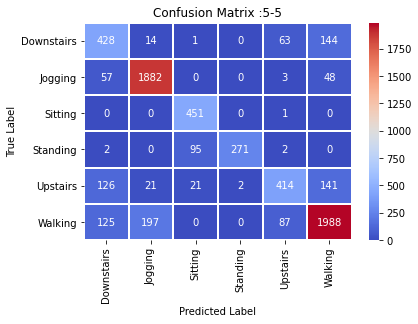


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.58      0.66      0.62       650
           1       0.89      0.95      0.92      1990
           2       0.79      1.00      0.88       452
           3       0.99      0.73      0.84       370
           4       0.73      0.57      0.64       725
           5       0.86      0.83      0.84      2397

    accuracy                           0.83      6584
   macro avg       0.81      0.79      0.79      6584
weighted avg       0.83      0.83      0.82      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 7s 420us/step - loss: 0.6383 - accuracy: 0.7686 - val_loss: 0.5902 - val_accuracy: 0.8167
Epoch 2/25
16694/16694 [==============================] - 7s 406us/step - loss: 0.3059 - accuracy: 0.8953 - val_loss: 0.5970 - val_accuracy: 0.8203
Epoch 3/25
16694/16694 [==============================] - 7s 40

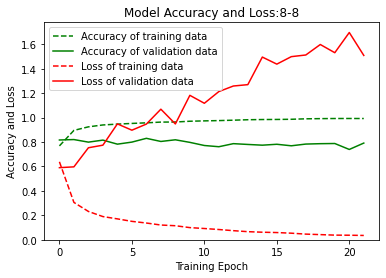


--- Check against test data ---

6584/6584 [==============================] - 1s 103us/step

Accuracy on test data: 0.86

Loss on test data: 0.67

--- Confusion matrix for test data ---



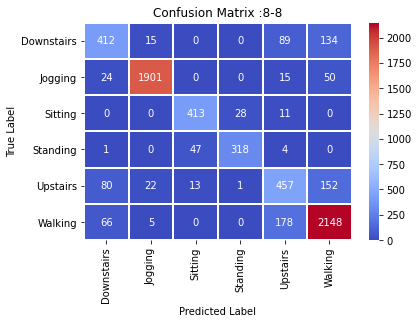


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.71      0.63      0.67       650
           1       0.98      0.96      0.97      1990
           2       0.87      0.91      0.89       452
           3       0.92      0.86      0.89       370
           4       0.61      0.63      0.62       725
           5       0.86      0.90      0.88      2397

    accuracy                           0.86      6584
   macro avg       0.82      0.81      0.82      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 7s 415us/step - loss: 0.5804 - accuracy: 0.7914 - val_loss: 0.5945 - val_accuracy: 0.8179
Epoch 2/25
16694/16694 [==============================] - 7s 398us/step - loss: 0.2805 - accuracy: 0.9027 - val_loss: 0.6695 - val_accuracy: 0.8004
Epoch 3/25
16694/16694 [==============================] - 7s 40

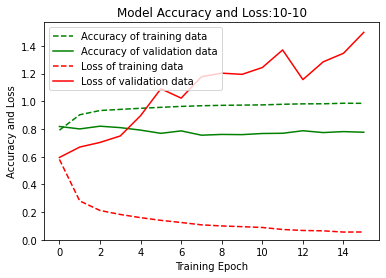


--- Check against test data ---

6584/6584 [==============================] - 1s 113us/step

Accuracy on test data: 0.86

Loss on test data: 0.59

--- Confusion matrix for test data ---



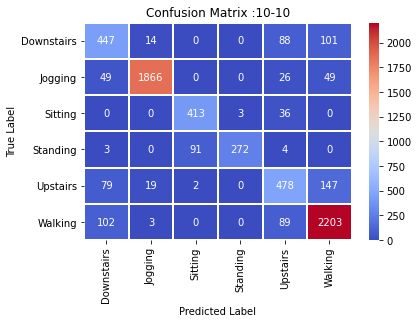


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.66      0.69      0.67       650
           1       0.98      0.94      0.96      1990
           2       0.82      0.91      0.86       452
           3       0.99      0.74      0.84       370
           4       0.66      0.66      0.66       725
           5       0.88      0.92      0.90      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.81      0.82      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 7s 393us/step - loss: 0.5738 - accuracy: 0.7926 - val_loss: 0.5102 - val_accuracy: 0.8349
Epoch 2/25
16694/16694 [==============================] - 6s 376us/step - loss: 0.2827 - accuracy: 0.9004 - val_loss: 0.5913 - val_accuracy: 0.8155
Epoch 3/25
16694/16694 [==============================] - 6s 

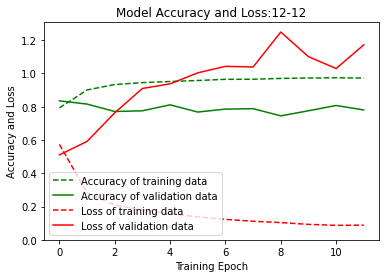


--- Check against test data ---

6584/6584 [==============================] - 1s 95us/step

Accuracy on test data: 0.84

Loss on test data: 0.66

--- Confusion matrix for test data ---



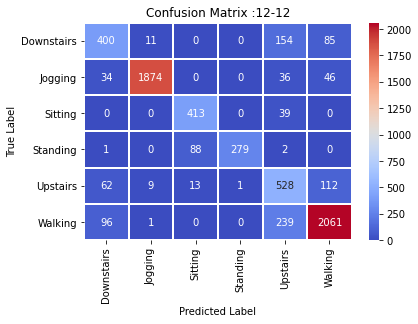


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.67      0.62      0.64       650
           1       0.99      0.94      0.96      1990
           2       0.80      0.91      0.86       452
           3       1.00      0.75      0.86       370
           4       0.53      0.73      0.61       725
           5       0.89      0.86      0.88      2397

    accuracy                           0.84      6584
   macro avg       0.81      0.80      0.80      6584
weighted avg       0.86      0.84      0.85      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 375us/step - loss: 0.5663 - accuracy: 0.7981 - val_loss: 0.5190 - val_accuracy: 0.8361
Epoch 2/25
16694/16694 [==============================] - 6s 379us/step - loss: 0.2736 - accuracy: 0.9084 - val_loss: 0.5641 - val_accuracy: 0.8174
Epoch 3/25
16694/16694 [==============================] - 7s 

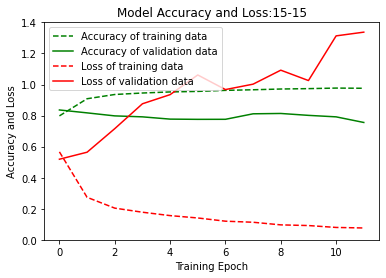


--- Check against test data ---

6584/6584 [==============================] - 1s 116us/step

Accuracy on test data: 0.84

Loss on test data: 0.69

--- Confusion matrix for test data ---



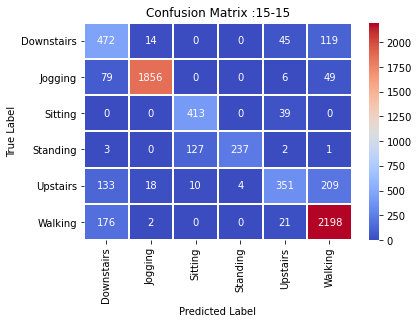


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.55      0.73      0.62       650
           1       0.98      0.93      0.96      1990
           2       0.75      0.91      0.82       452
           3       0.98      0.64      0.78       370
           4       0.76      0.48      0.59       725
           5       0.85      0.92      0.88      2397

    accuracy                           0.84      6584
   macro avg       0.81      0.77      0.78      6584
weighted avg       0.85      0.84      0.84      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 7s 444us/step - loss: 0.5723 - accuracy: 0.7925 - val_loss: 0.5592 - val_accuracy: 0.8136
Epoch 2/25
16694/16694 [==============================] - 7s 443us/step - loss: 0.2893 - accuracy: 0.9013 - val_loss: 0.5674 - val_accuracy: 0.8316
Epoch 3/25
16694/16694 [==============================] - 7s 

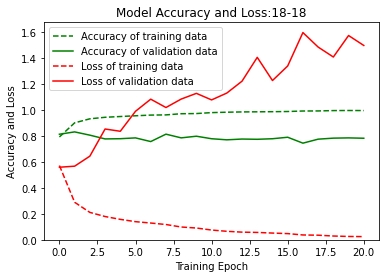


--- Check against test data ---

6584/6584 [==============================] - 1s 117us/step

Accuracy on test data: 0.86

Loss on test data: 0.74

--- Confusion matrix for test data ---



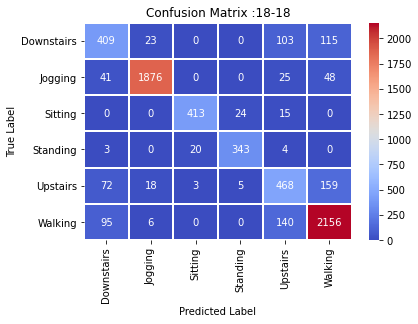


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.66      0.63      0.64       650
           1       0.98      0.94      0.96      1990
           2       0.95      0.91      0.93       452
           3       0.92      0.93      0.92       370
           4       0.62      0.65      0.63       725
           5       0.87      0.90      0.88      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.83      0.83      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 352us/step - loss: 0.5823 - accuracy: 0.7874 - val_loss: 0.5509 - val_accuracy: 0.8213
Epoch 2/25
16694/16694 [==============================] - 7s 403us/step - loss: 0.2870 - accuracy: 0.9027 - val_loss: 0.6224 - val_accuracy: 0.8093
Epoch 3/25
16694/16694 [==============================] - 7s 

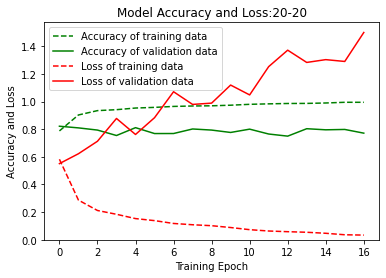


--- Check against test data ---

6584/6584 [==============================] - 1s 111us/step

Accuracy on test data: 0.86

Loss on test data: 0.68

--- Confusion matrix for test data ---



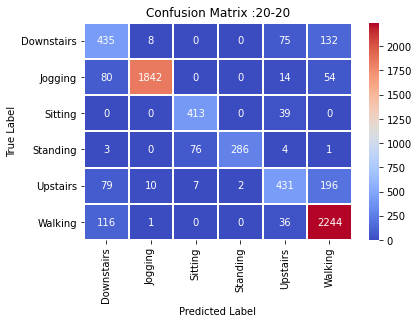


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       650
           1       0.99      0.93      0.96      1990
           2       0.83      0.91      0.87       452
           3       0.99      0.77      0.87       370
           4       0.72      0.59      0.65       725
           5       0.85      0.94      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.80      0.81      6584
weighted avg       0.86      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 6s 388us/step - loss: 0.7507 - accuracy: 0.7361 - val_loss: 0.6431 - val_accuracy: 0.8028
Epoch 2/25
16694/16694 [==============================] - 6s 380us/step - loss: 0.4953 - accuracy: 0.8213 - val_loss: 0.5891 - val_accuracy: 0.8316
Epoch 3/25
16694/16694 [==============================] - 7s 

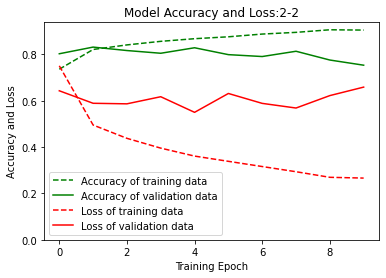


--- Check against test data ---

6584/6584 [==============================] - 1s 92us/step

Accuracy on test data: 0.80

Loss on test data: 1.05

--- Confusion matrix for test data ---



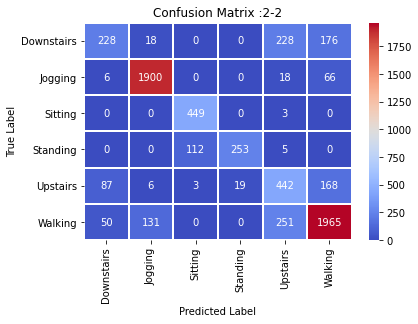


--- Classification report for test data 2:2---

              precision    recall  f1-score   support

           0       0.61      0.35      0.45       650
           1       0.92      0.95      0.94      1990
           2       0.80      0.99      0.88       452
           3       0.93      0.68      0.79       370
           4       0.47      0.61      0.53       725
           5       0.83      0.82      0.82      2397

    accuracy                           0.80      6584
   macro avg       0.76      0.74      0.74      6584
weighted avg       0.80      0.80      0.79      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 7s 425us/step - loss: 0.6497 - accuracy: 0.7710 - val_loss: 0.5974 - val_accuracy: 0.8033
Epoch 2/25
16694/16694 [==============================] - 7s 410us/step - loss: 0.3427 - accuracy: 0.8836 - val_loss: 0.6766 - val_accuracy: 0.7537
Epoch 3/25
16694/16694 [==============================] - 7s 41

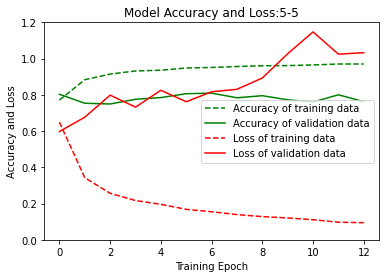


--- Check against test data ---

6584/6584 [==============================] - 1s 97us/step

Accuracy on test data: 0.83

Loss on test data: 0.71

--- Confusion matrix for test data ---



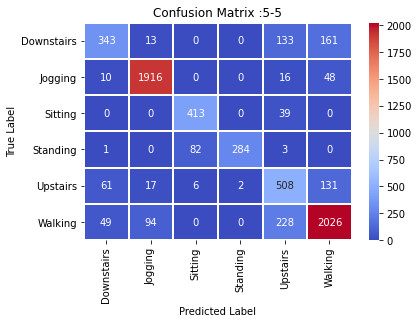


--- Classification report for test data 5:5---

              precision    recall  f1-score   support

           0       0.74      0.53      0.62       650
           1       0.94      0.96      0.95      1990
           2       0.82      0.91      0.87       452
           3       0.99      0.77      0.87       370
           4       0.55      0.70      0.62       725
           5       0.86      0.85      0.85      2397

    accuracy                           0.83      6584
   macro avg       0.82      0.79      0.79      6584
weighted avg       0.84      0.83      0.83      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 7s 411us/step - loss: 0.6001 - accuracy: 0.7797 - val_loss: 0.5339 - val_accuracy: 0.8299
Epoch 2/25
16694/16694 [==============================] - 7s 403us/step - loss: 0.2947 - accuracy: 0.8999 - val_loss: 0.6095 - val_accuracy: 0.8153
Epoch 3/25
16694/16694 [==============================] - 7s 40

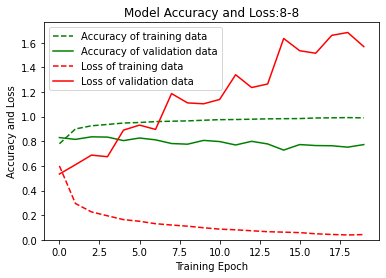


--- Check against test data ---

6584/6584 [==============================] - 1s 91us/step

Accuracy on test data: 0.87

Loss on test data: 0.63

--- Confusion matrix for test data ---



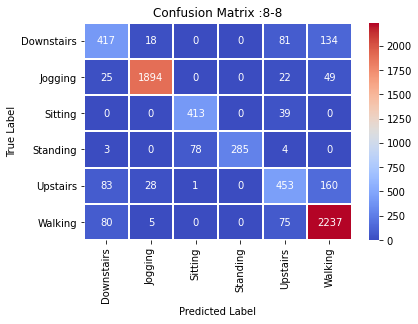


--- Classification report for test data 8:8---

              precision    recall  f1-score   support

           0       0.69      0.64      0.66       650
           1       0.97      0.95      0.96      1990
           2       0.84      0.91      0.88       452
           3       1.00      0.77      0.87       370
           4       0.67      0.62      0.65       725
           5       0.87      0.93      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.87      0.87      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 7s 416us/step - loss: 0.5683 - accuracy: 0.7932 - val_loss: 0.5103 - val_accuracy: 0.8225
Epoch 2/25
16694/16694 [==============================] - 7s 427us/step - loss: 0.2791 - accuracy: 0.9051 - val_loss: 0.7149 - val_accuracy: 0.7973
Epoch 3/25
16694/16694 [==============================] - 7s 40

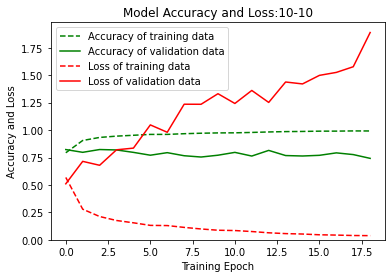


--- Check against test data ---

6584/6584 [==============================] - 1s 97us/step 

Accuracy on test data: 0.86

Loss on test data: 0.71

--- Confusion matrix for test data ---



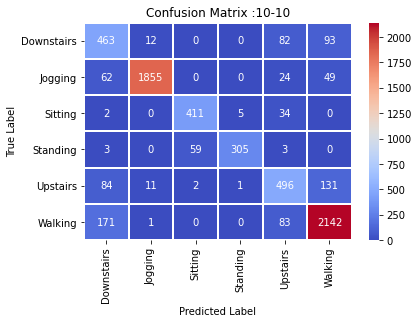


--- Classification report for test data 10:10---

              precision    recall  f1-score   support

           0       0.59      0.71      0.65       650
           1       0.99      0.93      0.96      1990
           2       0.87      0.91      0.89       452
           3       0.98      0.82      0.90       370
           4       0.69      0.68      0.69       725
           5       0.89      0.89      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.83      0.83      6584
weighted avg       0.87      0.86      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 7s 425us/step - loss: 0.5749 - accuracy: 0.7920 - val_loss: 0.6522 - val_accuracy: 0.7964
Epoch 2/25
16694/16694 [==============================] - 7s 401us/step - loss: 0.2811 - accuracy: 0.9042 - val_loss: 0.6308 - val_accuracy: 0.8002
Epoch 3/25
16694/16694 [==============================] - 7s 

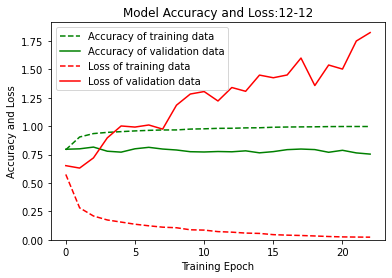


--- Check against test data ---

6584/6584 [==============================] - 1s 100us/step

Accuracy on test data: 0.86

Loss on test data: 0.76

--- Confusion matrix for test data ---



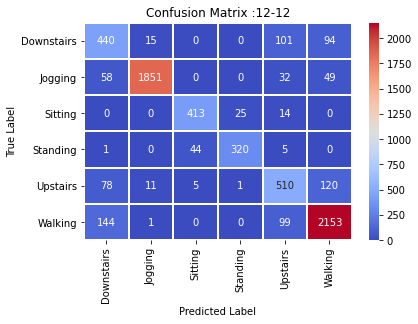


--- Classification report for test data 12:12---

              precision    recall  f1-score   support

           0       0.61      0.68      0.64       650
           1       0.99      0.93      0.96      1990
           2       0.89      0.91      0.90       452
           3       0.92      0.86      0.89       370
           4       0.67      0.70      0.69       725
           5       0.89      0.90      0.89      2397

    accuracy                           0.86      6584
   macro avg       0.83      0.83      0.83      6584
weighted avg       0.87      0.86      0.87      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 8s 492us/step - loss: 0.5698 - accuracy: 0.7906 - val_loss: 0.5900 - val_accuracy: 0.8035
Epoch 2/25
16694/16694 [==============================] - 8s 487us/step - loss: 0.2770 - accuracy: 0.9058 - val_loss: 0.5558 - val_accuracy: 0.8230
Epoch 3/25
16694/16694 [==============================] - 8s 

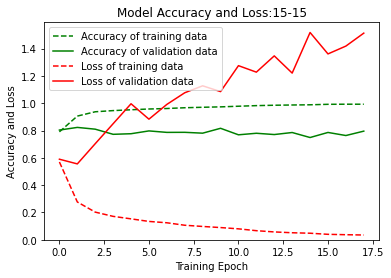


--- Check against test data ---

6584/6584 [==============================] - 1s 98us/step

Accuracy on test data: 0.87

Loss on test data: 0.68

--- Confusion matrix for test data ---



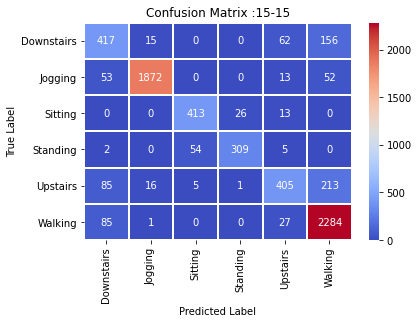


--- Classification report for test data 15:15---

              precision    recall  f1-score   support

           0       0.65      0.64      0.65       650
           1       0.98      0.94      0.96      1990
           2       0.88      0.91      0.89       452
           3       0.92      0.84      0.88       370
           4       0.77      0.56      0.65       725
           5       0.84      0.95      0.90      2397

    accuracy                           0.87      6584
   macro avg       0.84      0.81      0.82      6584
weighted avg       0.87      0.87      0.86      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 8s 450us/step - loss: 0.5626 - accuracy: 0.7926 - val_loss: 0.5552 - val_accuracy: 0.8273
Epoch 2/25
16694/16694 [==============================] - 7s 438us/step - loss: 0.2722 - accuracy: 0.9100 - val_loss: 0.6569 - val_accuracy: 0.8220
Epoch 3/25
16694/16694 [==============================] - 7s 

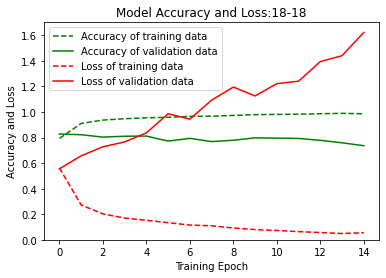


--- Check against test data ---

6584/6584 [==============================] - 1s 111us/step

Accuracy on test data: 0.84

Loss on test data: 0.70

--- Confusion matrix for test data ---



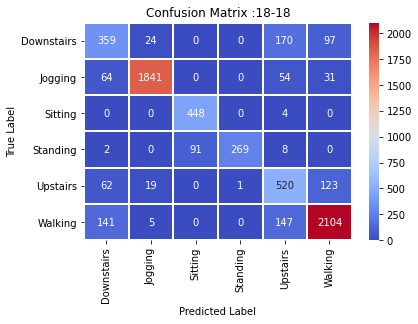


--- Classification report for test data 18:18---

              precision    recall  f1-score   support

           0       0.57      0.55      0.56       650
           1       0.97      0.93      0.95      1990
           2       0.83      0.99      0.90       452
           3       1.00      0.73      0.84       370
           4       0.58      0.72      0.64       725
           5       0.89      0.88      0.89      2397

    accuracy                           0.84      6584
   macro avg       0.81      0.80      0.80      6584
weighted avg       0.85      0.84      0.84      6584

Train on 16694 samples, validate on 4174 samples
Epoch 1/25
16694/16694 [==============================] - 8s 480us/step - loss: 0.5896 - accuracy: 0.7889 - val_loss: 0.5234 - val_accuracy: 0.8273
Epoch 2/25
16694/16694 [==============================] - 8s 459us/step - loss: 0.2903 - accuracy: 0.8995 - val_loss: 0.6255 - val_accuracy: 0.8110
Epoch 3/25
16694/16694 [==============================] - 8s 

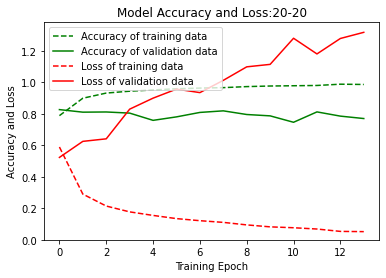


--- Check against test data ---

6584/6584 [==============================] - 1s 114us/step

Accuracy on test data: 0.85

Loss on test data: 0.64

--- Confusion matrix for test data ---



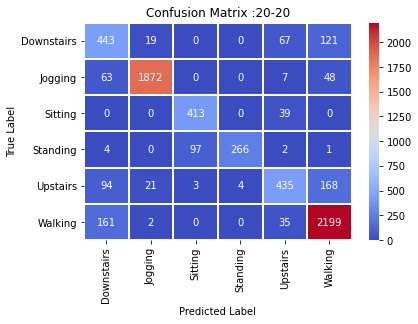


--- Classification report for test data 20:20---

              precision    recall  f1-score   support

           0       0.58      0.68      0.63       650
           1       0.98      0.94      0.96      1990
           2       0.81      0.91      0.86       452
           3       0.99      0.72      0.83       370
           4       0.74      0.60      0.66       725
           5       0.87      0.92      0.89      2397

    accuracy                           0.85      6584
   macro avg       0.83      0.80      0.80      6584
weighted avg       0.86      0.85      0.85      6584



{5: [0.7588092088699341,
  0.8065006136894226,
  0.8212332725524902,
  0.8327764272689819,
  0.8194106817245483,
  0.8497873544692993,
  0.8224483728408813,
  0.8449270725250244],
 10: [0.7642770409584045,
  0.7969319820404053,
  0.8373329043388367,
  0.8382441997528076,
  0.8513062000274658,
  0.8575333952903748,
  0.8576852679252625,
  0.85297691822052],
 15: [0.7654920816421509,
  0.822600245475769,
  0.8232077956199646,
  0.8444714546203613,
  0.8510024547576904,
  0.8540400862693787,
  0.8497873544692993,
  0.8596597909927368],
 20: [0.7893378138542175,
  0.8300425410270691,
  0.8465977907180786,
  0.8528250455856323,
  0.8510024547576904,
  0.849939227104187,
  0.8465977907180786,
  0.8628493547439575],
 25: [0.7867558002471924,
  0.8230558633804321,
  0.8475090861320496,
  0.8658869862556458,
  0.8531287908554077,
  0.8461421728134155,
  0.8546476364135742,
  0.8540400862693787],
 35: [0.7957168817520142,
  0.814246654510498,
  0.8587484955787659,
  0.8484204411506653,
  0.85571

In [49]:
val = {}
for k in [5,10,15,20,25,35,50,65,75,85,95,110,130,150,160,170,180,200]: #kernal
    tmp = []
    for f in [2,5,8,10,12,15,18,20]: #filter 
        try:
            tmp.append(call_model(kernal_size=k,filter_size=f))
        except:
            print("----------Failed_______",k,f)
    val[k] = tmp
val

In [50]:
kernal_filter_mat = pd.DataFrame(val)
kernal_filter_mat["index"] = np.array([2,5,8,10,12,15,18,20])
kernal_filter_mat.set_index("index")

5         10        15        20        25        35        50   \
index                                                                         
2      0.758809  0.764277  0.765492  0.789338  0.786756  0.795717  0.793742   
5      0.806501  0.796932  0.822600  0.830043  0.823056  0.814247  0.818803   
8      0.821233  0.837333  0.823208  0.846598  0.847509  0.858748  0.849180   
10     0.832776  0.838244  0.844471  0.852825  0.865887  0.848420  0.870899   
12     0.819411  0.851306  0.851002  0.851002  0.853129  0.855711  0.853584   
15     0.849787  0.857533  0.854040  0.849939  0.846142  0.851154  0.859356   
18     0.822448  0.857685  0.849787  0.846598  0.854648  0.850699  0.853736   
20     0.844927  0.852977  0.859660  0.862849  0.854040  0.853584  0.856774   

            65        75        85        95        110       130       150  \
index                                                                         
2      0.787971  0.792527  0.794198  0.781592  0.803767  0.816373  0.810753   
5      0.830498  0.831409  0.826397  0.827005  0.830194  0.835510  0.833991   
8      0.867862  0.861027  0.863913  0.866798  0.852369  0.866495  0.861786   
10     0.859356  0.856015  0.858597  0.858900  0.852066  0.856622  0.862242   
12     0.864976  0.865431  0.858748  0.854496  0.862697  0.859052  0.861331   
15     0.861482  0.859812  0.846598  0.863913  0.859508  0.857230  0.857685   
18     0.856774  0.852673  0.864368  0.862242  0.857533  0.857533  0.860723   
20     0.852977  0.850243  0.862090  0.863457  0.865735  0.861938  0.860571   

            160       170       180       200  
index                                          
2      0.798906  0.811817  0.806652  0.795413  
5      0.834143  0.829587  0.825334  0.833840  
8      0.859356  0.864976  0.857989  0.865583  
10     0.866039  0.851458  0.862546  0.861482  
12     0.859964  0.872722  0.843712  0.863761  
15     0.864520  0.852977  0.839459  0.865735  
18     0.871051  0.864064  0.860419  0.841586  
20     0.849180  0.854496  0.858293  0.854800

In [51]:
import pickle
with open('mhcnn_val.p','wb') as fp:
    pickle.dump(val,fp)
    
with open('mhcnn.p','wb') as fp:
    pickle.dump(kernal_filter_mat,fp)

In [52]:
final_val = []
for k,v in val.items():
    f_s = kernal_filter_mat["index"].values
    for i in range(len(f_s)):
        final_val.append([k,f_s[i],v[i]])
final_ker_filter = pd.DataFrame(final_val)
final_ker_filter.columns=['X',"Y","Z"]

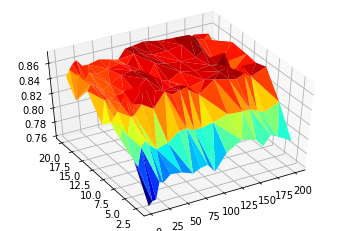

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(final_ker_filter["X"], final_ker_filter["Y"], final_ker_filter["Z"], cmap=plt.cm.jet, linewidth=0.2)
ax.view_init(45, 240)
plt.show()



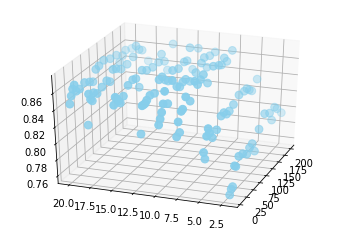

In [54]:
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_ker_filter["X"], final_ker_filter["Y"], final_ker_filter["Z"], c='skyblue', s=60)
ax.view_init(30, 200)#ax.view_init(30, 185)
plt.show()

